# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

import numpy as np

In [2]:
df = pd.read_spss('../data/CCAM SPSS Data 2008-2018.sav')
df.to_csv('../data/CCAM SPSS Data 2008-2018.csv', index=False)
df = pd.read_csv('../data/CCAM SPSS Data 2008-2018.csv')

In [3]:
geo = pd.read_csv('../data/YCOM6.0_2021_Data_.csv', encoding='latin-1')

In [4]:
df.drop('case_ID', axis=1, inplace=True)

## Review Target Column

In [5]:
df.happening.value_counts(normalize=True)

Yes           0.665373
Don't know    0.170325
No            0.161135
Refused       0.003167
Name: happening, dtype: float64

In [6]:
# drop Refused
df = df[df.happening != "Refused"]
df.reset_index(drop=True, inplace=True)

In [7]:
df.happening.value_counts(normalize=True)

Yes           0.667487
Don't know    0.170866
No            0.161647
Name: happening, dtype: float64

# Initial Inspection 

In [8]:
def columns_info(df):
    columns_df = pd.DataFrame({'nulls': [df[col].isna().sum() for col in df.keys()], 
                         'dtype': [df[col].dtype for col in df.keys()], 
                         'nunique_values': [df[col].nunique() for col in df.keys()], 
                         'unique_values': [df[col].unique()for col in df.keys()], 
                         'value_counts': [df[col].value_counts() for col in df.keys()]}, 
                         index=[col for col in df.keys()])
    return columns_df

# Function to Inspect Column
def col_info(col):
    return pd.DataFrame({'nulls': df[col].isna().sum(), 
                         'dtype': df[col].dtype,
                         'nunique': df[col].nunique(), 
                         'unique_values': [df[col].unique()], 
                         'value_counts': [df[col].value_counts()]}, 
                         index=[col])

In [9]:
# columns_info(df)

---
---

# Eploratory Data Analysis

### Happening

In [10]:
df.happening.value_counts().to_frame()

happening
Yes             14915
Don't know       3818
No               3612

### `happening` (target)

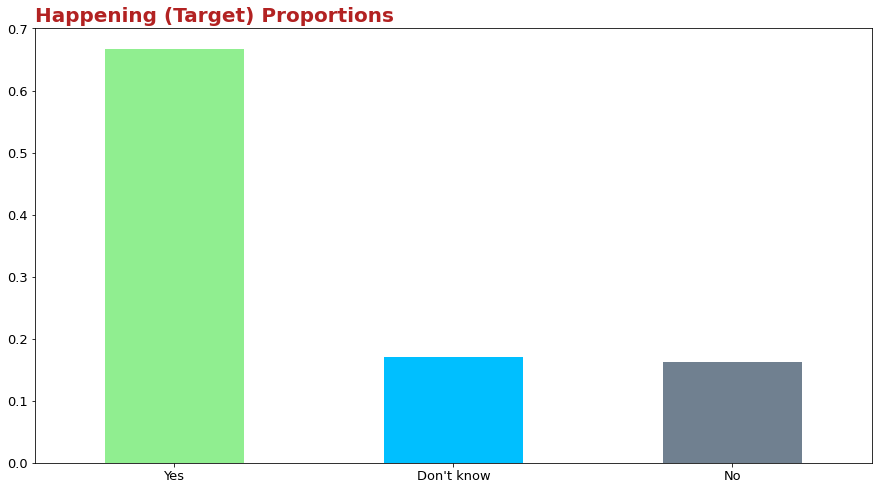

In [11]:
fig, ax = plt.subplots(figsize=(15, 8))

df.happening.value_counts(normalize=True).plot(kind='bar', 
                                               fontsize=13, 
                                               color=['lightgreen', 
                                                      'deepskyblue', 
                                                      'slategrey'])

ax.set_title('happening Proportions', 
                fontsize=15, 
                fontweight='bold', 
                color='firebrick', 
                loc='left')

plt.xticks(rotation = 0)

ax.set_title('Happening (Target) Proportions', 
                fontsize=20, 
                fontweight='bold', 
                color='firebrick', 
                loc='left')
plt.tight_layout;

### Patterns of Missingness

**Questions with "Refused" possible answers**

happening
cause_original
cause_recoded
sci_consensus
worry
harm_personally
harm_US
harm_dev_countries
harm_future_gen
harm_plants_animals
when_harm_US
reg_CO2_pollutant
reg_utilities
fund_research
reg_coal_emissions
discuss_GW
hear_GW_media
ideology
party
party_w_leaners
party_x_ideo
registered_voter
religion
evangelical
service_attendance

In [12]:
tdf = df[['happening', 'cause_recoded', 'sci_consensus', 'worry', 'harm_personally',
          'harm_US', 'harm_dev_countries', 'harm_future_gen', 'harm_plants_animals',
          'when_harm_US', 'reg_CO2_pollutant', 'reg_utilities', 'fund_research',
          'reg_coal_emissions', 'discuss_GW', 'hear_GW_media', 'ideology', 'party',
          'party_w_leaners', 'party_x_ideo', 'registered_voter', 'religion', 'evangelical',
         'service_attendance']]

tdf.head()

happening                                      cause_recoded  \
0         Yes                  Caused mostly by human activities   
1  Don't know                  Caused mostly by human activities   
2  Don't know  Caused mostly by natural changes in the enviro...   
3         Yes  Caused mostly by natural changes in the enviro...   
4         Yes                  Caused mostly by human activities   

                                       sci_consensus               worry  \
0  Most scientists think global warming is happening    Somewhat worried   
1                           Don't know enough to say    Not very worried   
2  There is a lot of disagreement among scientist...  Not at all worried   
3  Most scientists think global warming is happening    Somewhat worried   
4  There is a lot of disagreement among scientist...    Somewhat worried   

  harm_personally            harm_US harm_dev_countries    harm_future_gen  \
0   Only a little  A moderate amount       A great deal       A great deal   
1   Only a little            Refused      Only a little  A moderate amount   
2      Not at all         Not at all         Not at all         Not at all   
3   Only a little      Only a little  A moderate amount  A moderate amount   
4      Don't know         Don't know         Don't know         Don't know   

  harm_plants_animals  when_harm_US  ...    discuss_GW hear_GW_media  \
0        A great deal   In 10 years  ...  Occasionally           NaN   
1   A moderate amount   In 50 years  ...        Rarely           NaN   
2          Not at all         Never  ...         Never           NaN   
3   A moderate amount   In 25 years  ...        Rarely           NaN   
4   A moderate amount  In 100 years  ...         Never           NaN   

                       ideology                                party  \
0         Somewhat conservative                           Republican   
1  Moderate, middle of the road  No party/not interested in politics   
2         Somewhat conservative                           Republican   
3         Somewhat conservative                          Independent   
4         Somewhat conservative                           Republican   

                       party_w_leaners                         party_x_ideo  \
0                          Republicans              Conservative Republican   
1  No party/Not interested in politics  No Party/Not Interested in politics   
2                          Republicans              Conservative Republican   
3                          Republicans              Conservative Republican   
4                          Republicans              Conservative Republican   

  registered_voter                                           religion  \
0       Registered  Protestant (e.g., Methodist, Lutheran, Presbyt...   
1   Not registered  Protestant (e.g., Methodist, Lutheran, Presbyt...   
2       Registered                                             Mormon   
3       Registered  Protestant (e.g., Methodist, Lutheran, Presbyt...   
4       Registered                         Baptist - any denomination   

  evangelical   service_attendance  
0          No          Once a week  
1  Don't Know  Once a year or less  
2          No          Once a week  
3          No  Once a year or less  
4         Yes          Once a week  

[5 rows x 24 columns]

In [13]:
tdf.isna().sum()

happening                  0
cause_recoded              0
sci_consensus           1330
worry                      0
harm_personally            0
harm_US                    0
harm_dev_countries         0
harm_future_gen            0
harm_plants_animals     1330
when_harm_US               0
reg_CO2_pollutant        998
reg_utilities           5026
fund_research              0
reg_coal_emissions      9034
discuss_GW                 0
hear_GW_media          13587
ideology                   0
party                      0
party_w_leaners            0
party_x_ideo               0
registered_voter           0
religion                   0
evangelical                0
service_attendance         0
dtype: int64

In [14]:
for column in tdf.columns:
    for i, answer in enumerate(tdf[column]):
        if answer == 'Refused':
#             print(column, i, answer)
            tdf[column][i] = np.nan

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_18681/1684563418.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf[column][i] = np.nan


In [15]:
tdf.isna().sum()

happening                  0
cause_recoded             50
sci_consensus           1375
worry                     42
harm_personally           60
harm_US                   82
harm_dev_countries        92
harm_future_gen           85
harm_plants_animals     1421
when_harm_US             166
reg_CO2_pollutant       1502
reg_utilities           5468
fund_research            500
reg_coal_emissions      9176
discuss_GW                37
hear_GW_media          13650
ideology                 420
party                    205
party_w_leaners          205
party_x_ideo             308
registered_voter         182
religion                 276
evangelical              267
service_attendance       292
dtype: int64

In [16]:
pattern = tdf.isnull()[~tdf.isnull().duplicated()].applymap(lambda x: int(x))

lister = [] # count up appearance of each pattern

for i in range(len(pattern)):
    counter = 0

    for j in tdf.isnull().values:
        if np.array_equal(j, pattern.values[i]):
            counter += 1 
    lister.append(counter)

pattern.reset_index(drop=True, 
                    inplace = True) # reset index

# num of missing values per pattern
pattern['num_per_row'] = pattern.sum(axis=1).values

pattern['count'] = lister # number of times a pattern appears in dataset

pattern.sort_values('num_per_row', ascending=False) # sort values

happening  cause_recoded  sci_consensus  worry  harm_personally  harm_US  \
43           0              1              1      1                1        1   
57           0              0              1      1                1        1   
92           0              1              1      1                1        1   
132          0              1              0      1                1        1   
248          0              1              1      0                1        1   
..         ...            ...            ...    ...              ...      ...   
276          0              0              0      0                0        0   
278          0              0              0      0                0        0   
279          0              0              0      0                0        0   
277          0              0              0      0                0        0   
268          0              0              0      0                0        0   

     harm_dev_countries  harm_future_gen  harm_plants_animals  when_harm_US  \
43                    1                1                    1             1   
57                    1                1                    1             1   
92                    1                1                    1             0   
132                   1                1                    1             1   
248                   1                1                    1             1   
..                  ...              ...                  ...           ...   
276                   0                0                    0             0   
278                   0                0                    0             0   
279                   0                0                    0             0   
277                   0                0                    0             0   
268                   0                0                    0             0   

     ...  ideology  party  party_w_leaners  party_x_ideo  registered_voter  \
43   ...         1      1                1             1                 1   
57   ...         1      1                1             1                 1   
92   ...         1      1                1             1                 1   
132  ...         1      1                1             1                 1   
248  ...         1      1                1             1                 1   
..   ...       ...    ...              ...           ...               ...   
276  ...         0      0                0             0                 0   
278  ...         0      0                0             0                 0   
279  ...         0      0                0             0                 0   
277  ...         0      0                0             0                 0   
268  ...         0      0                0             0                 0   

     religion  evangelical  service_attendance  num_per_row  count  
43          1            1                   1           23      3  
57          1            1                   1           22      2  
92          1            1                   1           22      1  
132         1            1                   1           22      2  
248         1            0                   1           21      1  
..        ...          ...                 ...          ...    ...  
276         0            0                   1            1     17  
278         0            0                   0            1     15  
279         0            0                   0            1     24  
277         0            0                   0            1     25  
268         0            0                   0            0   4613  

[434 rows x 26 columns]

---
---

In [17]:
null_counts = tdf.isnull().applymap(lambda x: int(x))

null_counts['num_per_row'] = null_counts.sum(axis=1).values

null_counts[null_counts.num_per_row >= 20]['happening'].count()

11

In [18]:
null_counts

happening  cause_recoded  sci_consensus  worry  harm_personally  \
0              0              0              0      0                0   
1              0              0              0      0                0   
2              0              0              0      0                0   
3              0              0              0      0                0   
4              0              0              0      0                0   
...          ...            ...            ...    ...              ...   
22340          0              0              0      0                0   
22341          0              0              0      0                0   
22342          0              0              0      0                0   
22343          0              0              0      0                0   
22344          0              0              0      0                0   

       harm_US  harm_dev_countries  harm_future_gen  harm_plants_animals  \
0            0                   0                0                    0   
1            1                   0                0                    0   
2            0                   0                0                    0   
3            0                   0                0                    0   
4            0                   0                0                    0   
...        ...                 ...              ...                  ...   
22340        0                   0                0                    0   
22341        0                   0                0                    0   
22342        0                   0                0                    0   
22343        0                   0                0                    0   
22344        0                   0                0                    0   

       when_harm_US  ...  hear_GW_media  ideology  party  party_w_leaners  \
0                 0  ...              1         0      0                0   
1                 0  ...              1         0      0                0   
2                 0  ...              1         0      0                0   
3                 0  ...              1         0      0                0   
4                 0  ...              1         0      0                0   
...             ...  ...            ...       ...    ...              ...   
22340             0  ...              0         0      0                0   
22341             0  ...              0         0      0                0   
22342             0  ...              0         0      0                0   
22343             0  ...              0         0      0                0   
22344             0  ...              0         0      0                0   

       party_x_ideo  registered_voter  religion  evangelical  \
0                 0                 0         0            0   
1                 0                 0         0            0   
2                 0                 0         0            0   
3                 0                 0         0            0   
4                 0                 0         0            0   
...             ...               ...       ...          ...   
22340             0                 0         0            0   
22341             0                 0         0            0   
22342             0                 0         0            0   
22343             0                 0         0            0   
22344             0                 0         0            0   

       service_attendance  num_per_row  
0                       0            2  
1                       0            3  
2                       0            2  
3                       0            2  
4                       0            2  
...                   ...          ...  
22340                   0            0  
22341                   0            0  
22342                   0            0  
22343                   0            0  
22344                   0            0  

[22345 rows x 25 c

In [19]:
null_counts.num_per_row.value_counts().sort_index()

0     4613
1     5607
2     8594
3     2771
4      279
5      196
6       84
7       39
8       32
9       25
10      29
11      13
12      13
13      19
14       8
15       1
16       2
17       2
18       3
19       4
20       2
21       1
22       5
23       3
Name: num_per_row, dtype: int64

In [20]:
print(null_counts.shape, '\n')

print('Questions answered "Refused":')

print('80% or more "Refused"',  - round(24 * .20), 'Questions - ',
      null_counts[null_counts.num_per_row >= 5]['happening'].count(), 'people -', 
      round((null_counts[null_counts.num_per_row >= 5]['happening'].count() / df.shape[0]) * 100, 2), 
      '% of dataset'
     )

print('75% or more "Refused"',  - round(24 * .25), 'Questions - ',
      null_counts[null_counts.num_per_row >= 6]['happening'].count(), 'people -', 
      round((null_counts[null_counts.num_per_row >= 6]['happening'].count() / df.shape[0]) * 100, 2), 
      '% of dataset'
     )

print('50% or more "Refused"', -round(24 * .50), 'Questions - ',
      null_counts[null_counts.num_per_row >= 12]['happening'].count(), 'people -', 
      round((null_counts[null_counts.num_per_row >= 12]['happening'].count() / df.shape[0]) * 100, 2), 
      '% of dataset'
     )

# null_counts[null_counts.num_per_row >= 13][['happening', 'num_per_row']].sort_values('num_per_row', ascending=False)

(22345, 25) 

Questions answered "Refused":
80% or more "Refused" -5 Questions -  481 people - 2.15 % of dataset
75% or more "Refused" -6 Questions -  285 people - 1.28 % of dataset
50% or more "Refused" -12 Questions -  63 people - 0.28 % of dataset


In [21]:
df.drop(index=null_counts[null_counts.num_per_row >= 5]['happening'].index, inplace=True)
df.reset_index(drop=True, inplace=True)

### Wave

In [22]:
df.wave = [' '.join(wave.split(' ')[::-1]) for wave in df.wave]

In [23]:
df.wave.value_counts().sort_index().to_frame()

wave
2008 Nov  2101
2010 Jan   952
2010 Jun  1002
2011 May   951
2011 Nov   936
2012 Mar   958
2012 Sep  1011
2013 Apr  1012
2013 Nov   798
2014 Apr   997
2014 Oct  1262
2015 Mar  1254
2015 Oct  1298
2016 Mar  1188
2016 Nov  1219
2017 May  1255
2017 Oct  1298
2018 Dec  1110
2018 Mar  1262

In [24]:
df.wave.value_counts().sort_index()[1:].values.mean()

1097.9444444444443

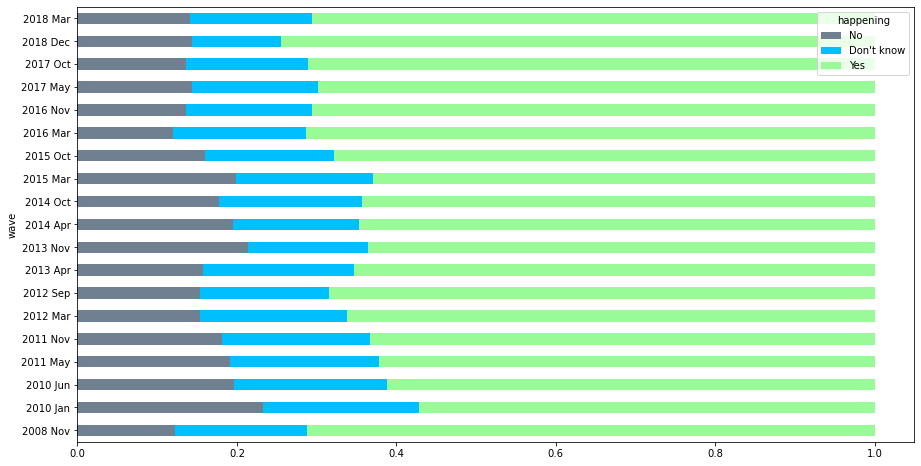

In [25]:
df.groupby('wave')['happening'].value_counts(normalize=True).unstack().T.loc[['No', "Don't know", 'Yes']].T \
    .plot(kind='barh',
          figsize=(15, 8), 
          stacked=True,
          color=['slategrey', 'deepskyblue', 'palegreen']);

**Wave**

Observation
- The first poll had the largest number of responses. 
- Each poll afterwards had 1125 responses on average. 
- It seems like the number of people in each poll was divided in half after the first year. 

### Year

**Proportion of Believe in Climate Change over 2008 - 2018**

''

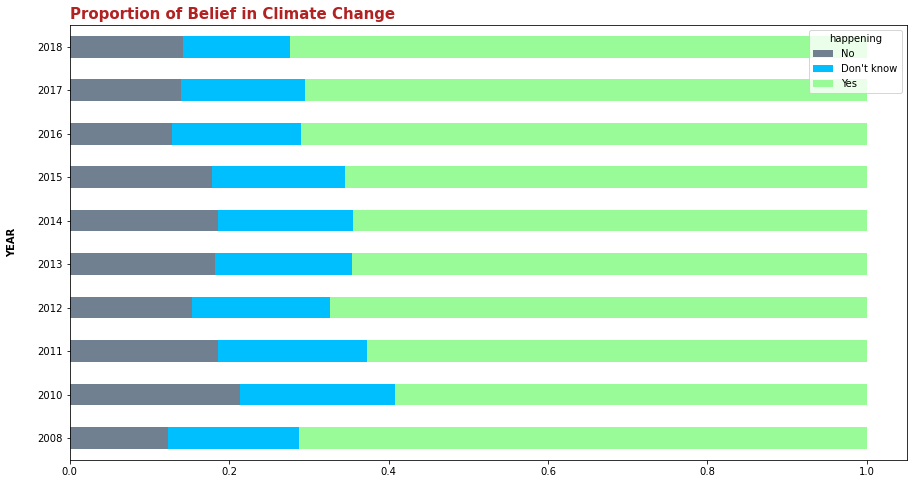

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

df.groupby('year')['happening'].value_counts(normalize=True).unstack().T.loc[['No', "Don't know", 'Yes']].T \
    .plot(kind='barh', 
          figsize=(15, 8), 
          stacked=True,
          color=['slategrey', 'deepskyblue', 'palegreen'], 
          ax=ax)

ax.set_title('Proportion of Belief in Climate Change', 
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left')
ax.set_ylabel('YEAR', weight='bold', labelpad=20)

;

In [27]:
df.year.value_counts().to_frame()

year
2017  2553
2015  2552
2016  2407
2018  2372
2014  2259
2008  2101
2012  1969
2010  1954
2011  1887
2013  1810

In [28]:
df.groupby('year')['happening'].value_counts(normalize=True).to_frame().unstack()

happening                    
happening Don't know        No       Yes
year                                    
2008        0.164683  0.122799  0.712518
2010        0.193961  0.213920  0.592119
2011        0.186539  0.186539  0.626921
2012        0.172676  0.153885  0.673438
2013        0.172376  0.182320  0.645304
2014        0.169544  0.185480  0.644976
2015        0.166536  0.179075  0.654389
2016        0.162027  0.128376  0.709597
2017        0.155112  0.139835  0.705053
2018        0.134064  0.142074  0.723862

**Proportion of Believe in Climate Change over 2008 - 2018**

Observation
- 

### Weight Wave

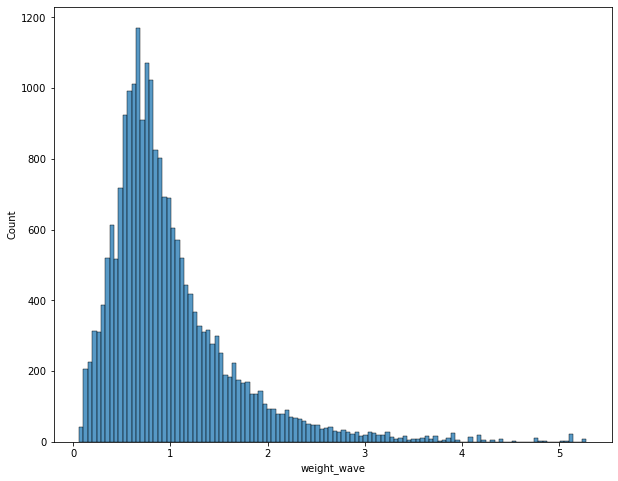

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(df, x='weight_wave', ax=ax);

In [30]:
df.weight_wave.describe()

count    21864.000000
mean         0.995727
std          0.653089
min          0.060000
25%          0.587400
50%          0.824200
75%          1.218100
max          5.280000
Name: weight_wave, dtype: float64

In [31]:
df.groupby('year')['weight_wave'].value_counts().to_frame()

weight_wave
year weight_wave             
2008 0.5500                30
     0.5400                29
     0.5800                29
     0.1400                27
     0.6100                27
...                       ...
2018 3.2767                 1
     3.2917                 1
     3.4013                 1
     3.6874                 1
     3.7050                 1

[10895 rows x 1 columns]

**weight_wave**

Observation
- Not sure how they calculated the sampling weight for different waves of polling 
- I don't see how this feature would be useful in modeling or analyzing relationships between features and target

### Cause Original
Assuming global warming is happening do you think it is...

In [32]:
x = df.groupby('happening')['cause_original'].value_counts().to_frame().unstack().T
x['num_per_row'] = x.sum(axis=1).values
x

happening                                                          Don't know  \
               cause_original                                                   
cause_original Caused mostly by human activities                         1072   
               Caused mostly by natural changes in the environ...        1815   
               None of the above because global warming isn't ...         332   
               Other (Please specify)                                     414   
               Refused                                                      8   

happening                                                            No   Yes  \
               cause_original                                                   
cause_original Caused mostly by human activities                    337  9917   
               Caused mostly by natural changes in the environ...  1836  3363   
               None of the above because global warming isn't ...  1062    29   
               Other (Please specify)                               301  1365   
               Refused                                                4     9   

happening                                                          num_per_row  
               cause_original                                                   
cause_original Caused mostly by human activities                         11326  
               Caused mostly by natural changes in the environ...         7014  
               None of the above because global warming isn't ...         1423  
               Other (Please specify)                                     2080  
               Refused                                                      21

''

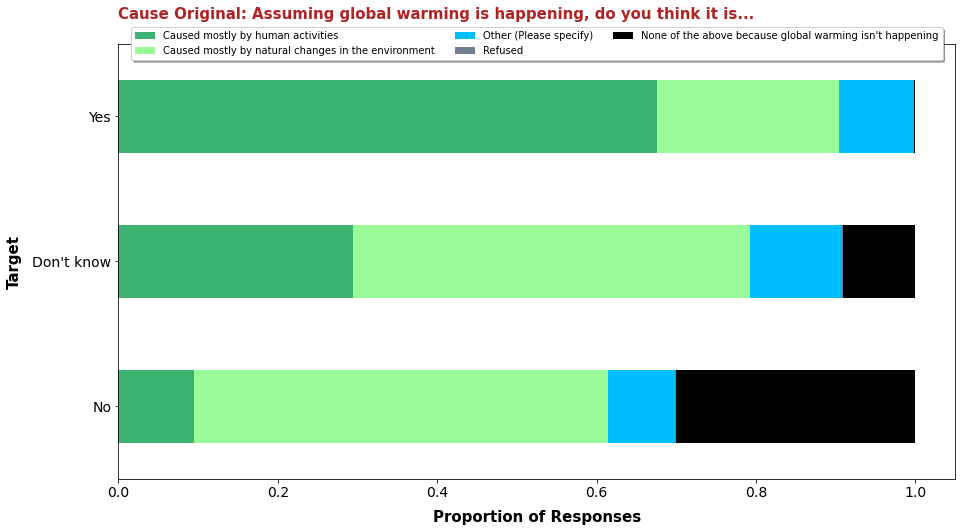

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['cause_original'].value_counts(normalize=True)\
.unstack().loc[['No', "Don't know", 'Yes']].T\
          .loc[['Caused mostly by human activities',
               'Caused mostly by natural changes in the environment',
               'Other (Please specify)',
               'Refused',
               "None of the above because global warming isn't happening"]].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True,
                                            fontsize=14,
                                            color=['mediumseagreen', 
                                                   'palegreen',
                                                   'deepskyblue', 
                                                   'slategrey',
                                                   'black'], 
                                           label=('1', '2'))
ax.set_title('Cause Original: Assuming global warming is happening, do you think it is...', 
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left', 
             pad=25)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=10)
ax.set_xlabel('Proportion of Responses', weight='bold', fontsize=15, labelpad=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
;

**Cause Original**

Observation 
- 95 people refused to answer this question 
- For each `happening` subgroup, some people "None of the above because global warming isn't happening." 30 people who said "Yes" to `happening` selected this response for this question 
- For the 'No' subgroup of `happening`, 2,960 people selected either of the two choices that state what the cause of global warming is. This is a contradiction. 
- Drop "Refused" when ordinal encoding feature
    1. "None of the above because global warming isn't happening"
    2. "Other (Please specify)"
    3. "Caused mostly by natural changes in the environment"
    4. "Caused mostly by human activities"

In [34]:
df.drop(columns=['cause_original'], axis=1, inplace=True)

### Cause Other Text

[Other - Specify] Assuming global warming is happening, do you think it is...

- This feature had empty strings that I converted to np.nan
- Were these questions only answered if cause_original responses was "Other"

In [41]:
# Number of "Other (Please specify)" in cause_original
# df[df.cause_original == 'Other (Please specify)']['cause_original'].count()

In [37]:
# People who answer 'other' in 1st question, but didn't specify here as directed
# df.cause_other_text.fillna('', inplace=True)

# df[(df.cause_original == 'Other (Please specify)') & 
#    (df.cause_other_text == '')]['cause_other_text'].count()

In [ ]:
# Responses to cause_original for people who didn't answer this question 
# df[df.cause_other_text == '']['cause_original'].value_counts().to_frame()

In [38]:
df.cause_other_text.value_counts(dropna=False)

                                                                  19912
both                                                                115
Both                                                                 58
both of the above                                                    29
combination of both                                                  23
                                                                  ...  
caused as a combination of natural cycles AND human activities        1
the solor system is heating up                                        1
G0d is in charge of  our universe                                     1
BOTH HUMAN AND NATURAL                                                1
it is caused by both                                                  1
Name: cause_other_text, Length: 1373, dtype: int64

In [39]:
# How many people did answer this question 
df[df.cause_other_text != '']['happening'].count()

1952

In [40]:
df.cause_other_text.nunique()

1373

**Cause Other Text**

- there are a 2126 unique answers. Many of them mean the same thing and could be grouped. It could be interesting to investigate further and get more ideas about the data.  
    - lots of people said it was both, meaning both human activity and natural causes 
    - lots of people reference God
    - lot of people said they don't know 
- 1991 people responded to this question
- 135 people who answered "Other" for `cause_original` did not specify here as instructed
- Because only 9% of people answered this question, and it overlaps with `cause_original`, this feature is unlikely to be useful

In [ ]:
df.drop(columns=['cause_other_text'], axis=1, inplace=True)

### Cause Recorded

Assuming global warming is happening, do you think it is... (Recoded to include open-ends)

- it seems this feature was created from combining both `cause_original` and `cause_original_text`

In [42]:
# df.cause_recoded.value_counts().to_frame()

x = df.groupby('happening')['cause_recoded'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)
x.astype(dtype=int, errors='ignore')

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_18681/2947318618.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening                                      cause_recoded  Don't know  \
0             Caused by human activities and natural changes         221   
1                          Caused mostly by human activities        1080   
2          Caused mostly by natural changes in the enviro...        1870   
3                                                 Don't know          67   
4             Neither because global warming isn't happening         334   
5                                     Other (Please specify)          61   
6                                                    Refused           8   
(sum)                                                      0        3641   

happening    No    Yes  (sum)  
0            46   1083   1350  
1           342   9989  11411  
2          1979   3440   7289  
3             5     43    115  
4          1075     29   1438  
5            89     90    240  
6             4      9     21  
(sum)      3540  14683  21864

''

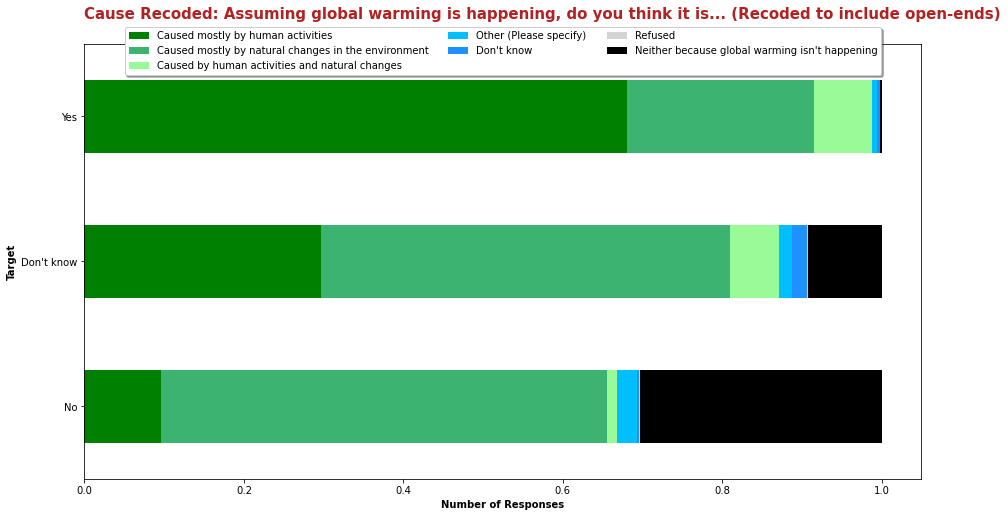

In [43]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['cause_recoded'].value_counts(normalize=True).unstack()\
.loc[['No', "Don't know", 'Yes']].T\
.loc[['Caused mostly by human activities', 
      'Caused mostly by natural changes in the environment', 
      'Caused by human activities and natural changes', 
      'Other (Please specify)', 
      "Don't know", 
      'Refused', 
      "Neither because global warming isn't happening"]].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True, 
                                            color=['g', 
                                                   'mediumseagreen', 
                                                   'palegreen', 
                                                   'deepskyblue',
                                                   'dodgerblue', 
                                                   'lightgrey', 
                                                   'black'], 
                                           label=('1', '2'))
ax.set_title('Cause Recoded: Assuming global warming is happening, do you think it is... (Recoded to include open-ends)', 
             fontsize=15, 
             fontweight='bold', 
             color='firebrick', 
             loc='left', 
             pad=25)
ax.set_ylabel('Target', weight='bold')
ax.set_xlabel('Number of Responses', weight='bold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
;

**Cause Recoded**

Observation 
- "Don't Know" and "Caused by human activities and natural changes" were added. 
- "Refused" had no change between `cause_original` and `cause_original_text`
- Differences in answers from `cause_original` = "Other (Please specify) and `cause_recoded`
    - 17 people answered "Neither because global warming isn't happening" here
    - 1647 people answered either the 1st 2 questions meaning they believe in Global Warming 
    - 252 people still responded "Other (Please specify)" 

### SCI Concensus 

Scientist Consensus: Which comes closest to your own view?
- Not asked in Oct 2015

In [44]:
# Number of Nulls in sci_consensus from "2016 Oct"
df.sci_consensus.isnull().sum()

1298

In [45]:
x = df.groupby('happening')['sci_consensus'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_18681/2592813390.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening                                      sci_consensus  Don't know  \
0                                                          0         209   
1                                   Don't know enough to say        1385   
2          Most scientists think global warming is happening         426   
3          Most scientists think global warming is not ha...          53   
4                                                    Refused           5   
5          There is a lot of disagreement among scientist...        1563   
(sum)                                                      0        3641   

happening    No    Yes  (sum)  
0           208    881   1298  
1           380   1657   3422  
2           227   8618   9271  
3           508    130    691  
4             5     12     22  
5          2212   3385   7160  
(sum)      3540  14683  21864

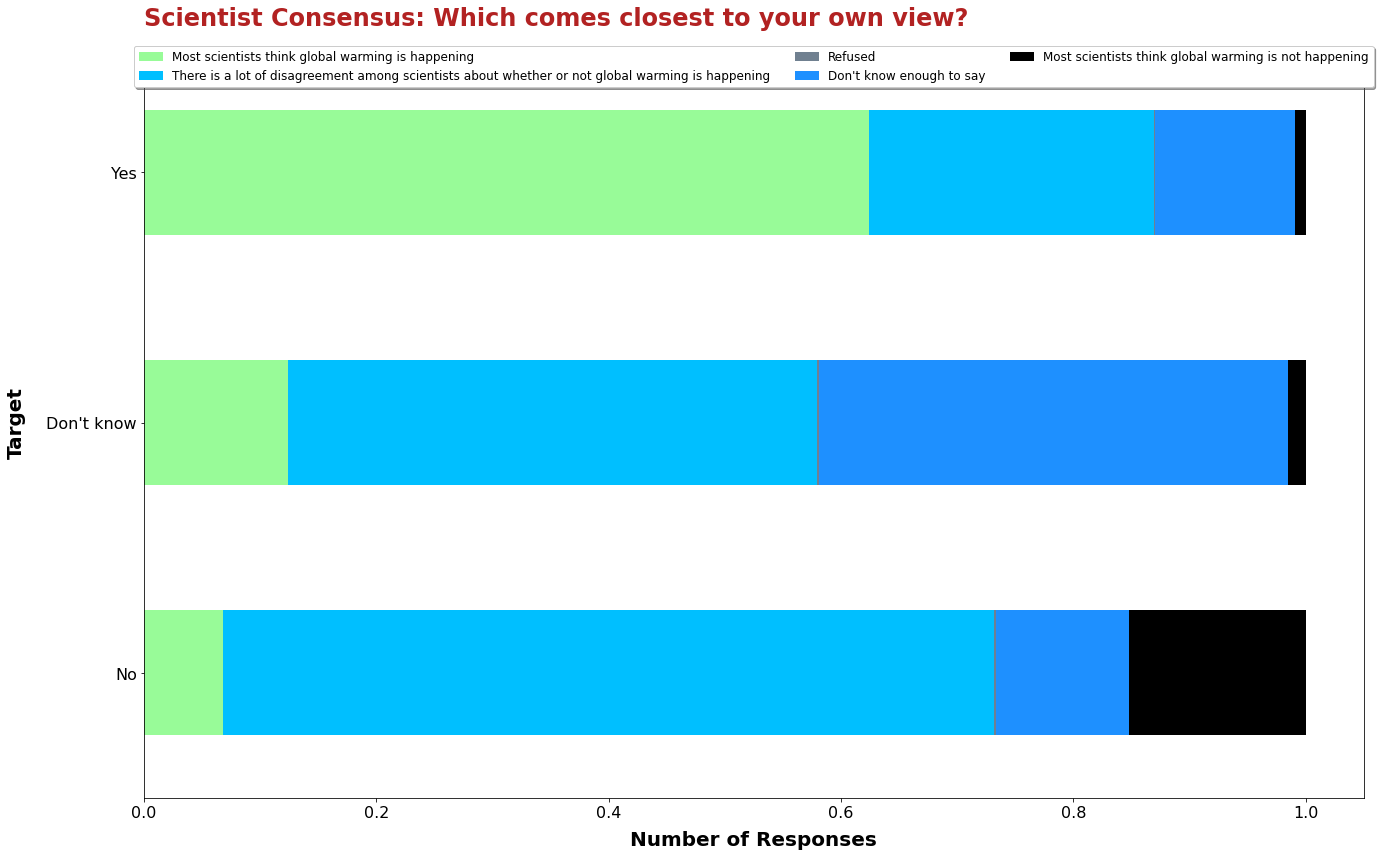

In [46]:
fig, ax = plt.subplots(figsize=(20, 12))

df.groupby('happening')['sci_consensus'].value_counts(normalize=True).unstack().loc[['No', "Don't know", 'Yes']].T\
.loc[['Most scientists think global warming is happening', 
      'There is a lot of disagreement among scientists about whether or not global warming is happening', 
      'Refused',
      "Don't know enough to say", 
      'Most scientists think global warming is not happening']].T\
                                      .plot(kind='barh', 
                                            ax=ax, 
                                            stacked=True,
                                            color=['palegreen', 
                                                   'deepskyblue',
                                                   'slategrey',
                                                   'dodgerblue',
                                                   'black'], 
                                           label=('1', '2'), 
                                           fontsize=16)
ax.set_title('Scientist Consensus: Which comes closest to your own view?', 
             fontsize=24, fontweight='bold', color='firebrick', loc='left', pad=22)
ax.set_ylabel('Target', weight='bold', fontsize=20, labelpad=20)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=20, labelpad=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.01),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

In [49]:
df.groupby('happening')['sci_consensus'].value_counts().to_frame().unstack().T

happening                                                         Don't know  \
              sci_consensus                                                    
sci_consensus Don't know enough to say                                  1385   
              Most scientists think global warming is happening          426   
              Most scientists think global warming is not hap...          53   
              Refused                                                      5   
              There is a lot of disagreement among scientists...        1563   

happening                                                           No   Yes  
              sci_consensus                                                   
sci_consensus Don't know enough to say                             380  1657  
              Most scientists think global warming is happening    227  8618  
              Most scientists think global warming is not hap...   508   130  
              Refused                                                5    12  
              There is a lot of disagreement among scientists...  2212  3385

**Science Consensus**

Observation 
- 90 people Refused to answer this question 
- This question is the least likely to leak data into the model
- 1330 Nulls for this feature from 2015 Oct
    - possible to impute with KNNImputer

### Worry

How worried are you about global warming?

In [50]:
x = df.groupby('happening')['worry'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_18681/2187703950.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening               worry  Don't know    No    Yes  (sum)
0          Not at all worried         802  2167    773   3742
1            Not very worried        1776  1198   2887   5861
2                     Refused           5     4     11     20
3            Somewhat worried        1003   156   7694   8853
4                Very worried          55    15   3318   3388
(sum)                       0        3641  3540  14683  21864

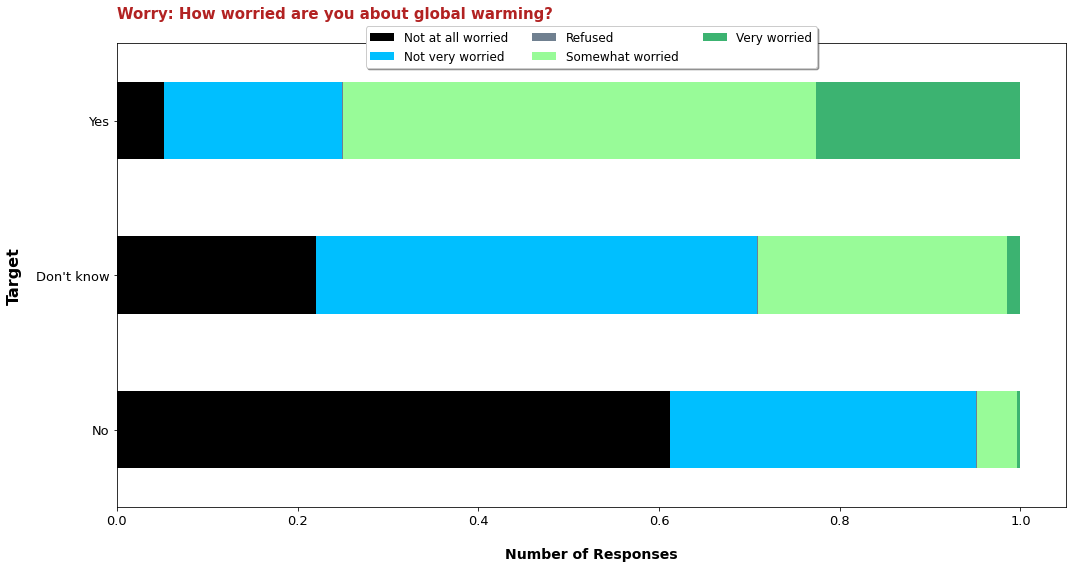

In [51]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['worry'].value_counts(dropna=False, normalize=True).unstack().loc[['No', "Don't know", 'Yes']] \
                                      .plot(kind='barh', 
                                            ax=ax,
                                            stacked=True,
                                            color=['black',
                                                   'deepskyblue',
                                                   'slategrey',
                                                   'palegreen', 
                                                   'mediumseagreen',
                                                   'g'], 
                                           label=('1', '2'), 
                                           fontsize=13)
ax.set_title('Worry: How worried are you about global warming?', 
             fontsize=15, fontweight='bold', color='firebrick', loc='left', pad=25)
ax.set_ylabel('Target', weight='bold', fontsize=16, labelpad=14)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=14, labelpad=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

**Worry**

Observation 
- 83 people Refused 
- For `happening` = "Not Yes"
    - 68 Refused
    - 3056 Not at all worried 
    - 19292 expressed some level of worry
- This feature might be misleading for predicting the target
- This feature could be reduced to binary (worry_True, worry_False) for OHE
- Could also reduce to 3 subgroups (not_worried, worried, very_worried)

## Harm Series of Questions
The following five risk perception questions were asked together as a set
- harm_personally
- harm_US
- harm_dev_coutnries
- harm_future_gen
- harm_plants_animals

### Harm Personally
How much do you think global warming will harm: You personally

In [52]:
x = df.groupby('happening')['harm_personally'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_18681/2848853250.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening            harm_US  Don't know    No    Yes  (sum)
0               A great deal         235    56   4714   5005
1          A moderate amount         830   285   5517   6632
2                 Don't know        1054   295   1038   2387
3                 Not at all         595  2234    744   3573
4              Only a little         923   662   2649   4234
5                    Refused           4     8     21     33
(sum)                      0        3641  3540  14683  21864

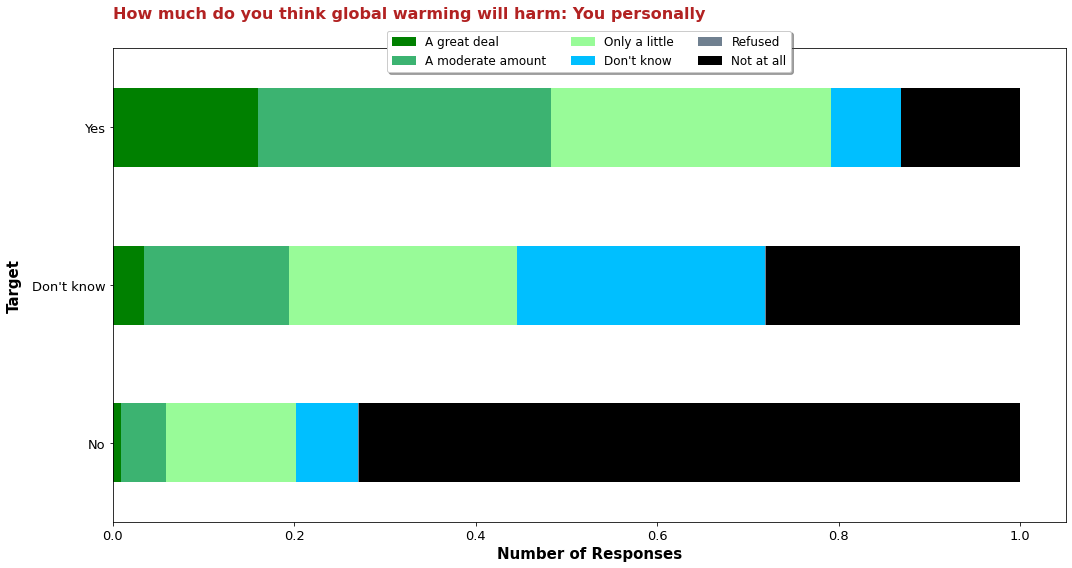

In [61]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['harm_personally'].value_counts(normalize=True)\
  .unstack()\
  .loc[['No', "Don't know", 'Yes']].T\
  .loc[['A great deal',
        'A moderate amount',
        'Only a little',
        "Don't know",
        'Refused',
        'Not at all']].T.plot(kind='barh', 
                              ax=ax, 
                              stacked=True,
                              fontsize=13, 
                            color=['g', 
                                   'mediumseagreen', 
                                   'palegreen',
                                   'deepskyblue',
                                   'slategrey',
                                   'black'],
                           label=('1', '2'))
ax.set_title('How much do you think global warming will harm: You personally', 
             fontsize=16, fontweight='bold', color='firebrick', loc='left', pad=30)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=10)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

In [58]:
df.groupby('happening')['harm_personally'].value_counts().to_frame().unstack().T

happening                          Don't know    No   Yes
                harm_personally                          
harm_personally A great deal              127    32  2356
                A moderate amount         579   175  4737
                Don't know                997   243  1138
                Not at all               1020  2579  1922
                Only a little             914   507  4521
                Refused                     4     4     9

**Harm Personally**

Observation 
- 103 people "Refused"
- This will be a good predictor 

### Harm US
How much do you think global warming will harm: People in the United States

In [59]:
x = df.groupby('happening')['harm_US'].value_counts(dropna=False).to_frame().unstack().T
x.reset_index(inplace=True)
x.drop('level_0', axis=1, inplace=True)
x['(sum)'] = x.sum(axis=1).values
x.loc['(sum)'] = x.sum(numeric_only=True)
x.replace(np.nan, 0, inplace=True)

/var/folders/6_/32r78n_d53x2nss5m1qjc1pc0000gn/T/ipykernel_18681/404011177.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  x['(sum)'] = x.sum(axis=1).values


happening            harm_US  Don't know    No    Yes  (sum)
0               A great deal         235    56   4714   5005
1          A moderate amount         830   285   5517   6632
2                 Don't know        1054   295   1038   2387
3                 Not at all         595  2234    744   3573
4              Only a little         923   662   2649   4234
5                    Refused           4     8     21     33
(sum)                      0        3641  3540  14683  21864

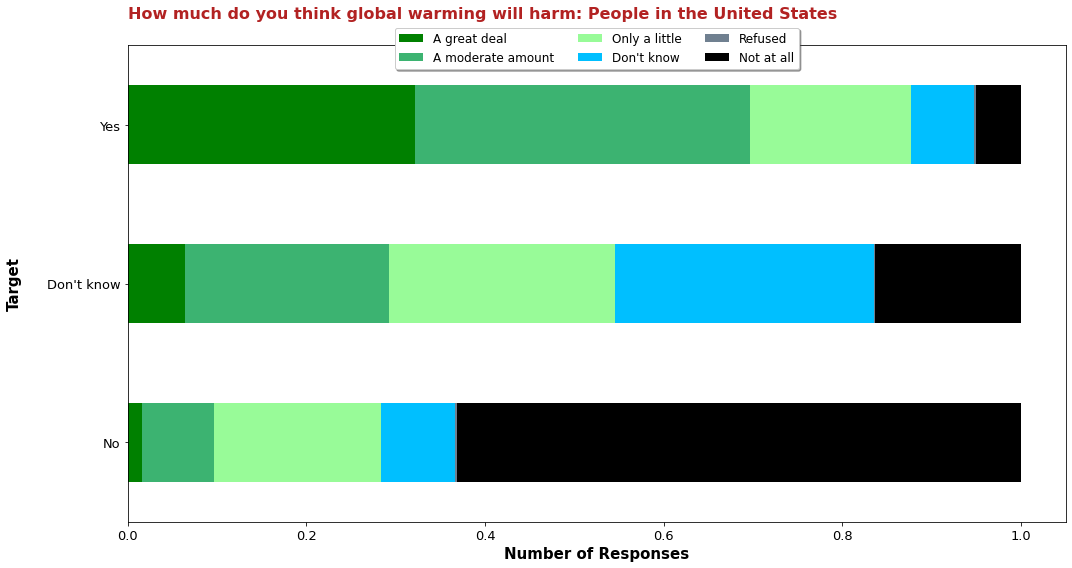

In [60]:
fig, ax = plt.subplots(figsize=(15, 8))

df.groupby('happening')['harm_US'].value_counts(normalize=True)\
  .unstack()\
  .loc[['No', "Don't know", 'Yes']].T\
  .loc[['A great deal',
        'A moderate amount',
        'Only a little',
        "Don't know",
        'Refused',
        'Not at all']].T.plot(kind='barh', 
                              ax=ax, 
                              stacked=True, 
                              fontsize=13,
                              color=['g', 
                                     'mediumseagreen', 
                                     'palegreen',
                                     'deepskyblue',
                                     'slategrey',
                                     'black'],
                              label=('1', '2'))
ax.set_title('How much do you think global warming will harm: People in the United States', 
             fontsize=16, fontweight='bold', color='firebrick', loc='left', pad=27)
ax.set_ylabel('Target', weight='bold', fontsize=15, labelpad=25)
ax.set_xlabel('Number of Responses', weight='bold', fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()

x.astype(dtype=int, errors='ignore')

---
---

**Columns with underlying Nulls due to Poll Incongruity**

Columns with questions that weren't asked in 'all waves'
- sci_consensus
- harm_plants_animals
- reg_CO2_pollutant
- reg_utilities
- reg_coal_emissions
- hear_GW_media

# Conclusions and Recommendations 

**Features Explored:**
1. wave -> OrdinalEncode
2. year -> OrdinalEncode
3. <font color=grey>weight_wave</font>
4. <font color=grey>weight_aggregate</font>
5. **happening** (target)
    - "Refused" dropped
    - created binary class column `target` ("Yes", "Not Yes")
    - OrdinalEncode fit & transformed original `happening` column
6. <font color=grey>cause_original</font>
7. <font color=grey>cause_other_text</font>
8. cause_recoded
    - final response from features 6 & 7
9. ***sci_consensus***
    - not included for one poll (2015 Oct) 1330 rows
    - interesting feature, worth imputing with KNNImputer
10. worry
    - OrdinalEncode 
11. harm_personally
12. harm_US
13. harm_dev_countries


**Data Cleaning Recommendations:**
- drop rows that "Refused" all Cause and Harm series questions 
- drop remaining 24 rows that "Refused" answering `happening`
- drop columns `weight_wave` and `weight_aggregate`
- drop column `sci_consensus`

In [62]:
# # Row/Column Drops

# print(df.shape)

# df.drop(index=df[(df.harm_personally == 'Refused') & 
#                  (df.harm_US == 'Refused') & 
#                  (df.harm_dev_countries == 'Refused') & 
#                  (df.harm_future_gen == 'Refused') & 
#                  (df.harm_plants_animals == 'Refused') 
#                 ]['target'].index, inplace=True)

# df.drop(index=df[(df.cause_original == 'Refused') &
#                  (df.cause_recoded == 'Refused') 
#                 ]['target'].index, inplace=True)

# df.drop(index=df[df.happening == "Refused"].index, inplace=True)

# df.drop(labels=['weight_wave', 'weight_aggregate'], axis=1, inplace=True) 

# df.drop(labels=['sci_consensus'], axis=1, inplace=True) 

# df.reset_index(drop=True, inplace=True)

# print(df.shape)

In [63]:
# # Manufacturing harm_personally_y_m_n by grouping original subgroups
# df['harm_personally_y_m_n'] = ['yes' if x=='A great deal' or 
#                                x=='A moderate amount' or 
#                                x=='Only a little'
#                                else 'maybe' if x=='Don\'t know'
#                                else 'no'
#                                for x in df.harm_personally]
# df['harm_personally_y_m_n'].value_counts()

In [64]:
# # Manufacturing harm_personally_y_m_n by grouping original subgroups
# df['harm_US_y_m_n'] = ['yes' if x=='A great deal' or 
#                                x=='A moderate amount' or 
#                                x=='Only a little'
#                                else 'maybe' if x=='Don\'t know'
#                                else 'no'
#                                for x in df.harm_US]
# df['harm_US_y_m_n'].value_counts()

# Larry portion

## EDA

In [65]:
def distgraph(var,title):
    fig, ax = plt.subplots(figsize=(10,8))

    ax.barh(df[var].value_counts(normalize=True).index,
              width = df[var].value_counts(normalize=True))

    # label each bar
    ax.bar_label(ax.containers[0],
                    fmt="%.3f",
                   padding = 3)

    # fluff
    ax.set_xlabel('% of Responses')
    ax.set_title(title+'\n\nDistribution',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left');

def propgraph(var,var_order,title):
    fig, ax = plt.subplots()

    df.groupby(var)['happening'].value_counts(normalize=True)\
        .unstack().loc[var_order].T\
        .loc[['No', "Don't know", 'Yes']].T\
        .plot(kind='barh', 
              figsize=(10, 8), 
              stacked=True,
              color=['slategrey', 'deepskyblue', 'palegreen'], 
              ax=ax)
    ax.set_title(title+'\n\nProportion of Belief in Climate Change',
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left')
    ax.set_ylabel(None)
    ax.legend(loc=(1.05,0.88));

#### `harm_dev_countries`
**How much do you think global warming will harm: People in developing countries**

In [66]:
list(df.harm_dev_countries.unique())

['A great deal',
 'Only a little',
 'Not at all',
 'A moderate amount',
 "Don't know",
 'Refused']

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [67]:
my_dict = {'A great deal': 'Yes',
           'Only a little': 'Yes',
           'Not at all': 'No',
           'Don\'t know': 'Don\'t know',
           'A moderate amount': 'Yes',
           'Refused': 'Refused'}

df.harm_dev_countries = df.harm_dev_countries.replace({i:j for i,j in my_dict.items()})

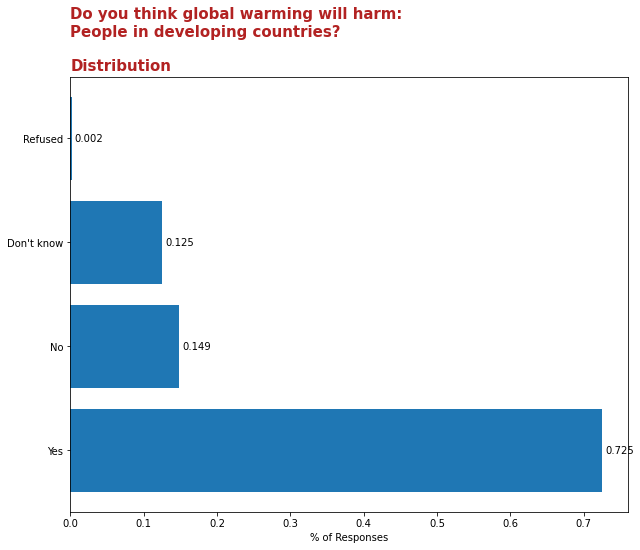

In [68]:
distgraph('harm_dev_countries',
          'Do you think global warming will harm:\n'+\
          'People in developing countries?')

**Observation**
  *  A majority of respondents (71.9%) answered Yes that global warming will harm people in developing countries.
  *  14.8% of respondents answered No
  *  Around 13.3% of respondents either did not know or refused to answer


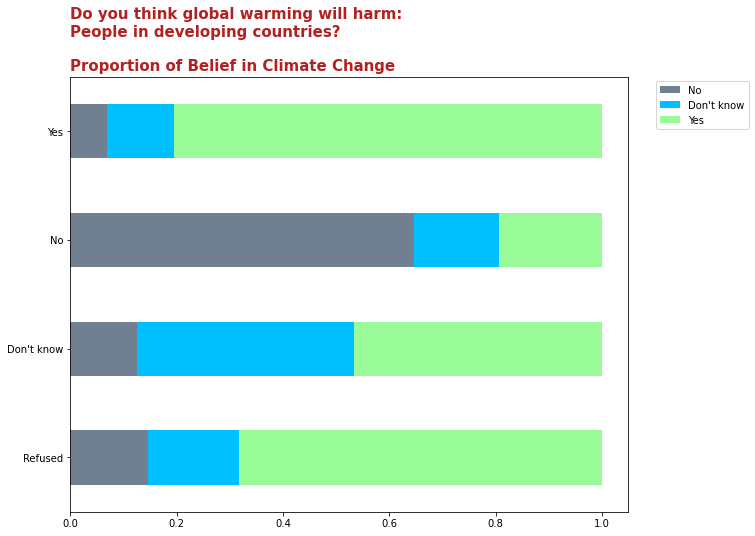

In [69]:
propgraph('harm_dev_countries',
          ['Refused','Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'People in developing countries?')


  
**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know believed in global warming or didn't know about equally.
  *  A majority of respondents for Refused believed in global warming.

#### `harm_future_gen`
**How much do you think global warming will harm: Future generations of people**

In [70]:
list(df.harm_future_gen.unique())

['A great deal',
 'A moderate amount',
 'Not at all',
 "Don't know",
 'Only a little',
 'Refused']

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [71]:
df.harm_future_gen = df.harm_future_gen.replace({i:j for i,j in my_dict.items()})

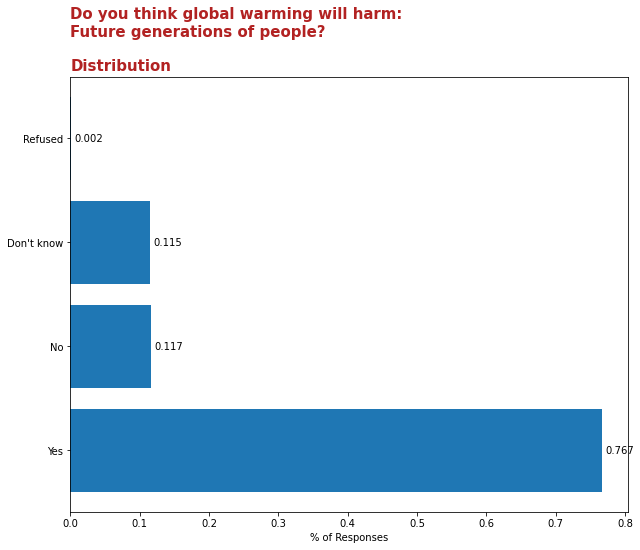

In [72]:
distgraph('harm_future_gen',
          'Do you think global warming will harm:\n'+\
          'Future generations of people?')

**Observation**
  *  A majority of respondents (76.0%) answered Yes that global warming will harm future generations of people.
  *  11.9% of respondents answered No
  *  Around 12.1% of respondents either did not know or refused to answer


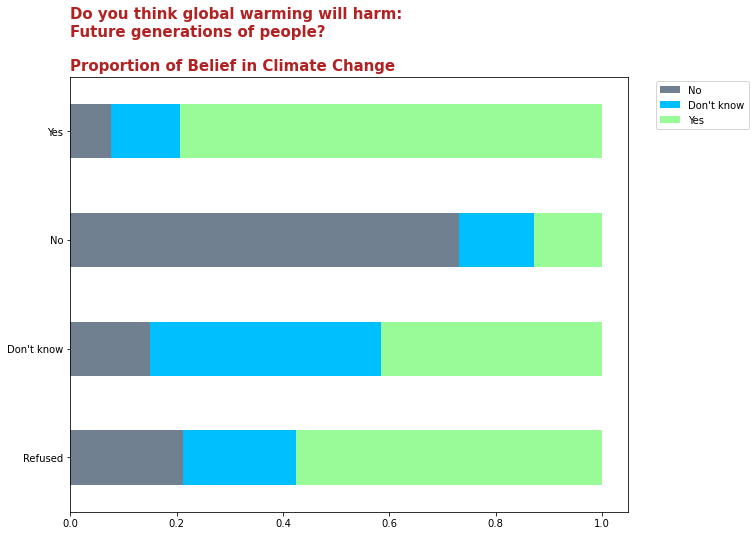

In [73]:
propgraph('harm_future_gen',
          ['Refused','Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'Future generations of people?')

**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know believed in global warming or didn't know about equally.
  *  A majority of respondents for Refused believed in global warming.

#### `harm_plants_animals`
**How much do you think global warming will harm: Plant and animal species**

In [74]:
df.harm_plants_animals.isnull().sum() / df.shape[0]

0.059366995975118915

6% of respondents were not offered this question as it was not asked in Oct 2015. These will need to be imputed.

In [75]:
list(df.harm_plants_animals.unique())

['A great deal',
 'A moderate amount',
 'Not at all',
 "Don't know",
 'Only a little',
 'Refused',
 nan]

The response options. Map these to Refused, Don't Know, No, and Yes for more absolute groupings.

In [76]:
df.harm_plants_animals = df.harm_plants_animals.replace({i:j for i,j in my_dict.items()})

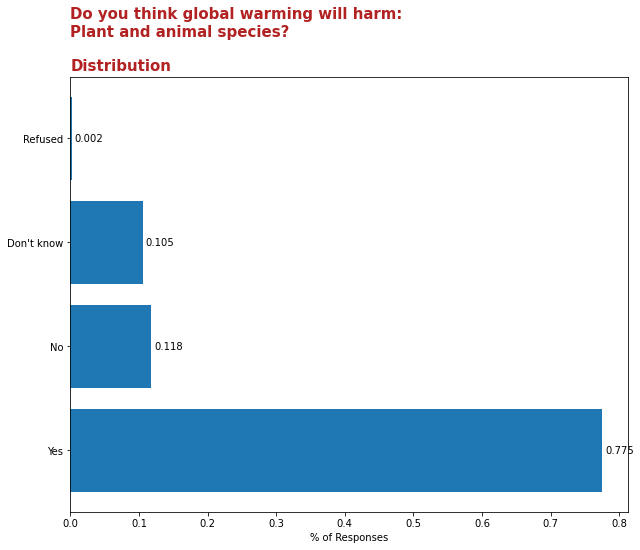

In [77]:
distgraph('harm_plants_animals',
          'Do you think global warming will harm:\n'+\
          'Plant and animal species?')

**Observation**
  *  A majority of respondents (76.8%) answered Yes that global warming will harm plants and animals.
  *  11.7% of respondents answered No
  *  Around 11.4% of respondents either did not know or refused to answer

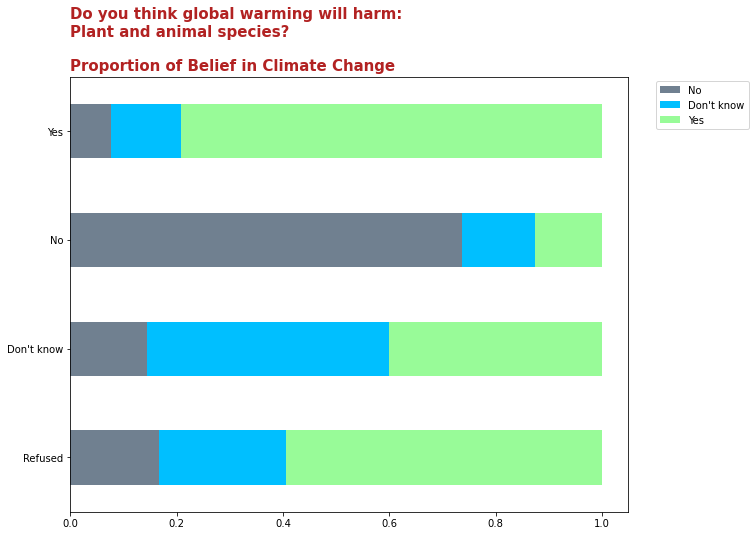

In [78]:
propgraph('harm_plants_animals',
          ['Refused','Don\'t know', 'No','Yes'],
          'Do you think global warming will harm:\n'+\
          'Plant and animal species?')

**Observation**
  *  Respondents for Yes believed in global warming by a large margin.
  *  Respondents for No, on the other hand, did not believe in global warming by a large margin.
  *  Respondents for Don't Know didn't know if they believe in global warming, closely followed by Yes.
  *  A majority of respondents for Refused believed in global warming.

#### `when_harm_us`
**When do you think global warming will start to harm people in the United States?**

In [79]:
list(df.when_harm_US.unique())

['In 10 years',
 'In 50 years',
 'Never',
 'In 25 years',
 'In 100 years',
 'They are being harmed now',
 'Refused']

The response options. Map these to Refused, Never, In the Future, and Now for more absolute groupings.

In [80]:
my_dict = {'In 10 years': 'In the Future',
           'In 50 years': 'In the Future',
           'Never': 'Never',
           'In 25 years': 'In the Future',
           'In 100 years': 'In the Future',
           'They are being harmed now': 'Now',
           'Refused': 'Refused'}

df.when_harm_US = df.when_harm_US.replace({i:j for i,j in my_dict.items()})

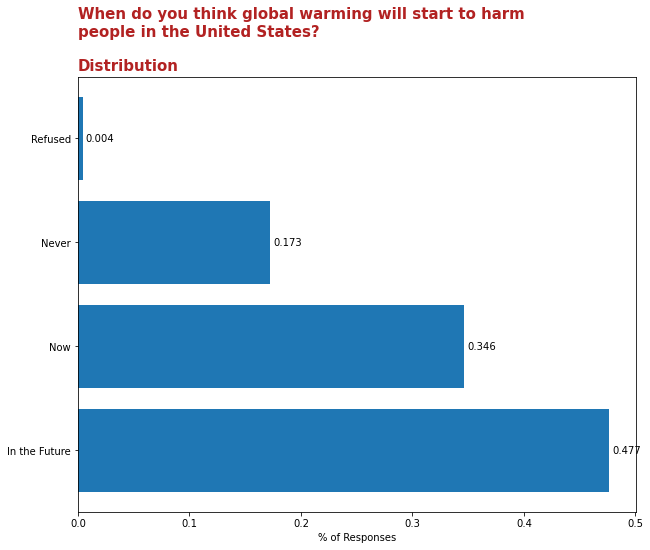

In [81]:
distgraph('when_harm_US',
          'When do you think global warming will start to harm\npeople '+\
          'in the United States?')

**Observation**
  *  A plurality of respondents (47.5%) answered `In the Future` for when global warming will start to harm people in the United States.
  *  34.5% of respondents answered `Now`
  *  17.3% of respondents answer `Never`

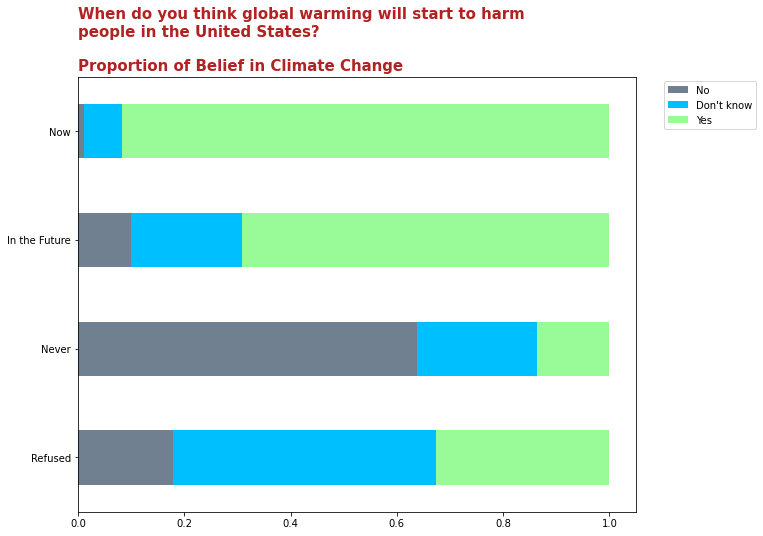

In [82]:
propgraph('when_harm_US',
          ['Refused','Never', 'In the Future','Now'],
          'When do you think global warming will start to harm\npeople '+\
          'in the United States?')

**Observation**
  *  Unsurprisingly, `Now` and `In the Future` both believe in global warming by a large margin
  *  Respondents for `Never` still held decent amounts of Don't Know and Yes for belief in global warming indicating that global warming may not be inherently harmful in their mind.

#### `reg_CO2_pollutant`
**How much do you support or oppose the following policies?
Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.**

In [83]:
df.reg_CO2_pollutant.isnull().sum()/df.shape[0]

0.04349615806805708

4.5% of respondents were not offered this question as it was not asked in May 2011. These will need to be imputed.

In [84]:
list(df.reg_CO2_pollutant.unique())

['Strongly support',
 'Somewhat support',
 'Somewhat oppose',
 'Strongly oppose',
 'Refused',
 nan]

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [85]:
my_dict = {'Strongly support': 'Support',
           'Somewhat support': 'Support',
           'Somewhat oppose': 'Oppose',
           'Strongly oppose': 'Oppose',
           'Refused': 'Refused'}

df.reg_CO2_pollutant = df.reg_CO2_pollutant.replace({i:j for i,j in my_dict.items()})

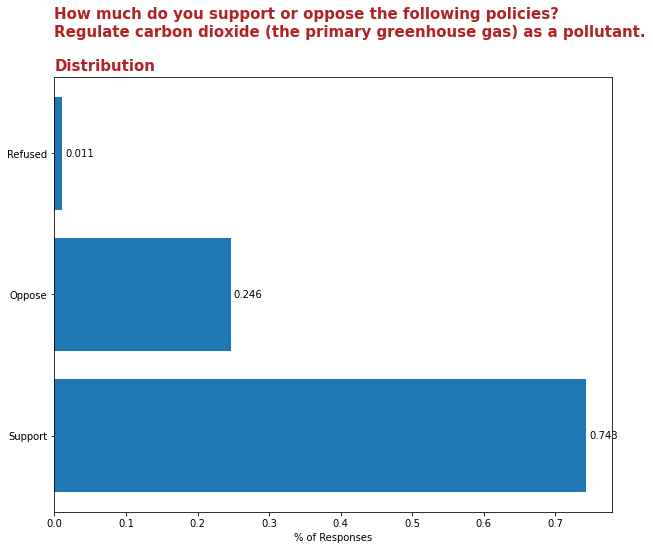

In [86]:
distgraph('reg_CO2_pollutant',
          'How much do you support or oppose the following policies?\n'+\
          'Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.')

**Observation**
  *  A majority of respondents (73.2%) support regulating carbon dioxide.
  *  24.4% of respondents answered No
  *  Around 2.4% of respondents either did not know or refused to answer

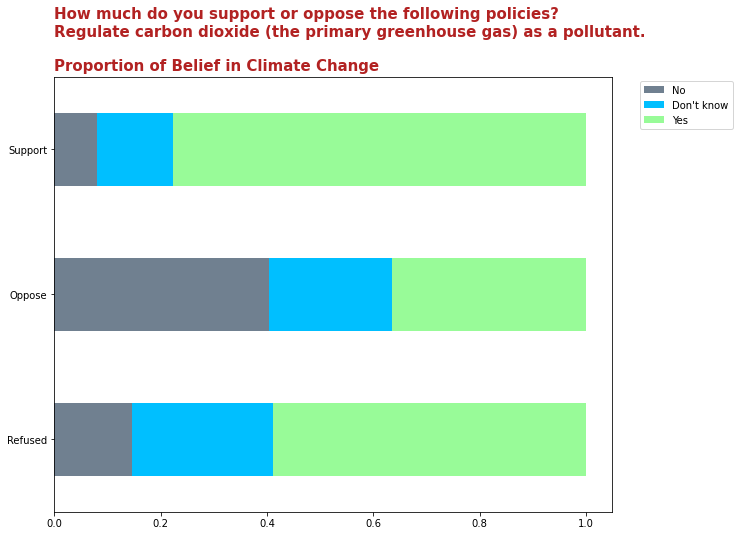

In [87]:
propgraph('reg_CO2_pollutant',
          ['Refused','Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Regulate carbon dioxide (the primary greenhouse gas) as a pollutant.')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `reg_utilities`
**How much do you support or oppose the following policies? Require electric utilities to produce at least 20% of their electricity from wind, solar, or other renewable energy sources, even if it costs the average household an extra $100 a year.**

In [88]:
df.reg_utilities.isnull().sum() / df.shape[0]

0.22685693377241126

22.5% of respondents were not offered this question as it was not asked in Oct 2015, Mar and Nov 2016, and May 2017. These will need to be imputed.

In [89]:
list(df.reg_utilities .unique())

['Strongly support',
 'Somewhat support',
 'Strongly oppose',
 'Somewhat oppose',
 'Refused',
 nan]

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [90]:
df.reg_utilities = df.reg_utilities.replace({i:j for i,j in my_dict.items()})

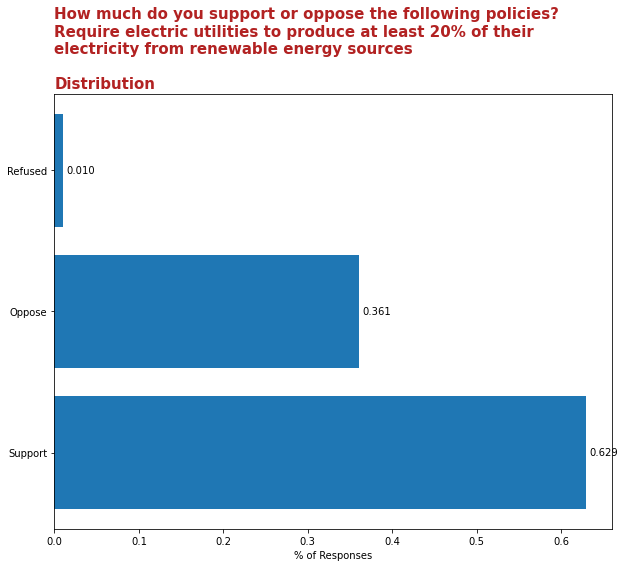

In [91]:
distgraph('reg_utilities',
          'How much do you support or oppose the following policies?\n'+\
          'Require electric utilities to produce at least 20% of their\n'+\
          'electricity from renewable energy sources')

**Observation**
  *  A majority of respondents (61.9%) support requiring electric utilities to produce at least 20% renewable energy.
  *  35.5% of respondents answered No
  *  Around 2.6% of respondents either did not know or refused to answer

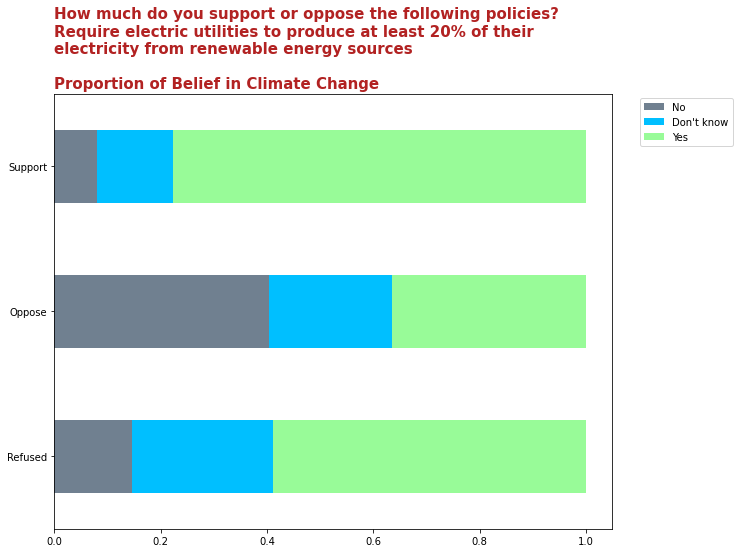

In [92]:
propgraph('reg_CO2_pollutant',
          ['Refused','Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Require electric utilities to produce at least 20% of their\n'+\
          'electricity from renewable energy sources')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `fund_research`
**How much do you support or oppose the following policies? Fund more research into renewable energy sources, such as solar and wind power.**

In [93]:
list(df.fund_research .unique())

['Strongly support',
 'Somewhat support',
 'Strongly oppose',
 'Somewhat oppose',
 'Refused']

The response options. Map these into support, oppose, and refused for more absolute groupings.

In [94]:
df.fund_research = df.fund_research.replace({i:j for i,j in my_dict.items()})

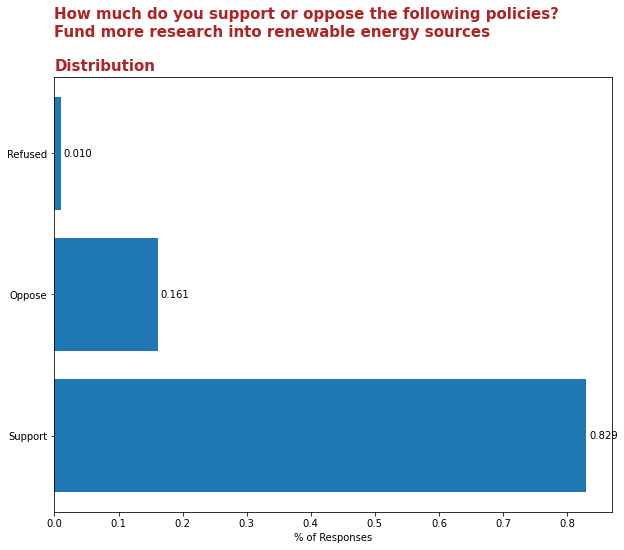

In [95]:
distgraph('fund_research',
          'How much do you support or oppose the following policies?\n'+\
          'Fund more research into renewable energy sources')

**Observation**
  *  A majority of respondents (81.8%) support funding more research into renewable energy sources.
  *  16.0% of respondents answered No
  *  Around 2.2% of respondents refused to answer

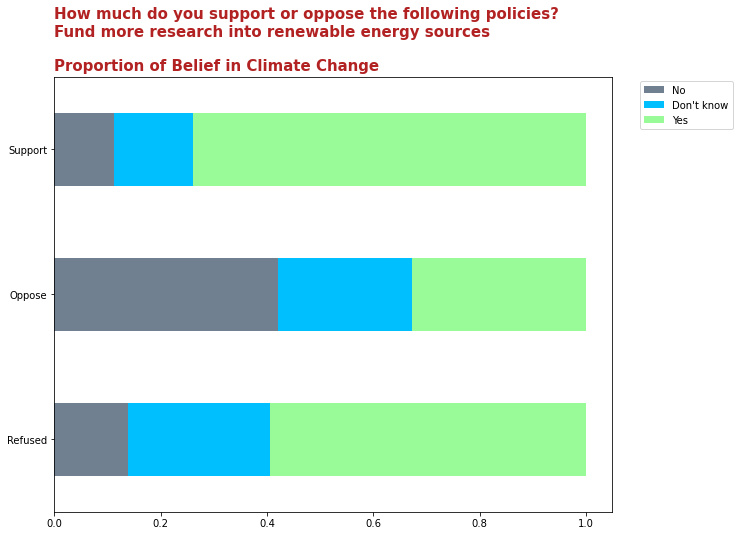

In [96]:
propgraph('fund_research',
          ['Refused','Oppose','Support'],
          'How much do you support or oppose the following policies?\n'+\
          'Fund more research into renewable energy sources')

**Observation**
  *  `Oppose` is not as deeply for not believing in climate change as `Support` is for believing in climate change.

#### `reg_coal_emissions`
**How much do you support or oppose the following policy? Set strict carbon dioxide emission limits on existing coal-fired power plants to reduce global warming and improve public health. Power plants would have to reduce their emissions and/or invest in renewable energy and energy efficiency. The cost of electricity to consumers and companies would likely increase**

In [97]:
df.reg_coal_emissions.isnull().sum() / df.shape[0]

0.39832601536772777

40.4% of respondents were not offered this question as it was not asked between 2008 and 2012, and Nov 2013.

Because of this high amount of missingness, drop the column.

In [98]:
df.drop('reg_coal_emissions', axis = 1, inplace=True)

#### `discuss_GW`
**How often do you discuss global warming with your family and friends?**

In [99]:
list(df.discuss_GW.unique())

['Occasionally', 'Rarely', 'Never', 'Often', 'Refused']

The response options. Map these to Refused, Never, At All for more absolute groupings

In [100]:
my_dict = {'Occasionally': 'At All',
           'Rarely': 'At All',
           'Never': 'Never',
           'Often': 'At All',
           'Refused': 'Refused'}

df.discuss_GW = df.discuss_GW.replace({i:j for i,j in my_dict.items()})

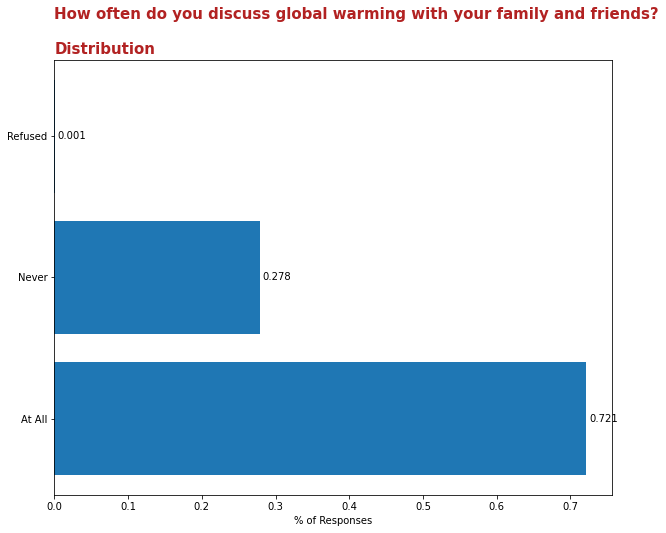

In [101]:
distgraph('discuss_GW',
          'How often do you discuss global warming with your family and friends?')

**Observation**
  *  A majority of respondents discuss global warming with family and friends

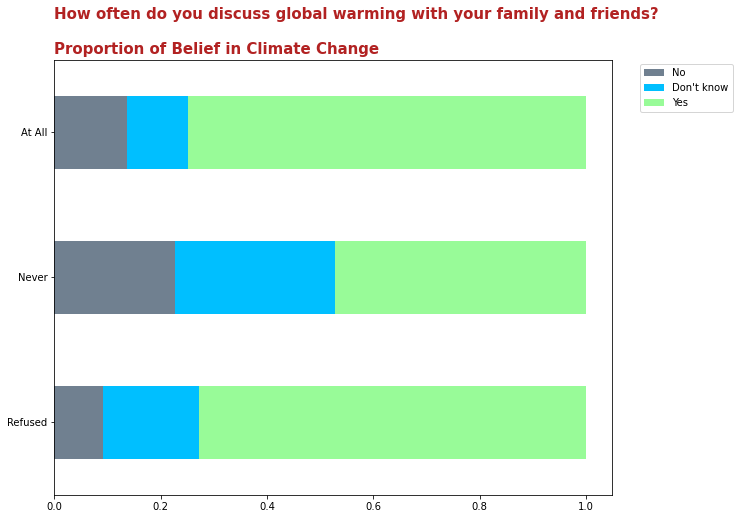

In [102]:
propgraph('discuss_GW',
          ['Refused','Never','At All'],
          'How often do you discuss global warming with your family and friends?')

**Observation**
  *  Despite `Never` discussing global warming with family and friends, that group of respondents still believes in global warming on average along with `At All`

#### `hear_GW_media`
**About how often do you hear about global warming in the media (TV, movies, radio, newspapers/news websites, magazines, etc.)?**

In [103]:
df.hear_GW_media.isnull().sum() / df.shape[0]

0.6036864251738017

60.8% of respondents were not offered this question as it was not asked between 2008 and 2014, and Nov 2016.

Because of this high amount of missingness, drop the column.

In [104]:
df.drop('hear_GW_media', axis = 1, inplace=True)

#### `gender`
**Are you Male or Female?**

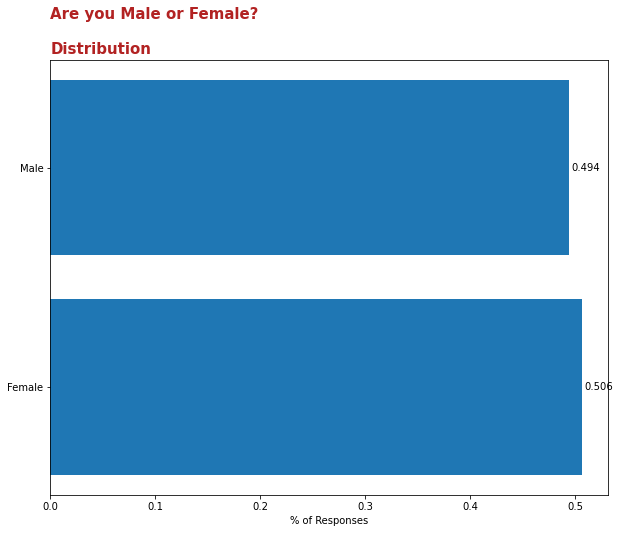

In [105]:
distgraph('gender',
          'Are you Male or Female?')

**Observation**
  *  The distribution of responses is very close to even with `female` representing a majority of responses at 50.8%

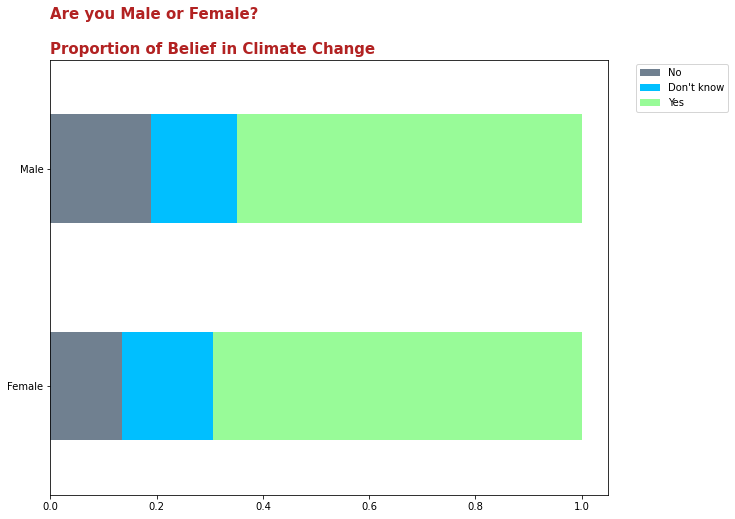

In [106]:
propgraph('gender',
          ['Female','Male'],
          'Are you Male or Female?')

**Observation**
  *  `Female` respondents believed in global warming more than `Male` respondents.

In [107]:
# dummify gender to be 0 for male and 1 for female
df.gender = [int(val == 'Female') for val in df.gender]

#### `age`
**How old are you?**

In [108]:
df.age.describe()

count    21864.000000
mean        50.581641
std         16.772576
min         18.000000
25%         37.000000
50%         52.000000
75%         64.000000
max         97.000000
Name: age, dtype: float64

The range of responses was 18-97 meaning only responses from adults were recorded. The average age was 50 years old.

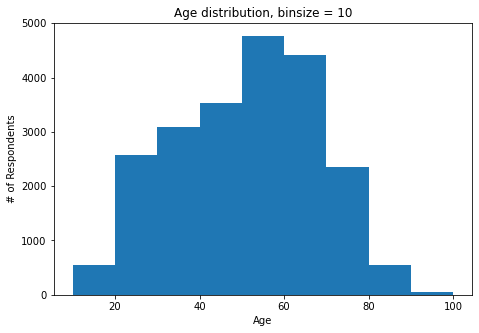

In [109]:
fig, ax = plt.subplots(1, 1, figsize = (7.5,5))
ax.hist(df.age,
        bins = np.arange(10,101,10))
ax.set_title('Age distribution, binsize = 10')
ax.set_ylabel('# of Respondents')
ax.set_xlabel('Age');

**Observation**
  *  The age distribution is centered around 50, which is also the mean and contains the median value 52.
  *  Right tailed with small amount of respondents in the 90-100 range.
  *  High number of young respondents also making it more skewed.

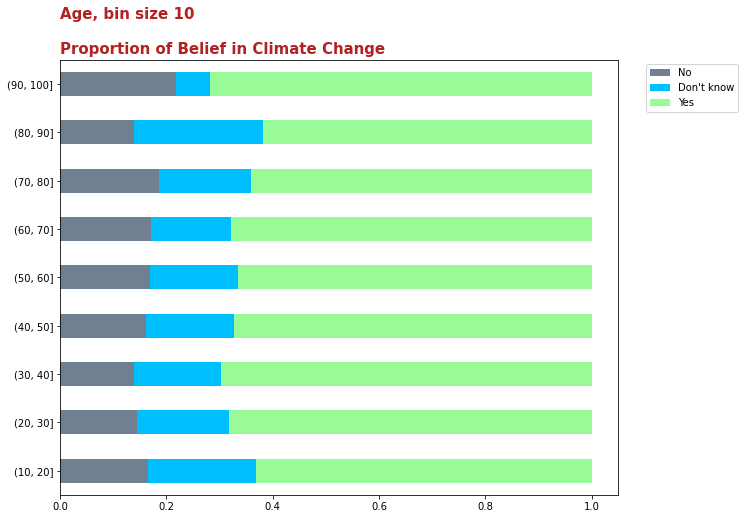

In [110]:
# graph

propgraph(pd.cut(df.age, bins = np.arange(10,101,10)),
          [pd.Interval(10, 20, closed='right'),
           pd.Interval(20, 30, closed='right'),
           pd.Interval(30, 40, closed='right'),
           pd.Interval(40, 50, closed='right'),
           pd.Interval(50, 60, closed='right'),
           pd.Interval(60, 70, closed='right'),
           pd.Interval(70, 80, closed='right'),
           pd.Interval(80, 90, closed='right'),
           pd.Interval(90, 100, closed='right')],
          "Age, bin size 10")

**Observations**
  *  Each age group has a majority of respondents believing in global warming
  *  `20-30` and `30-40` are some of the strongest believers on average
  *  `50-60` was the most popular age bracket for the survey and is one of the softer groups for believing in climate change.

#### `age_category`
**Computed from `age` as a range**

In [111]:
list(df.age_category.unique())

['55+ years', '35-54 years', '18-34 years']

The computed ranges.

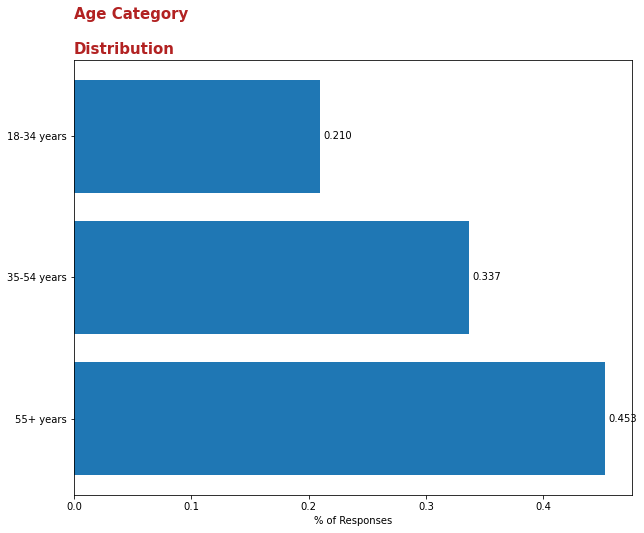

In [112]:
distgraph('age_category',
          'Age Category')

**Observation**
  *  A plurality of respondents are in the 55+ category
  *  The youngest age group is the least represented in the survey

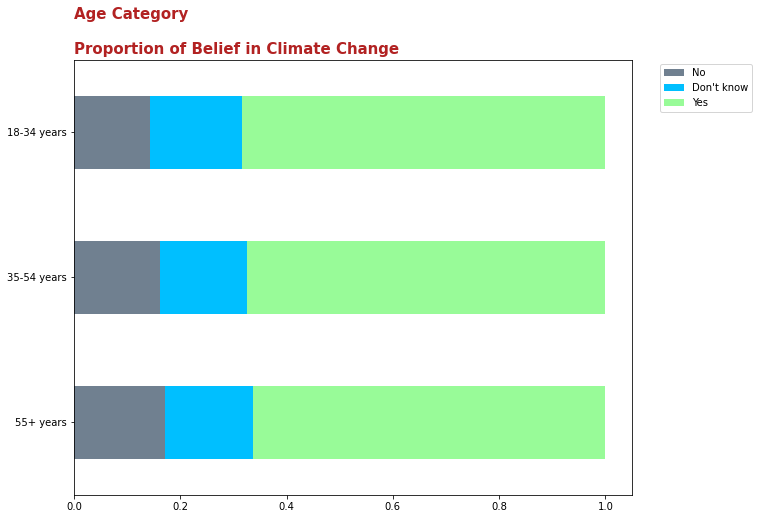

In [113]:
propgraph('age_category',
          ['55+ years','35-54 years','18-34 years'],
          'Age Category')

**Observation**
  *  All three age categories have similar belief proportions.

In [114]:
# dummify age_category and drop 18-34 years as an option
df = df.join(pd.get_dummies(df.age_category, prefix='age_category', 
                            drop_first=True))

# rename the new dummy columns to represent their value
df.rename(columns = {df.columns[-2]:'age_category_35_54', 
                     df.columns[-1]: 'age_category_55_plus'}, 
          inplace=True)

#drop age_category
df.drop('age_category', axis=1, inplace=True)

# VILO

### Dummifying values to do some initial EDA

In [115]:
dum_happen = pd.get_dummies(df['happening'])

### Taking a look at the features below


In [116]:
df2 = df[['generation', 'educ', 'educ_category', 'income', 'income_category',
          'race', 'ideology', 'party', 'party_w_leaners', 'party_x_ideo',
          'registered_voter', 'region9', 'region4']]

In [117]:
df2.describe()

generation  \
count                        21864   
unique                           6   
top     Baby Boomers (1946 - 1964)   
freq                          8973   

                                                     educ  \
count                                               21864   
unique                                                 14   
top     High school graduate - high school diploma or ...   
freq                                                 6126   

                      educ_category                income    income_category  \
count                         21864                 21864              21864   
unique                            4                    21                  3   
top     Bachelor's degree or higher  $100,000 to $124,999  Less than $50,000   
freq                           7590                  2528               8522   

                       race                      ideology     party  \
count                 21864                         21864     21864   
unique                    4                             6         6   
top     White, Non-Hispanic  Moderate, middle of the road  Democrat   
freq                  16464                          8706      7320   

       party_w_leaners             party_x_ideo registered_voter  \
count            21864                    21864            21864   
unique               5                        7                6   
top          Democrats  Conservative Republican       Registered   
freq              9147                     5448            18556   

               region9 region4  
count            21864   21864  
unique               9       4  
top     South Atlantic   South  
freq              4234    7678

### Checking the null values

In [118]:
df2.isnull().sum()

generation          0
educ                0
educ_category       0
income              0
income_category     0
race                0
ideology            0
party               0
party_w_leaners     0
party_x_ideo        0
registered_voter    0
region9             0
region4             0
dtype: int64

### Creating Dummies from the features

In [119]:
df2_dum = pd.get_dummies(df2)

In [120]:
df2_dum.head()

generation_Baby Boomers (1946 - 1964)  \
0                                      0   
1                                      1   
2                                      1   
3                                      0   
4                                      0   

   generation_Generation X (1965 - 1980)  generation_Greatest (Before 1928)  \
0                                      0                                  0   
1                                      0                                  0   
2                                      0                                  0   
3                                      0                                  0   
4                                      0                                  0   

   generation_Millennials (1981 - 1996)  generation_Silent (1928 - 1945)  \
0                                     0                                1   
1                                     0                                0   
2                                     0                                0   
3                                     0                                1   
4                                     1                                0   

   generation_iGen‎/Gen Z (1997 - )  educ_10th grade  educ_11th grade  \
0                                 0                0                0   
1                                 0                1                0   
2                                 0                0                0   
3                                 0                0                0   
4                                 0                0                0   

   educ_12th grade no diploma  educ_1st, 2nd, 3rd, or 4th grade  ...  \
0                           0                                 0  ...   
1                           0                                 0  ...   
2                           0                                 0  ...   
3                           0                                 0  ...   
4                           0                                 0  ...   

   region9_Mountain  region9_New England  region9_Pacific  \
0                 0                    0                0   
1                 0                    0                0   
2                 1                    0                0   
3                 0                    0                0   
4                 0                    0                0   

   region9_South Atlantic  region9_West-North Central  \
0                       1                           0   
1                       0                           0   
2                       0                           0   
3                       1                           0   
4                       0                           0   

   region9_West-South Central  region4_Midwest  region4_Northeast  \
0                           0                0                  0   
1                           0                1                  0   
2                           0                0                  0   
3                           0                0                  0   
4                           0                0                  0   

   region4_South  region4_West  
0              1             0  
1              0             0  
2              0             1  
3              1             0  
4              1             0  

[5 rows x 95 columns]

In [121]:
df2.shape

(21864, 13)

In [122]:
dummies = pd.concat([df2_dum, dum_happen], axis=1)

### I am looking at the breakdown of people who answered Yes vs Not yes for if global warming is happening

In [123]:
dummies.groupby(['Yes']).mean()

generation_Baby Boomers (1946 - 1964)  \
Yes                                          
0                                 0.406489   
1                                 0.412314   

     generation_Generation X (1965 - 1980)  generation_Greatest (Before 1928)  \
Yes                                                                             
0                                 0.237711                           0.008355   
1                                 0.242253                           0.006130   

     generation_Millennials (1981 - 1996)  generation_Silent (1928 - 1945)  \
Yes                                                                          
0                                0.173374                         0.162930   
1                                0.185861                         0.140026   

     generation_iGen‎/Gen Z (1997 - )  educ_10th grade  educ_11th grade  \
Yes                                                                       
0                            0.011141         0.017129         0.021724   
1                            0.013417         0.013008         0.018525   

     educ_12th grade no diploma  educ_1st, 2nd, 3rd, or 4th grade  ...  \
Yes                                                                ...   
0                      0.024648                          0.000836  ...   
1                      0.020432                          0.001703  ...   

     region9_Pacific  region9_South Atlantic  region9_West-North Central  \
Yes                                                                        
0           0.130901                0.193149                    0.082022   
1           0.164204                0.193898                    0.074712   

     region9_West-South Central  region4_Midwest  region4_Northeast  \
Yes                                                                   
0                      0.109595         0.252054           0.164044   
1                      0.098890         0.229858           0.192604   

     region4_South  region4_West  Don't know        No  
Yes                                                     
0         0.374460      0.209442    0.507032  0.492968  
1         0.339781      0.237758    0.000000  0.000000  

[2 rows x 97 columns]

In [124]:
dummies.corr()

generation_Baby Boomers (1946 - 1964)  \
generation_Baby Boomers (1946 - 1964)                               1.000000   
generation_Generation X (1965 - 1980)                              -0.469818   
generation_Greatest (Before 1928)                                  -0.069343   
generation_Millennials (1981 - 1996)                               -0.393219   
generation_Silent (1928 - 1945)                                    -0.347103   
...                                                                      ...   
region4_South                                                      -0.007413   
region4_West                                                       -0.028115   
Don't know                                                         -0.023277   
No                                                                  0.016452   
Yes                                                                 0.005561   

                                       generation_Generation X (1965 - 1980)  \
generation_Baby Boomers (1946 - 1964)                              -0.469818   
generation_Generation X (1965 - 1980)                               1.000000   
generation_Greatest (Before 1928)                                  -0.046804   
generation_Millennials (1981 - 1996)                               -0.265407   
generation_Silent (1928 - 1945)                                    -0.234281   
...                                                                      ...   
region4_South                                                       0.004804   
region4_West                                                        0.010803   
Don't know                                                          0.000973   
No                                                                 -0.007346   
Yes                                                                 0.004990   

                                       generation_Greatest (Before 1928)  \
generation_Baby Boomers (1946 - 1964)                          -0.069343   
generation_Generation X (1965 - 1980)                          -0.046804   
generation_Greatest (Before 1928)                               1.000000   
generation_Millennials (1981 - 1996)                           -0.039173   
generation_Silent (1928 - 1945)                                -0.034579   
...                                                                  ...   
region4_South                                                  -0.001945   
region4_West                                                    0.004925   
Don't know                                                      0.013416   
No                                                              0.002577   
Yes                                                            -0.012664   

                                       generation_Millennials (1981 - 1996)  \
generation_Baby Boomers (1946 - 1964)                             -0.393219   
generation_Generation X (1965 - 1980)                             -0.265407   
generation_Greatest (Before 1928)                                 -0.039173   
generation_Millennials (1981 - 1996)                               1.000000   
generation_Silent (1928 - 1945)                                   -0.196084   
...                                                                     ...   
region4_South                                                      0.003589   
region4_West                                                       0.018675   
Don't know                                                         0.007708   
No                                                                -0.027183   
Yes                                                                0.015207   

                                       generation_Silent (1928 - 1945)  \
generation_Baby Boomers (1946 - 1964)                        -0.347103   
generation_Generation X (1965 - 1980)                        -0.234281   
generation_Greatest (Before 1928)

In [125]:
top_corr1 = pd.DataFrame(dummies.corr().sort_values(by='Yes', ascending=False)['Yes'][:20])

### Looking at the top positive correlated features with answering yes to 'happening'

In [126]:
top_corr1

Yes
Yes                                          1.000000
party_w_leaners_Democrats                    0.359949
party_Democrat                               0.287088
party_x_ideo_Liberal Democrat                0.281264
ideology_Somewhat liberal                    0.218081
party_x_ideo_Moderate/Conservative Democrat  0.156071
ideology_Very liberal                        0.132292
educ_category_Bachelor's degree or higher    0.099799
ideology_Moderate, middle of the road        0.090000
educ_Master's degree                         0.067218
educ_Professional or Doctorate degree        0.054676
race_Hispanic                                0.046324
region9_Pacific                              0.043416
race_Black, Non-Hispanic                     0.042436
educ_Bachelor's degree                       0.040153
income_category_$100,000 or more             0.036337
region4_Northeast                            0.034672
race_Other, Non-Hispanic                     0.034064
region4_West                                 0.031676
region9_Mid-Atlantic                         0.028419

In [127]:
top_corr_neg = pd.DataFrame(dummies.corr().sort_values(by='Yes')['Yes'][:20])

### The top negative correlated features for answering yes to 'happening'

In [128]:
top_corr_neg

Yes
Don't know                                         -0.639168
No                                                 -0.628502
party_x_ideo_Conservative Republican               -0.340580
party_w_leaners_Republicans                        -0.321990
ideology_Very conservative                         -0.268565
party_Republican                                   -0.262279
ideology_Somewhat conservative                     -0.184138
race_White, Non-Hispanic                           -0.078715
educ_category_High school                          -0.065485
educ_High school graduate - high school diploma... -0.065485
party_Other; Please specify:                       -0.052248
region9_East-South Central                         -0.050883
party_x_ideo_No Party/Not Interested in politics   -0.046762
party_w_leaners_No party/Not interested in poli... -0.046762
party_No party/not interested in politics          -0.046762
registered_voter_Don't know                        -0.038355
region4_South                                      -0.034121
generation_Silent (1928 - 1945)                    -0.030331
registered_voter_Prefer not to answer              -0.029048
educ_category_Less than high school                -0.029041

''

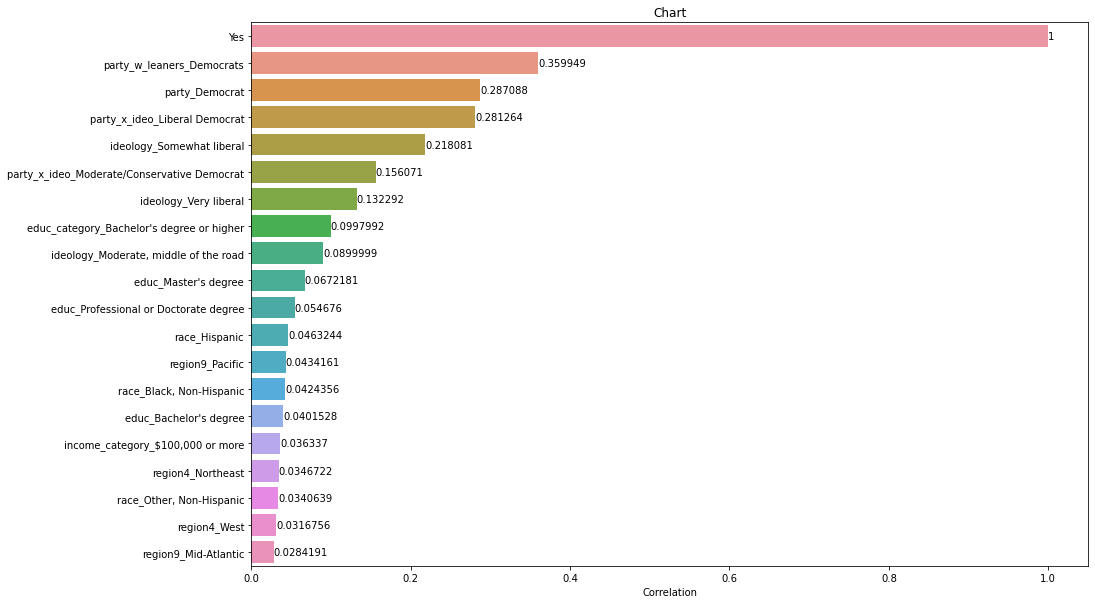

In [129]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x='Yes', y=top_corr1.index, data=top_corr1, orient='h')
ax.set_xlabel('Correlation')
ax.set_title('Chart')
for i in ax.containers:
    ax.bar_label(i)
;

''

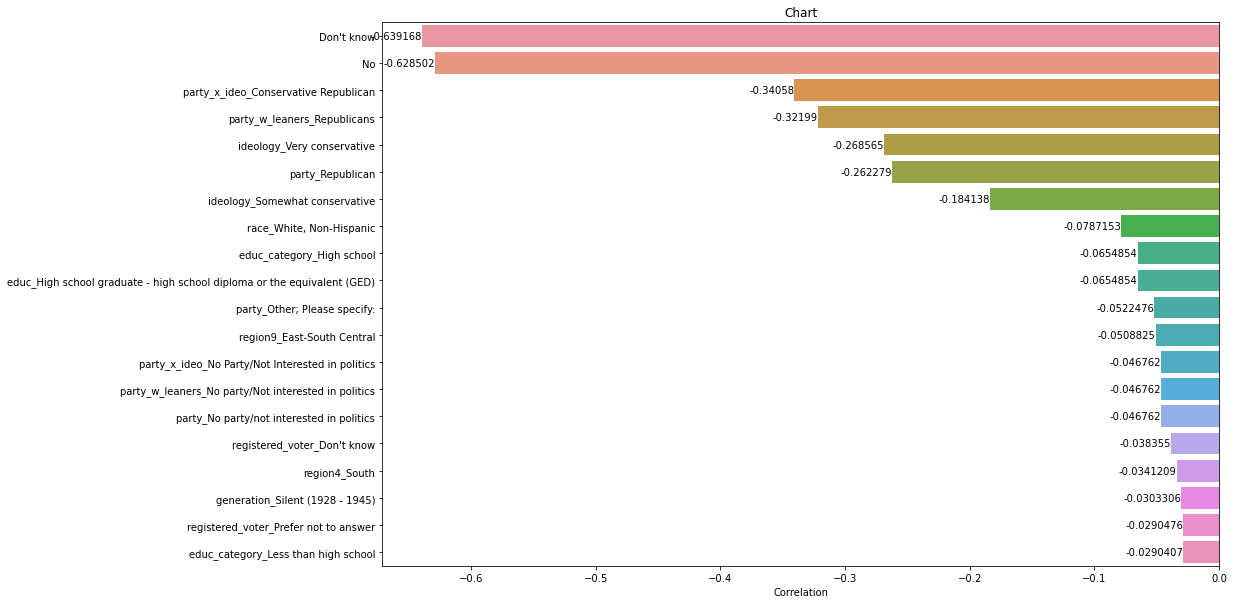

In [130]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x='Yes', y=top_corr_neg.index, data=top_corr_neg)
ax.set_xlabel('Correlation')
ax.set_title('Chart')
for i in ax.containers:
    ax.bar_label(i)
;

### A rough correlation heat map between features

<AxesSubplot:>

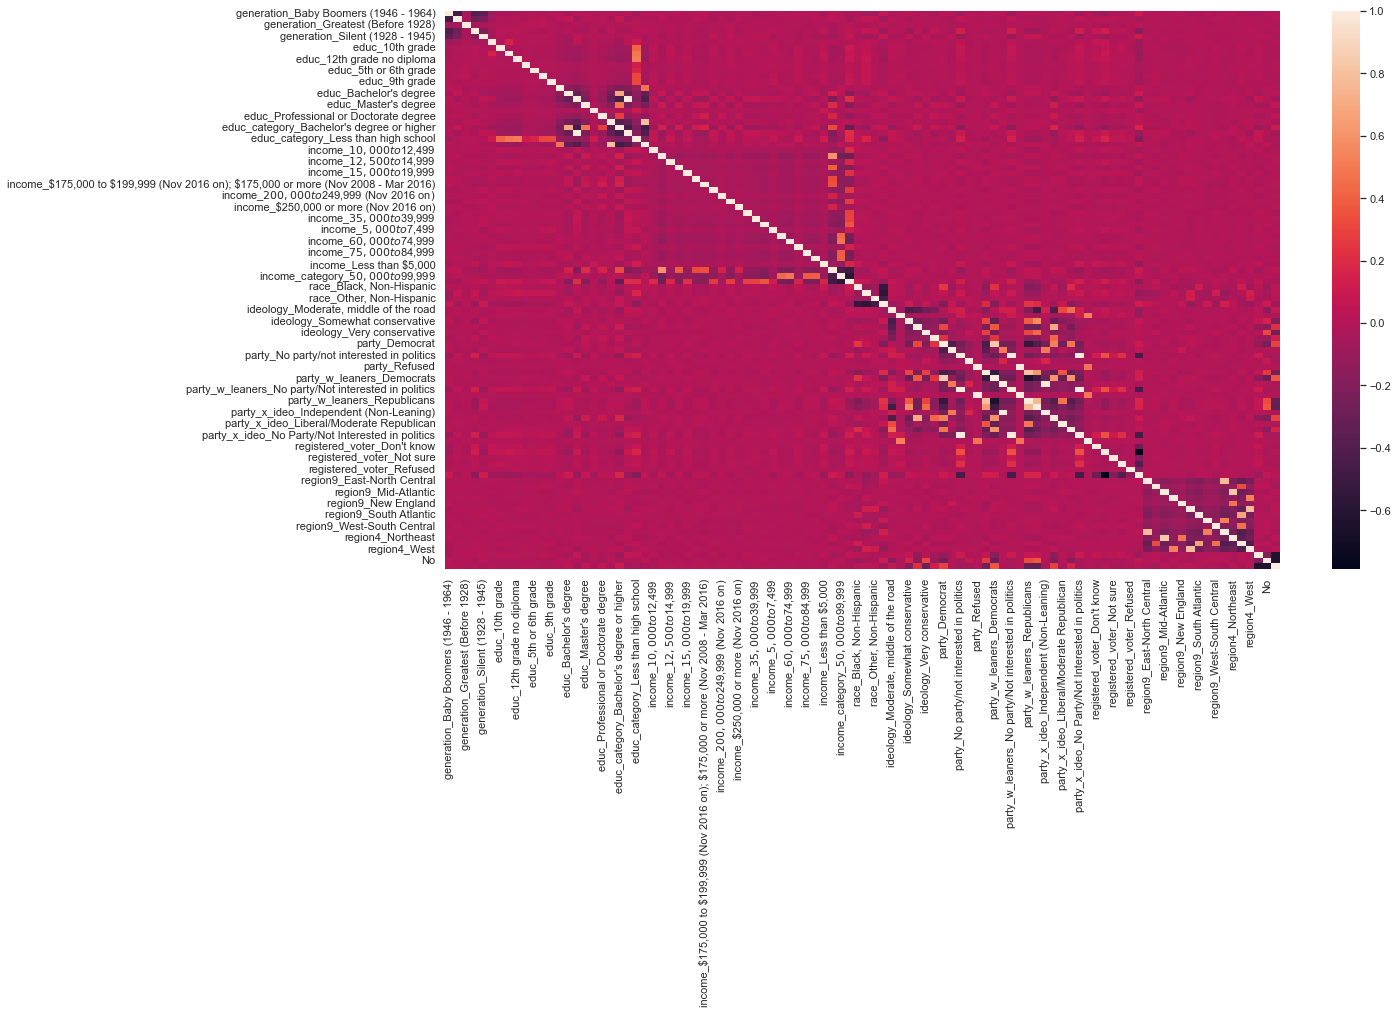

In [131]:
sns.set(rc={'figure.figsize':(18.7,10.27)})
sns.heatmap(dummies.corr())

### Checking distribution of all features

In [132]:
df2['generation'].value_counts(normalize=True)

Baby Boomers (1946 - 1964)    0.410401
Generation X (1965 - 1980)    0.240761
Millennials (1981 - 1996)     0.181760
Silent (1928 - 1945)          0.147548
iGen‎/Gen Z (1997 - )         0.012669
Greatest (Before 1928)        0.006861
Name: generation, dtype: float64

<AxesSubplot:xlabel='generation', ylabel='Count'>

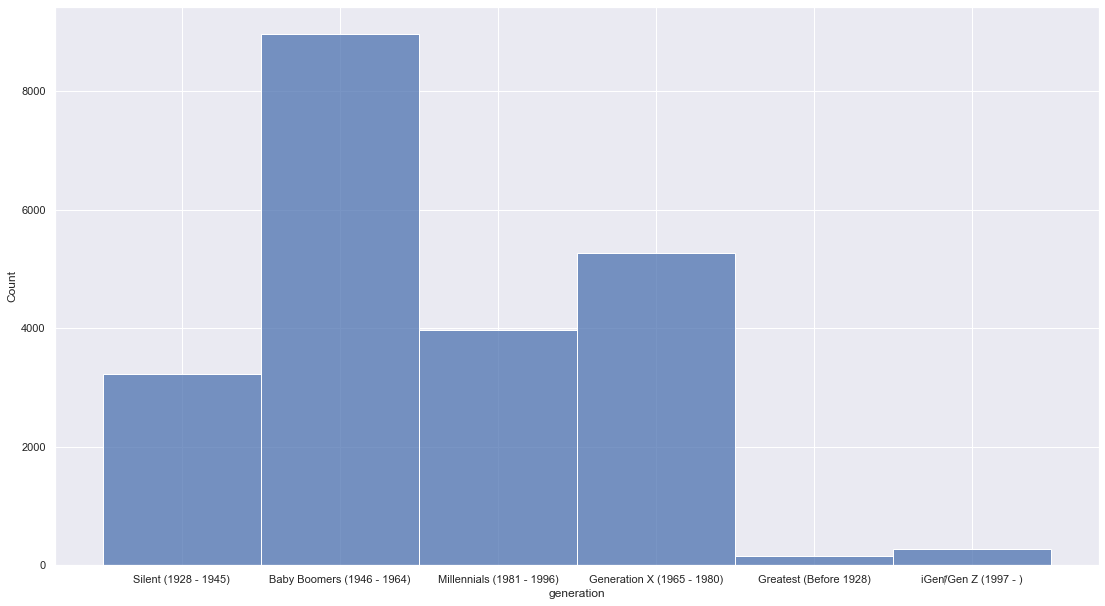

In [133]:
sns.histplot(data=df2, x = 'generation')

In [134]:
df2['educ'].value_counts(normalize=True)

High school graduate - high school diploma or the equivalent (GED)    0.280187
Some college, no degree                                               0.207647
Bachelor's degree                                                     0.200832
Master's degree                                                       0.106522
Associate's degree                                                    0.087816
Professional or Doctorate degree                                      0.039791
12th grade no diploma                                                 0.021817
11th grade                                                            0.019576
10th grade                                                            0.014362
9th grade                                                             0.008507
7th or 8th grade                                                      0.008050
5th or 6th grade                                                      0.002424
1st, 2nd, 3rd, or 4th grade                         

<AxesSubplot:xlabel='educ', ylabel='Count'>

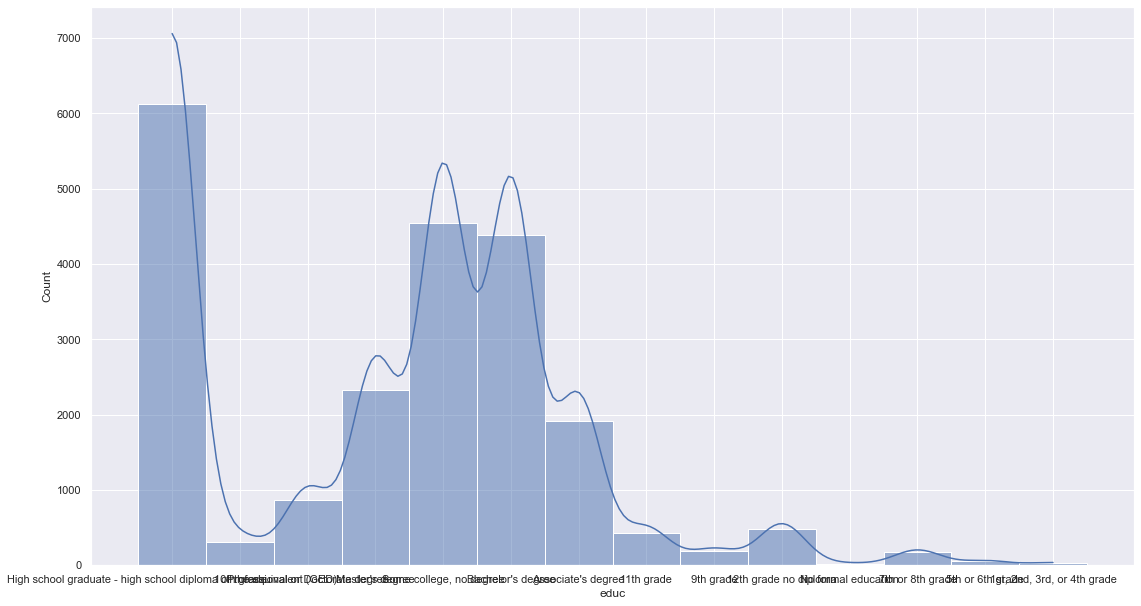

In [135]:
sns.histplot(data=df2, x = 'educ', kde=True)

In [136]:
df2['educ_category'].value_counts(normalize=True)

Bachelor's degree or higher    0.347146
Some college                   0.295463
High school                    0.280187
Less than high school          0.077205
Name: educ_category, dtype: float64

<AxesSubplot:xlabel='educ_category', ylabel='Count'>

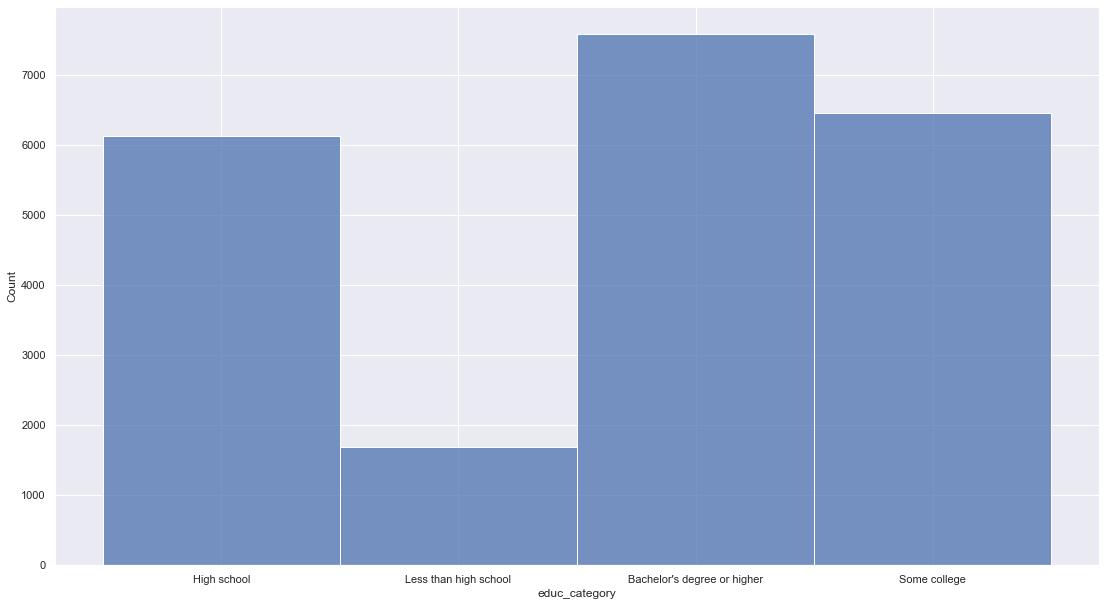

In [137]:
sns.histplot(data=df2, x = 'educ_category')

In [138]:
df2['income'].value_counts(normalize=True)

$100,000 to $124,999                                                          0.115624
$60,000 to $74,999                                                            0.106568
$50,000 to $59,999                                                            0.087861
$40,000 to $49,999                                                            0.078165
$85,000 to $99,999                                                            0.076610
$75,000 to $84,999                                                            0.072082
$125,000 to $149,999                                                          0.054290
$35,000 to $39,999                                                            0.053650
$30,000 to $34,999                                                            0.048207
$25,000 to $29,999                                                            0.046423
$175,000 to $199,999 (Nov 2016 on); $175,000 or more (Nov 2008 - Mar 2016)    0.042398
$20,000 to $24,999                         

<AxesSubplot:xlabel='income', ylabel='Count'>

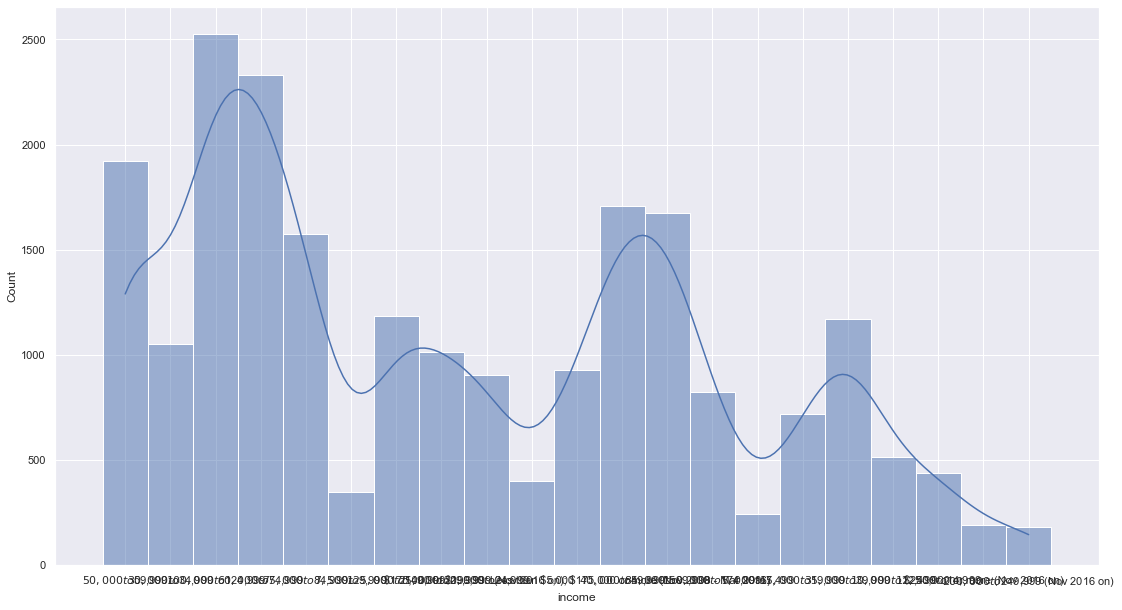

In [139]:
sns.histplot(data=df2, x = 'income', kde=True)

In [140]:
df2['income_category'].value_counts(normalize=True)

Less than $50,000     0.389773
$50,000 to $99,999    0.343121
$100,000 or more      0.267106
Name: income_category, dtype: float64

<AxesSubplot:xlabel='income_category', ylabel='Count'>

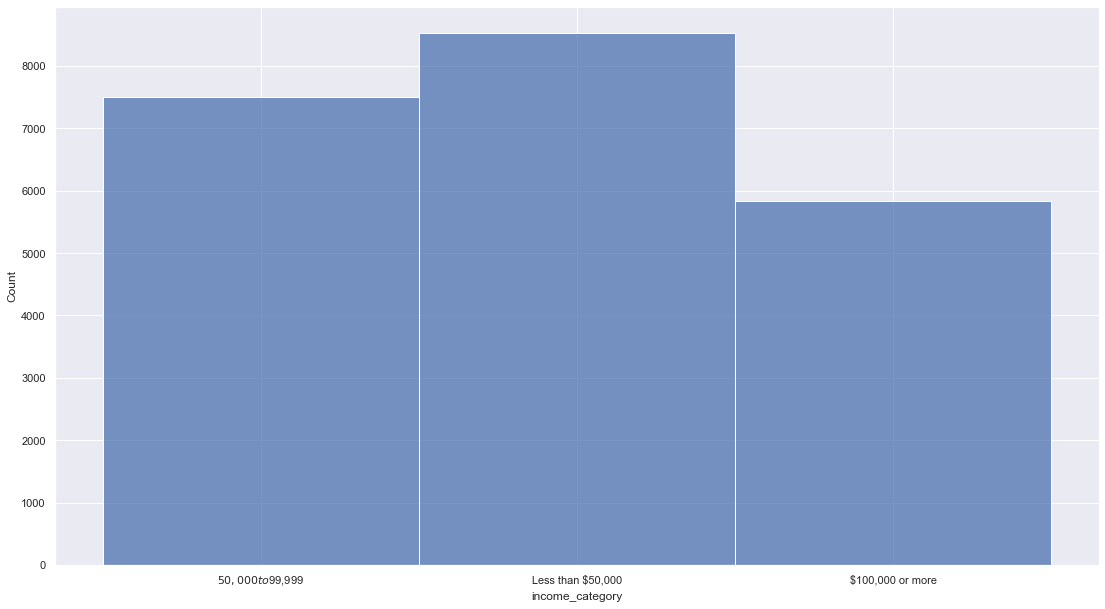

In [141]:
sns.histplot(data=df2, x = 'income_category')

In [142]:
df2['race'].value_counts(normalize=True)

White, Non-Hispanic    0.753019
Hispanic               0.098564
Black, Non-Hispanic    0.086398
Other, Non-Hispanic    0.062020
Name: race, dtype: float64

<AxesSubplot:xlabel='race', ylabel='Count'>

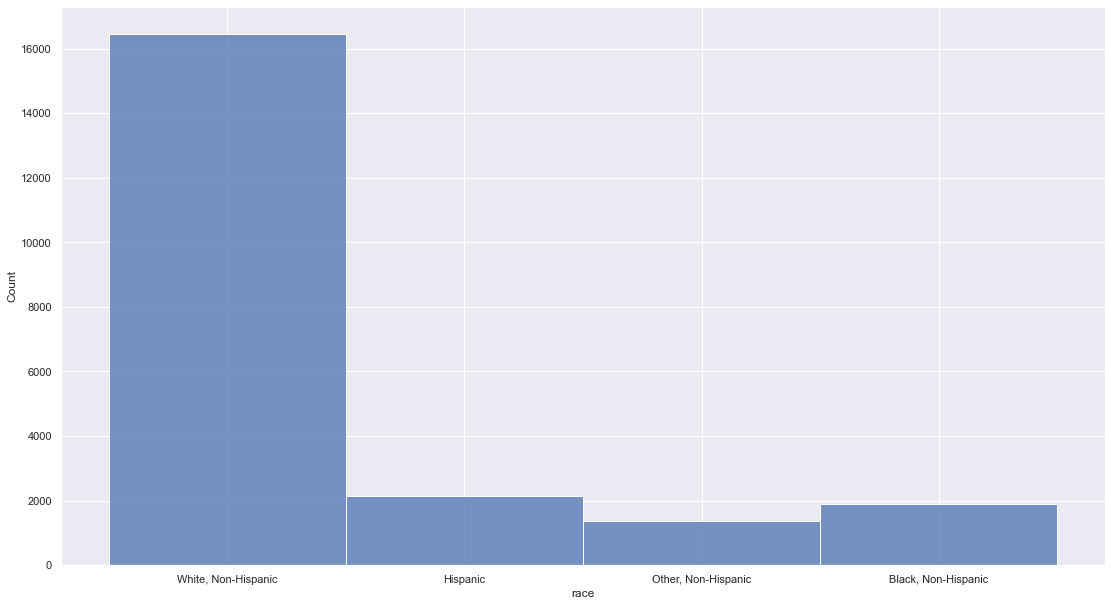

In [143]:
sns.histplot(data=df2, x = 'race')

In [144]:
df2['ideology'].value_counts(normalize=True)

Moderate, middle of the road    0.398189
Somewhat conservative           0.228412
Somewhat liberal                0.182766
Very conservative               0.110776
Very liberal                    0.070801
Refused                         0.009056
Name: ideology, dtype: float64

<AxesSubplot:xlabel='ideology', ylabel='Count'>

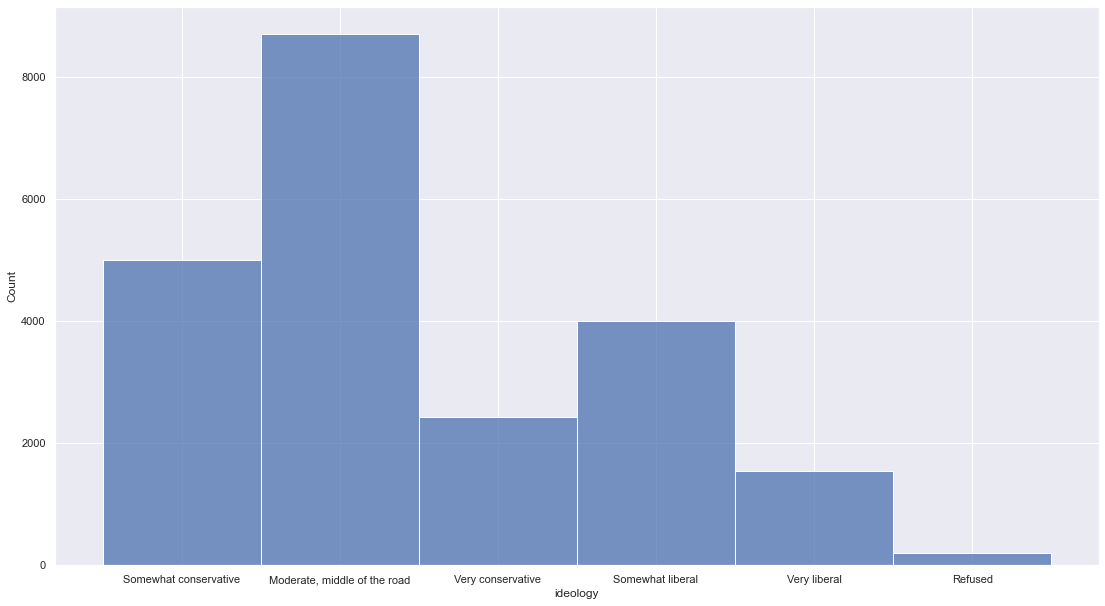

In [145]:
sns.histplot(data=df2, x = 'ideology')

In [146]:
df2['party'].value_counts(normalize=True)

Democrat                               0.334797
Republican                             0.274378
Independent                            0.253750
No party/not interested in politics    0.106385
Other; Please specify:                 0.029775
Refused                                0.000915
Name: party, dtype: float64

<AxesSubplot:xlabel='party', ylabel='Count'>

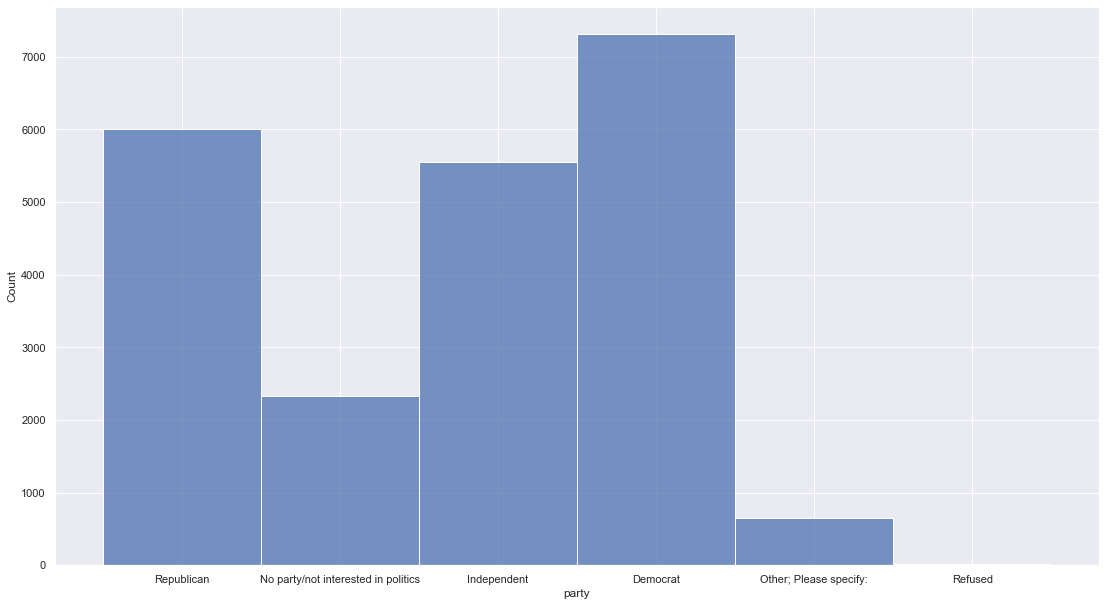

In [147]:
sns.histplot(data=df2, x = 'party')

In [148]:
df2['party_w_leaners'].value_counts(normalize=True)

Democrats                              0.418359
Republicans                            0.369100
No party/Not interested in politics    0.106385
Independent/Other                      0.105241
Refused                                0.000915
Name: party_w_leaners, dtype: float64

<AxesSubplot:xlabel='party_w_leaners', ylabel='Count'>

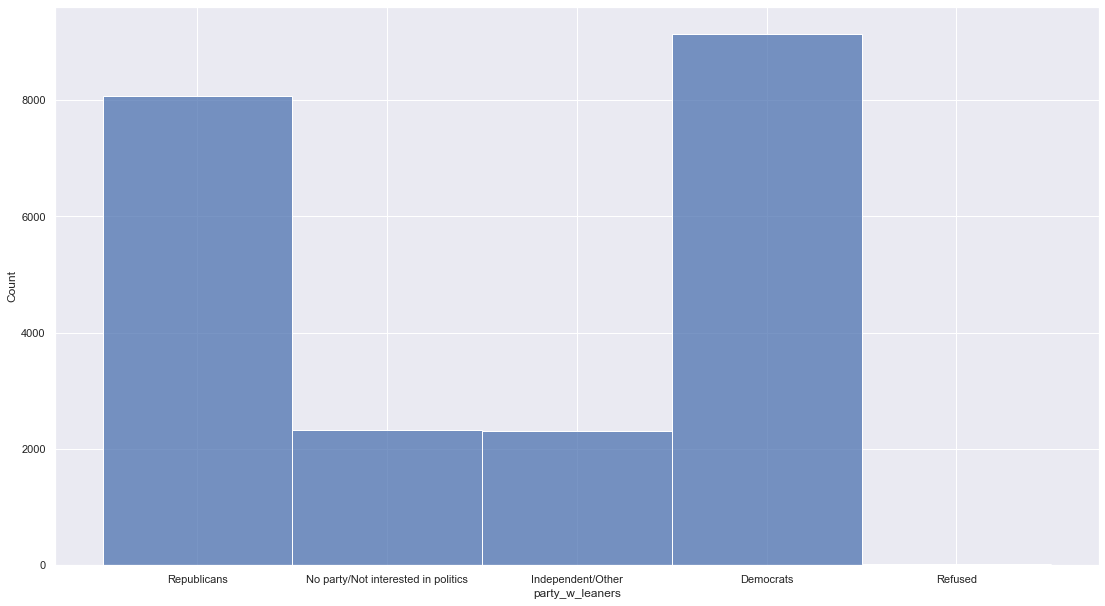

In [149]:
sns.histplot(data=df2, x = 'party_w_leaners')

In [150]:
df2['party_x_ideo'].value_counts(normalize=True)

Conservative Republican                0.249177
Moderate/Conservative Democrat         0.209294
Liberal Democrat                       0.207327
Liberal/Moderate Republican            0.118597
No Party/Not Interested in politics    0.106385
Independent (Non-Leaning)              0.105241
Refused                                0.003979
Name: party_x_ideo, dtype: float64

<AxesSubplot:xlabel='party_x_ideo', ylabel='Count'>

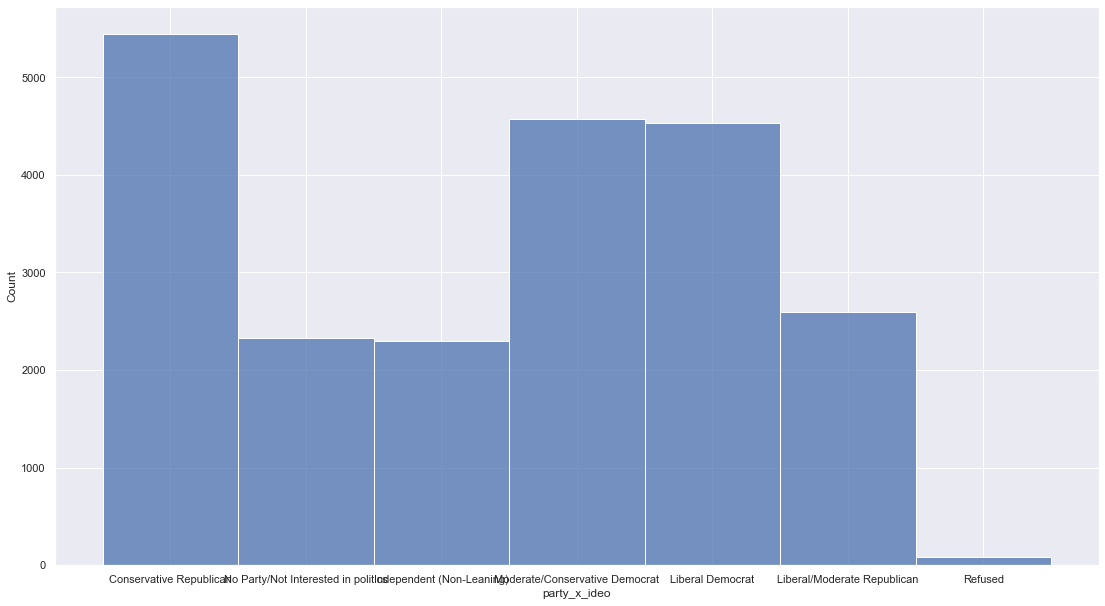

In [151]:
sns.histplot(data=df2, x = 'party_x_ideo')

In [152]:
df2['registered_voter'].value_counts(normalize=True)

Registered              0.848701
Not registered          0.099662
Prefer not to answer    0.025979
Don't know              0.015505
Not sure                0.006723
Refused                 0.003430
Name: registered_voter, dtype: float64

<AxesSubplot:xlabel='registered_voter', ylabel='Count'>

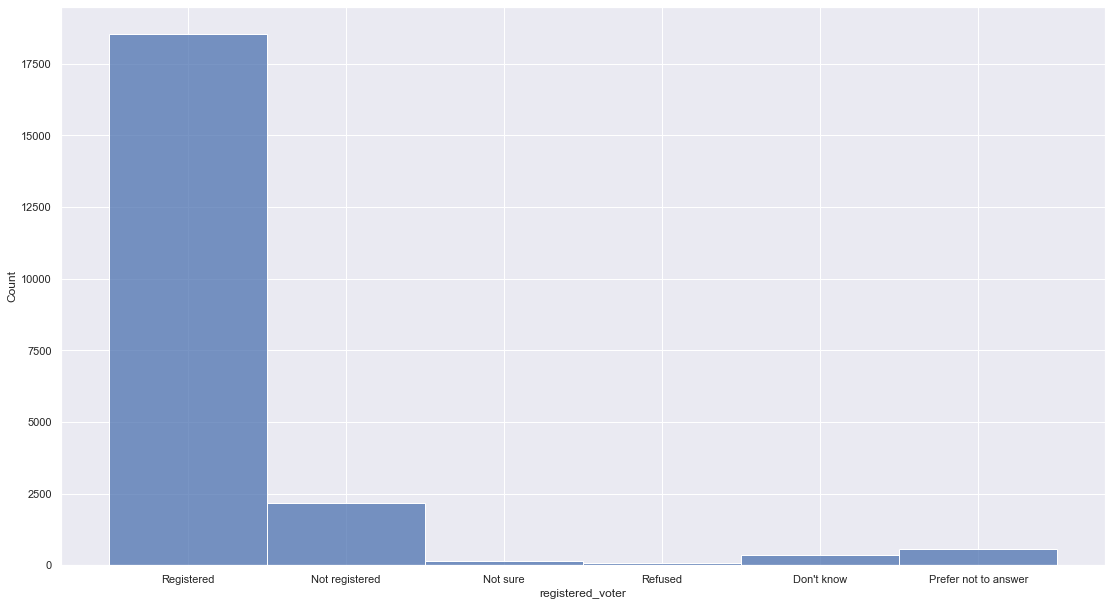

In [153]:
sns.histplot(data=df2, x = 'registered_voter')

In [154]:
df2['region9'].value_counts(normalize=True)

South Atlantic        0.193652
East-North Central    0.160035
Pacific               0.153266
Mid-Atlantic          0.134605
West-South Central    0.102406
West-North Central    0.077113
Mountain              0.075192
East-South Central    0.055113
New England           0.048619
Name: region9, dtype: float64

<AxesSubplot:xlabel='region9', ylabel='Count'>

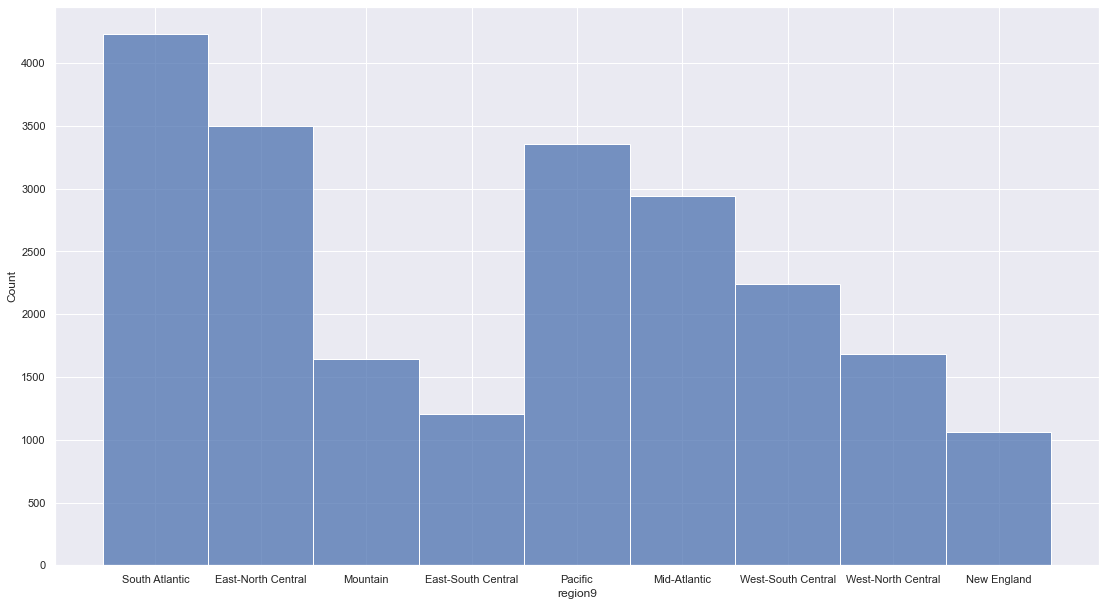

In [155]:
sns.histplot(data=df2, x = 'region9')

In [156]:
df2['region4'].value_counts(normalize=True)

South        0.351171
Midwest      0.237148
West         0.228458
Northeast    0.183224
Name: region4, dtype: float64

<AxesSubplot:xlabel='region4', ylabel='Count'>

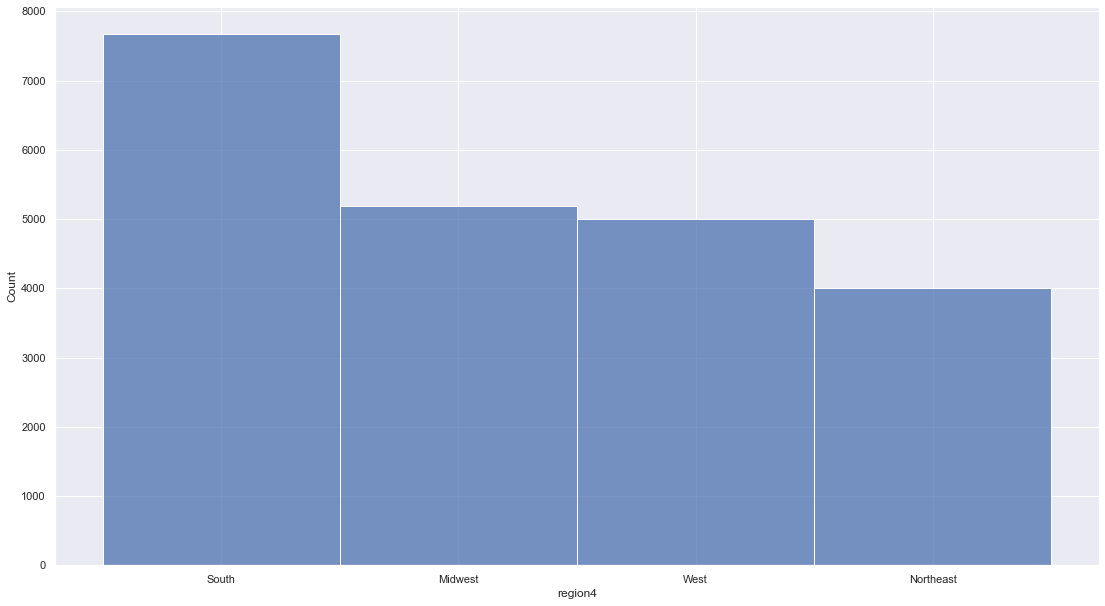

In [157]:
sns.histplot(data=df2, x = 'region4')

In [158]:
test_df = dummies.groupby('Yes').sum()

In [159]:
year_dum = pd.concat([df['year'], dummies], axis=1)

### Looking at responses for different categories for our features grouped by year to see changes over years

In [160]:
year_dum.groupby('year').sum()

generation_Baby Boomers (1946 - 1964)  \
year                                          
2008                                  823.0   
2010                                  769.0   
2011                                  742.0   
2012                                  820.0   
2013                                  769.0   
2014                                  932.0   
2015                                 1043.0   
2016                                 1015.0   
2017                                 1071.0   
2018                                  989.0   

      generation_Generation X (1965 - 1980)  \
year                                          
2008                                  525.0   
2010                                  670.0   
2011                                  478.0   
2012                                  454.0   
2013                                  390.0   
2014                                  536.0   
2015                                  571.0   
2016                                  515.0   
2017                                  572.0   
2018                                  553.0   

      generation_Greatest (Before 1928)  generation_Millennials (1981 - 1996)  \
year                                                                            
2008                               41.0                                 219.0   
2010                               17.0                                 252.0   
2011                               15.0                                 364.0   
2012                               19.0                                 351.0   
2013                               13.0                                 331.0   
2014                               17.0                                 455.0   
2015                                6.0                                 540.0   
2016                                8.0                                 491.0   
2017                                9.0                                 485.0   
2018                                5.0                                 486.0   

      generation_Silent (1928 - 1945)  generation_iGen‎/Gen Z (1997 - )  \
year                                                                      
2008                            493.0                               0.0   
2010                            246.0                               0.0   
2011                            288.0                               0.0   
2012                            325.0                               0.0   
2013                            307.0                               0.0   
2014                            319.0                               0.0   
2015                            352.0                              40.0   
2016                            318.0                              60.0   
2017                            317.0                              99.0   
2018                            261.0                              78.0   

      educ_10th grade  educ_11th grade  educ_12th grade no diploma  \
year                                                                 
2008             34.0             37.0                        50.0   
2010             49.0             48.0                        64.0   
2011             21.0             52.0                        47.0   
2012             27.0             38.0                        41.0   
2013             26.0             26.0                        40.0   
2014             22.0             47.0                        53.0   
2015             47.0             53.0                        60.0   
2016             32.0             45.0                        41.0   
2017             28.0             54.0                        44.0   
2018             28.0             28.0                        37.0   

      educ_1st, 2nd, 3rd, or 4th grade  ...  region9_South Atlantic  \
year                                    ...                           
2008               

### Creating a basic random forest model using only the features we have been working with

In [161]:
def score(model, name, X, y):
    cv = StratifiedKFold(n_splits=10,
                         random_state=620,
                         shuffle=True)
    s = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print('{} Score: {:.2f} +- {:.3f}'.format(name, s.mean(), 2 * s.std()))

In [162]:
rf = RandomForestClassifier(n_jobs=-1,
                            n_estimators = 150,
#                             criterion='entropy',
#                             max_features='sqrt',
#                             min_weight_fraction_leaf=.01,
#                             class_weight='balanced_subsample',
#                             min_impurity_decrease=.02,
#                             oob_score=True,
                            min_samples_split=.1,
                            max_depth = 100,
                            random_state=620)


In [163]:
X = dummies.drop(['Yes', 'No', "Don't know"], axis=1)
y = dummies['Yes']


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 620)

In [164]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=0.1, n_estimators=150,
                       n_jobs=-1, random_state=620)

In [165]:
score(rf, 'RF', X_train, y_train)

RF Score: 0.72 +- 0.019


In [166]:
score(rf, 'RF', X_test, y_test)

RF Score: 0.73 +- 0.035


In [167]:
score(rf, 'RF', X, y)

RF Score: 0.72 +- 0.014


In [168]:
feat_imp = pd.DataFrame({'Variable':X.columns,
                            'Importance':rf.feature_importances_}).sort_values('Importance', ascending=False)


### Getting the feature importances for basic random forest model

In [169]:
feat_imp

Variable  Importance
69       party_x_ideo_Conservative Republican    0.177492
64                  party_w_leaners_Democrats    0.158155
68                party_w_leaners_Republicans    0.107596
56                 ideology_Very conservative    0.095976
71              party_x_ideo_Liberal Democrat    0.078675
..                                        ...         ...
32  income_$200,000 to $249,999 (Nov 2016 on)    0.000016
37                  income_$40,000 to $49,999    0.000015
67                    party_w_leaners_Refused    0.000007
9            educ_1st, 2nd, 3rd, or 4th grade    0.000000
75                       party_x_ideo_Refused    0.000000

[95 rows x 2 columns]

In [170]:
def stackplot(group, title, Xaxis):
    fig, ax = plt.subplots(figsize=(10, 10))

    df.groupby(group)['happening'].value_counts(normalize=True).unstack().T.loc[['No', "Don't know", 'Yes']].T \
        .plot(kind='barh', 
              figsize=(10, 8), 
              stacked=True,
              color=['slategrey', 'deepskyblue', 'palegreen'], 
              ax=ax)

    ax.set_title(title, 
                 fontsize=15, 
                 fontweight='bold', 
                 color='firebrick', 
                 loc='left')
    ax.set_ylabel(Xaxis, weight='bold', labelpad=20)


    for rect in ax.patches:

        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        label_text = round(width, 2)

        label_x = x + width / 2
        label_y = y + height / 2
        ax.text(label_x, label_y, label_text, ha='center', va='center')
    ;


### Stacked bar plots normalized to see belief in climate change per feature

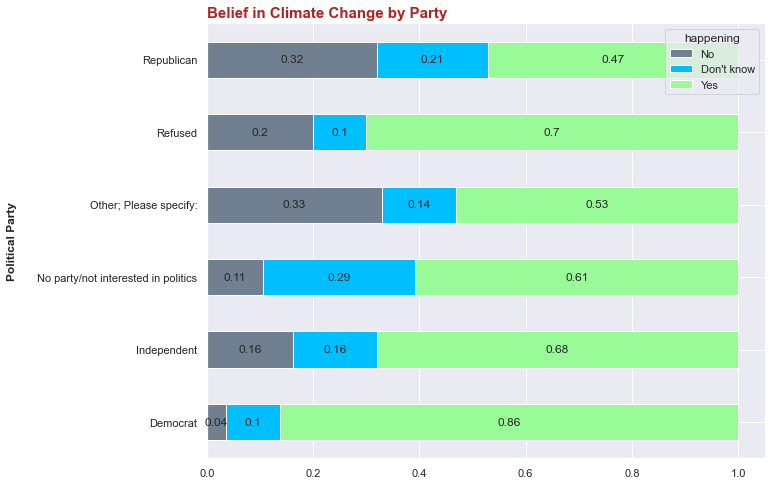

In [171]:
stackplot('party', 'Belief in Climate Change by Party', 'Political Party')

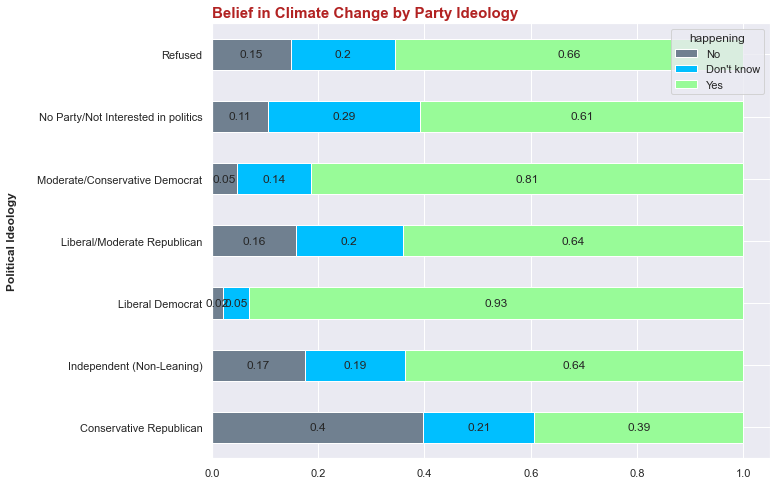

In [172]:
stackplot('party_x_ideo', 'Belief in Climate Change by Party Ideology', 'Political Ideology')

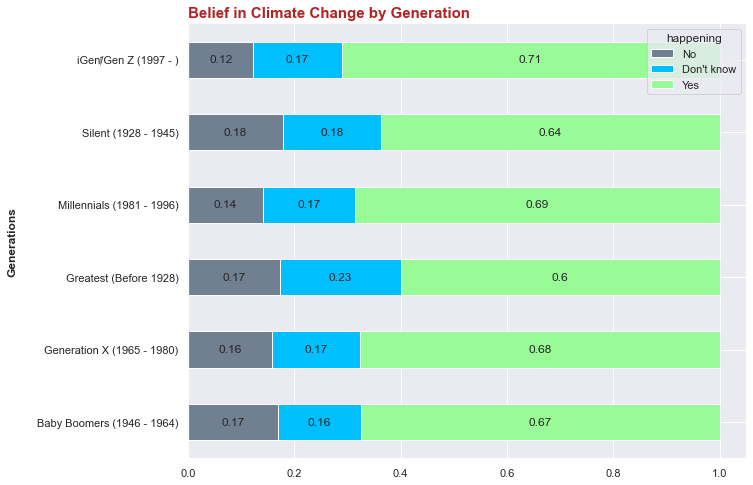

In [173]:
stackplot('generation', 'Belief in Climate Change by Generation', 'Generations')

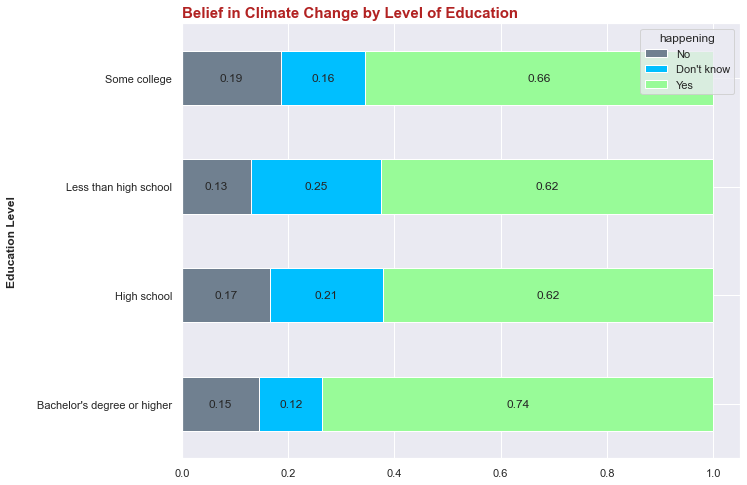

In [174]:
stackplot('educ_category', 'Belief in Climate Change by Level of Education', 'Education Level')

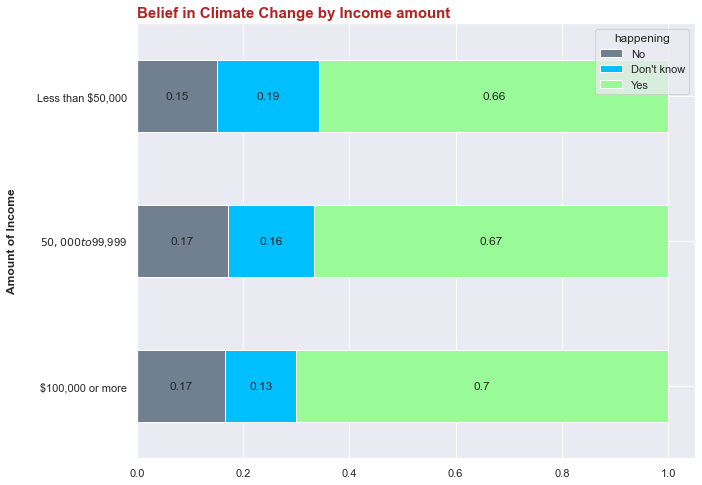

In [175]:
stackplot('income_category', 'Belief in Climate Change by Income amount', 'Amount of Income')

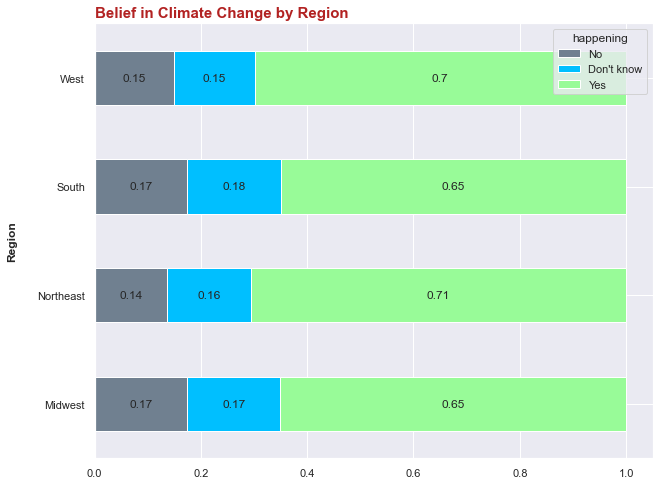

In [176]:
stackplot('region4', 'Belief in Climate Change by Region', 'Region')

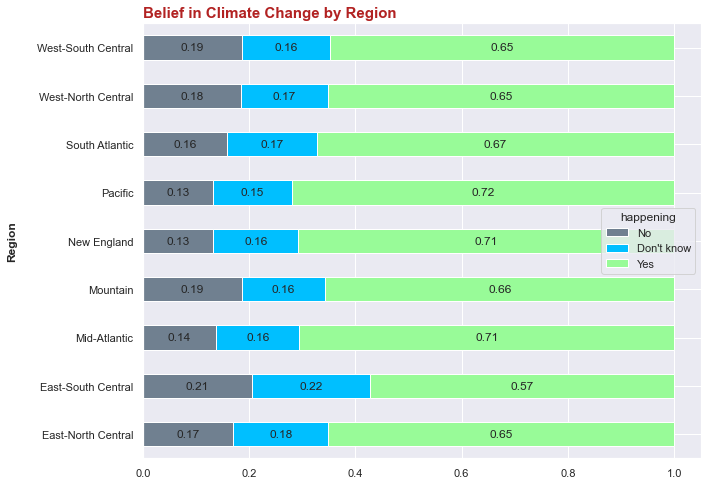

In [177]:
stackplot('region9', 'Belief in Climate Change by Region', 'Region')

### Recommendations for features to use in modeling

 * It appears that the group of people that feel most strongly about whether or not global warming is happening appears to be politically affiliated. We see the strongest change between majority 'yes' or majority 'no' to weather global warming is happening is seen with people affiliated with the Democratic and Republican party respectively as well as differing ideologies. 

* Education and income have been grouped in categories that are more normally distributed and will be useful for use in modeling.


* There is some variation in belief of global warming depending on the generation they were born in. It would be good to use this feature within our model.


* Region4 is an aggregated feature based on region9 locations. The more normalized region4 would be a good feature to use in the model as well

### Most interesting features:


- generation
- educ_category
- income_category
- party
- party_x_ideo
- region4

In [178]:
# ordinal_feat = df[['generation', 'educ_category', 'income_category']]
# nom_feat = df[['party', 'party_x_ideo', 'region4']]

In [179]:
# gen_lst = ['Greatest (Before 1928)','Silent (1928 - 1945)','Baby Boomers (1946 - 1964)',
#                                     'Generation X (1965 - 1980)','Millennials (1981 - 1996)',
#                                     'iGen\u200e/Gen Z (1997 - )']
# educ_lst = ['Less than high school','High school','Some college',
#                                      "Bachelor's degree or higher"]
# inc_lst = ['Less than $50,000', '$50,000 to $99,999', '$100,000 or more']


# ordinal = OrdinalEncoder(categories=[gen_lst, educ_lst, inc_lst],dtype=np.str_)



# ordinal_feat = ordinal.fit_transform(ordinal_feat)

In [180]:
df.drop(['educ', 'income', 'race', 'ideology', 'party_w_leaners',
         'registered_voter', 'region9'],
       axis = 1,
       inplace=True)

Drop the columns that are uninteresting.

## Saba

In [181]:
df.religion.value_counts(normalize=True)

Catholic                                                           0.230607
Protestant (e.g., Methodist, Lutheran, Presbyterian, Episcopal)    0.214645
None of the Above (Apr 2014 on); None (Nov 2008 - Dec 2013)        0.137898
Baptist - any denomination                                         0.136526
Other Christian                                                    0.114480
Pentecostal                                                        0.028906
Agnostic (Apr 2014 on)                                             0.028814
Atheist (Apr 2014 on)                                              0.027763
Jewish                                                             0.023692
Mormon                                                             0.017609
Other - non-Christian (Please specify)                             0.017517
Buddhist                                                           0.006540
Refused                                                            0.004528
Hindu       

**These values represent the identified religions in the survey**

In [182]:
df[df['year']=='2014']['religion'].value_counts(normalize=True)

Series([], Name: religion, dtype: float64)

In [183]:
df[df['year']=='2013']['religion'].value_counts(normalize=True)

Series([], Name: religion, dtype: float64)

In [184]:
df[df['year']=='2015']['religion'].value_counts(normalize=True)

Series([], Name: religion, dtype: float64)

In [185]:
df.groupby('religion')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T

happening                                                 No  Don't know  \
religion                                                                   
Agnostic (Apr 2014 on)                              0.071429    0.074603   
Atheist (Apr 2014 on)                               0.065898    0.060956   
Baptist - any denomination                          0.207705    0.202010   
Buddhist                                            0.097902    0.090909   
Catholic                                            0.142205    0.157477   
Eastern Orthodox                                    0.150685    0.123288   
Hindu                                               0.044944    0.112360   
Jewish                                              0.125483    0.096525   
Mormon                                              0.275325    0.189610   
Muslim                                              0.089552    0.134328   
None of the Above (Apr 2014 on); None (Nov 2008...  0.106799    0.173466   
Other - non-Christian (Please specify)              0.107050    0.122715   
Other Christian                                     0.211346    0.193767   
Pentecostal                                         0.250000    0.208861   
Protestant (e.g., Methodist, Lutheran, Presbyte...  0.180268    0.168762   
Refused                                             0.161616    0.171717   

happening                                                Yes  
religion                                                      
Agnostic (Apr 2014 on)                              0.853968  
Atheist (Apr 2014 on)                               0.873147  
Baptist - any denomination                          0.590285  
Buddhist                                            0.811189  
Catholic                                            0.700317  
Eastern Orthodox                                    0.726027  
Hindu                                               0.842697  
Jewish                                              0.777992  
Mormon                                              0.535065  
Muslim                                              0.776119  
None of the Above (Apr 2014 on); None (Nov 2008...  0.719735  
Other - non-Christian (Please specify)              0.770235  
Other Christian                                     0.594886  
Pentecostal                                         0.541139  
Protestant (e.g., Methodist, Lutheran, Presbyte...  0.650970  
Refused                                             0.666667

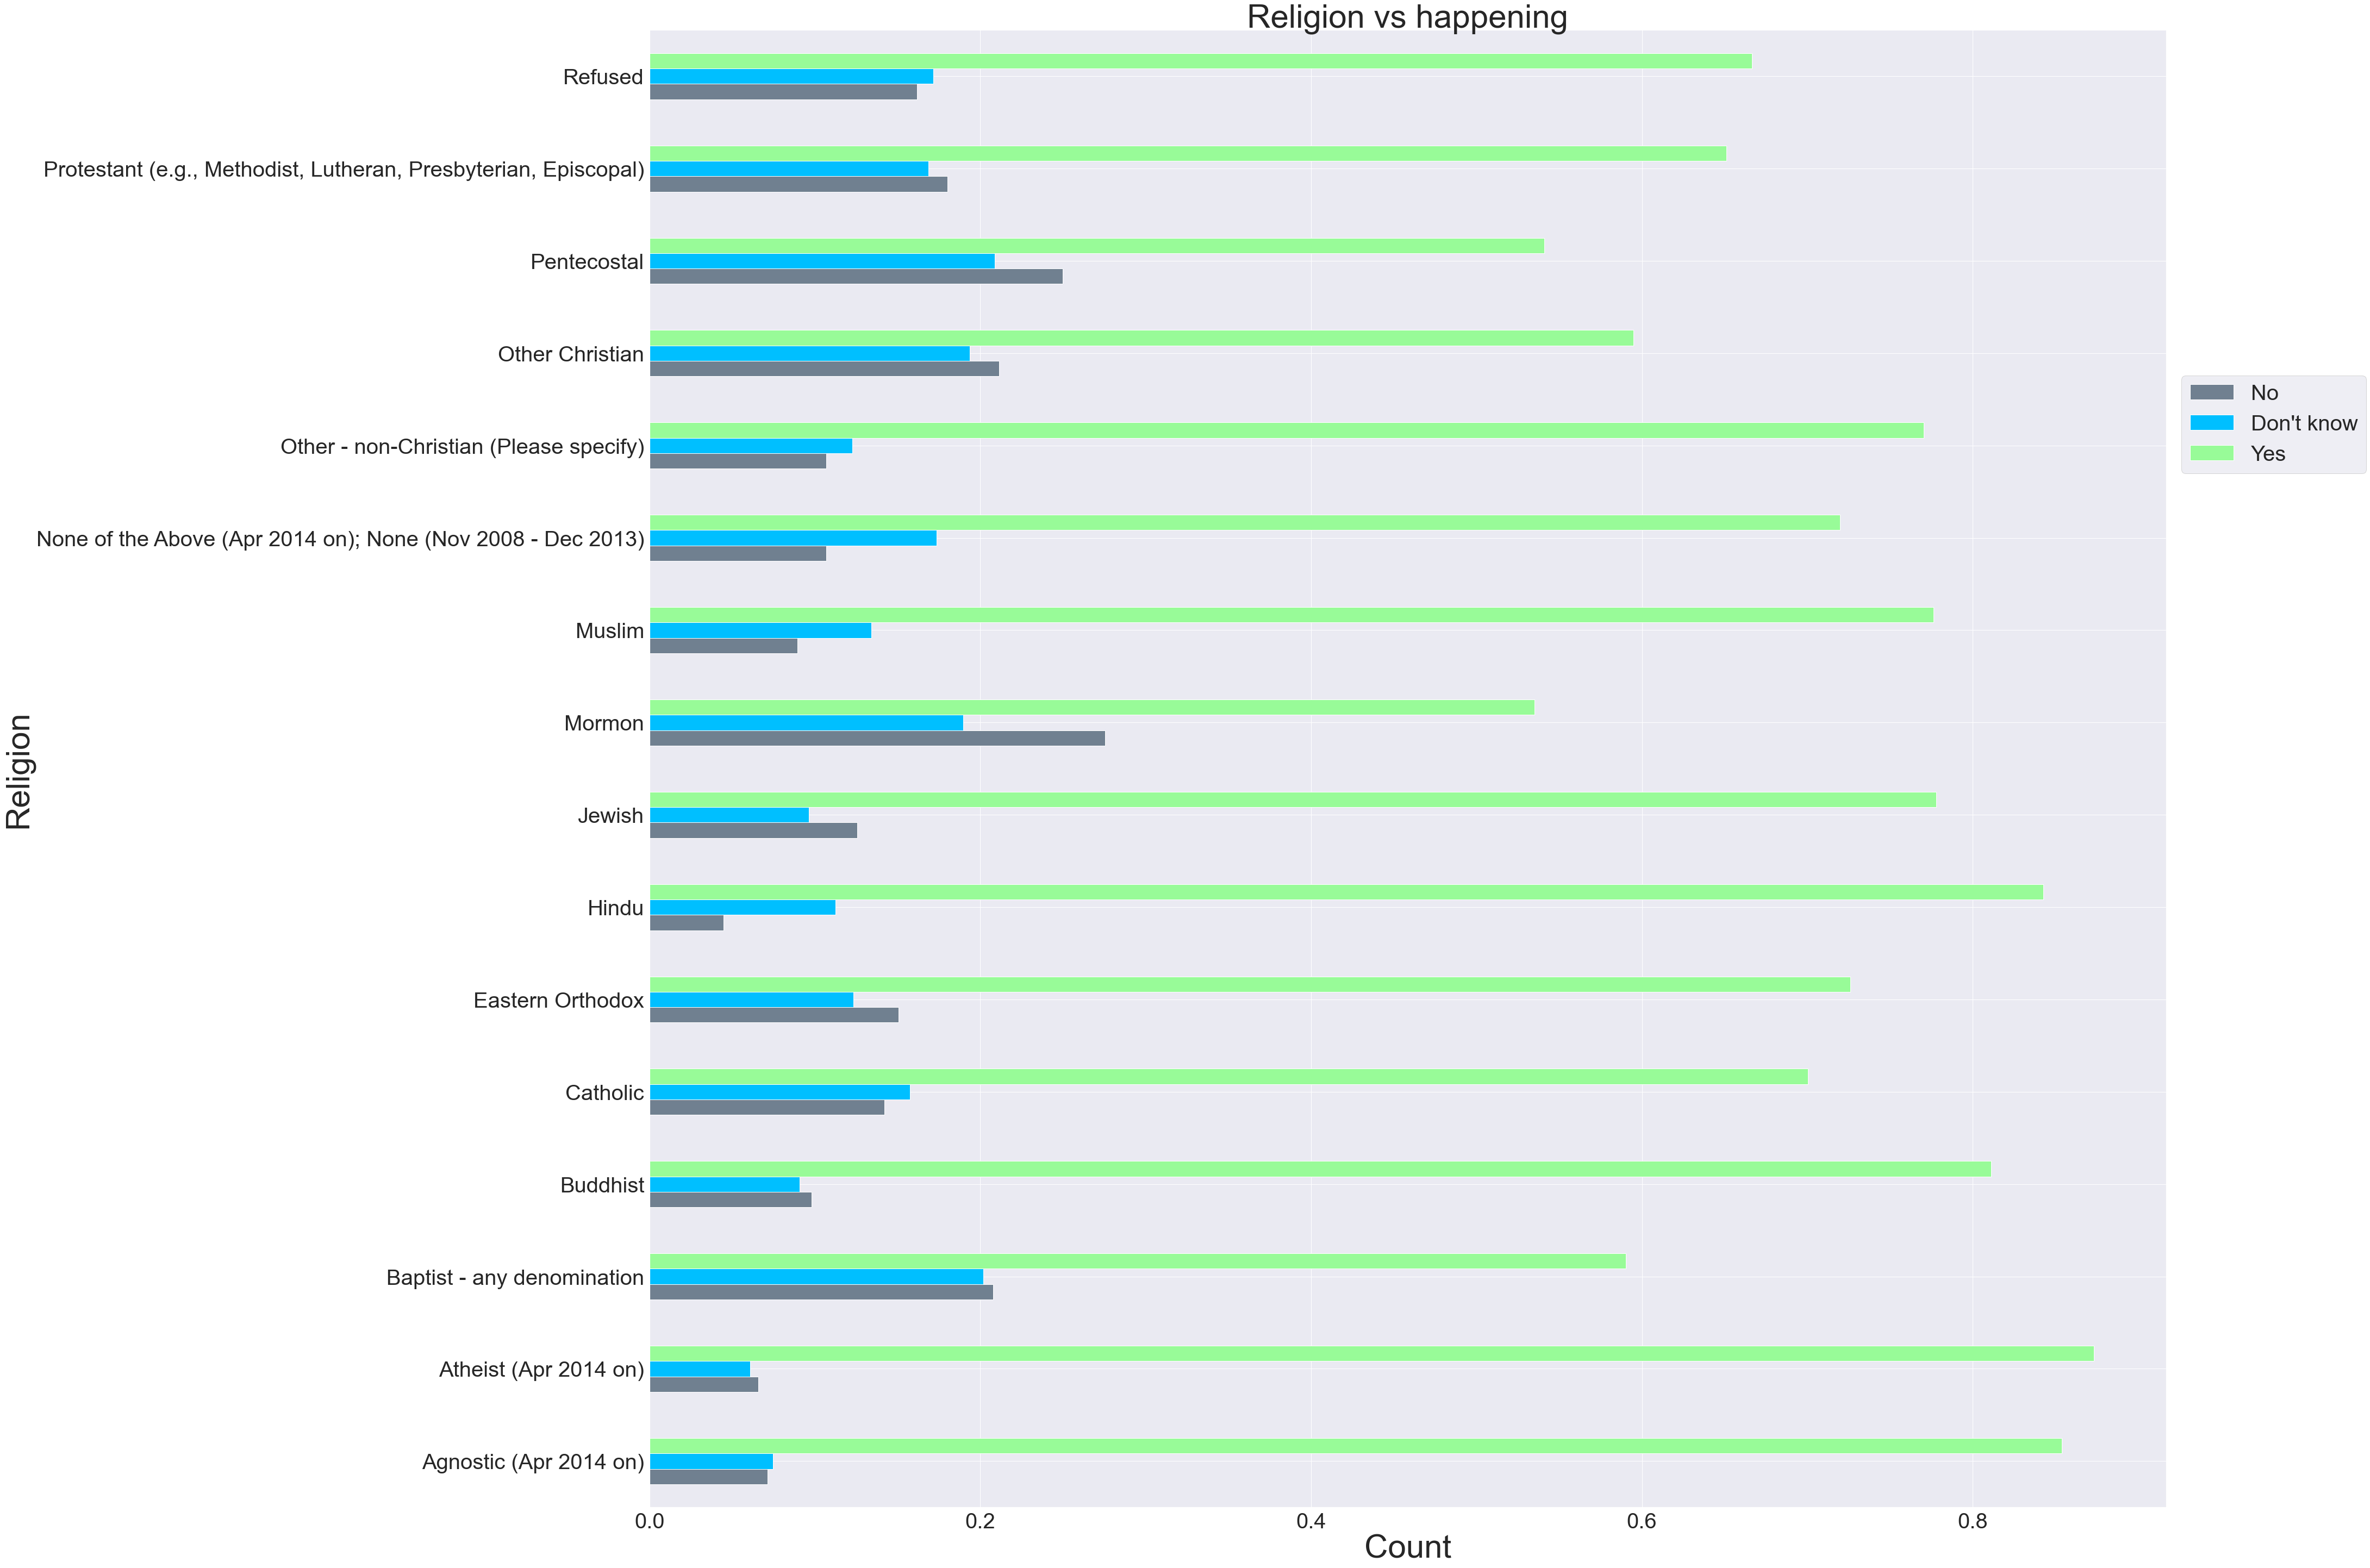

In [186]:
ax = df.groupby('religion')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Religion',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Religion vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);

- **This graph represents the distribution of`happening` across various religions.**
- **Largely people across all religions accept that climate change is happening. Baptist seem to have a large proportion of people not accepting climate change**

In [187]:
list(df.religion_other_nonchristian.unique())

[nan,
 'Unitarian',
 "Spiritual but don't attend church",
 'Spiritual',
 'native american',
 'Unitarian Universalist',
 'Deist',
 'Pagan',
 'God Loving',
 'Wiccan',
 'nature-based',
 'baptist',
 'Eclectic Spiritualist',
 'Spiritual not religious',
 'Just',
 'Shaman',
 'Unitarian-Universalist',
 'Prefer not say',
 'Jw',
 '"Believer"',
 'Pagan/Shamanic Witch',
 'Spiritualist',
 'Church of Christ',
 'prefer not to state',
 'NO RELIGION',
 'none of your bee wax',
 'evangelical',
 'female ancestor worship',
 'Non denominational',
 'unitarian  SRF',
 'born again',
 'apostolic',
 'unitarian universalist',
 'Non-denominationa',
 'Jesus',
 'SEVENTH DAY  ADVENTIST',
 'Sikh',
 'Anabaptist',
 'spiritual',
 'Human',
 'science',
 'Dystheist',
 'Taoist',
 'no denomanation',
 'G',
 'Agnostic Atheist',
 'Native American truths',
 "I'm a Christian",
 'Heathen',
 'Love and Compassion',
 'Christian',
 'Quaker',
 'Jehovah’s Witness',
 'pagan',
 'Unitarianism',
 'NOYB',
 'LOVEBIBLELIGHTS',
 'Nondenomination

**This is user filled column so a lot of typos are being seen, since we have religion and attendance data we might drop this column**

In [188]:
df.evangelical.value_counts(normalize=True)

No            0.662505
Yes           0.249909
Don't Know    0.082464
Refused       0.005123
Name: evangelical, dtype: float64

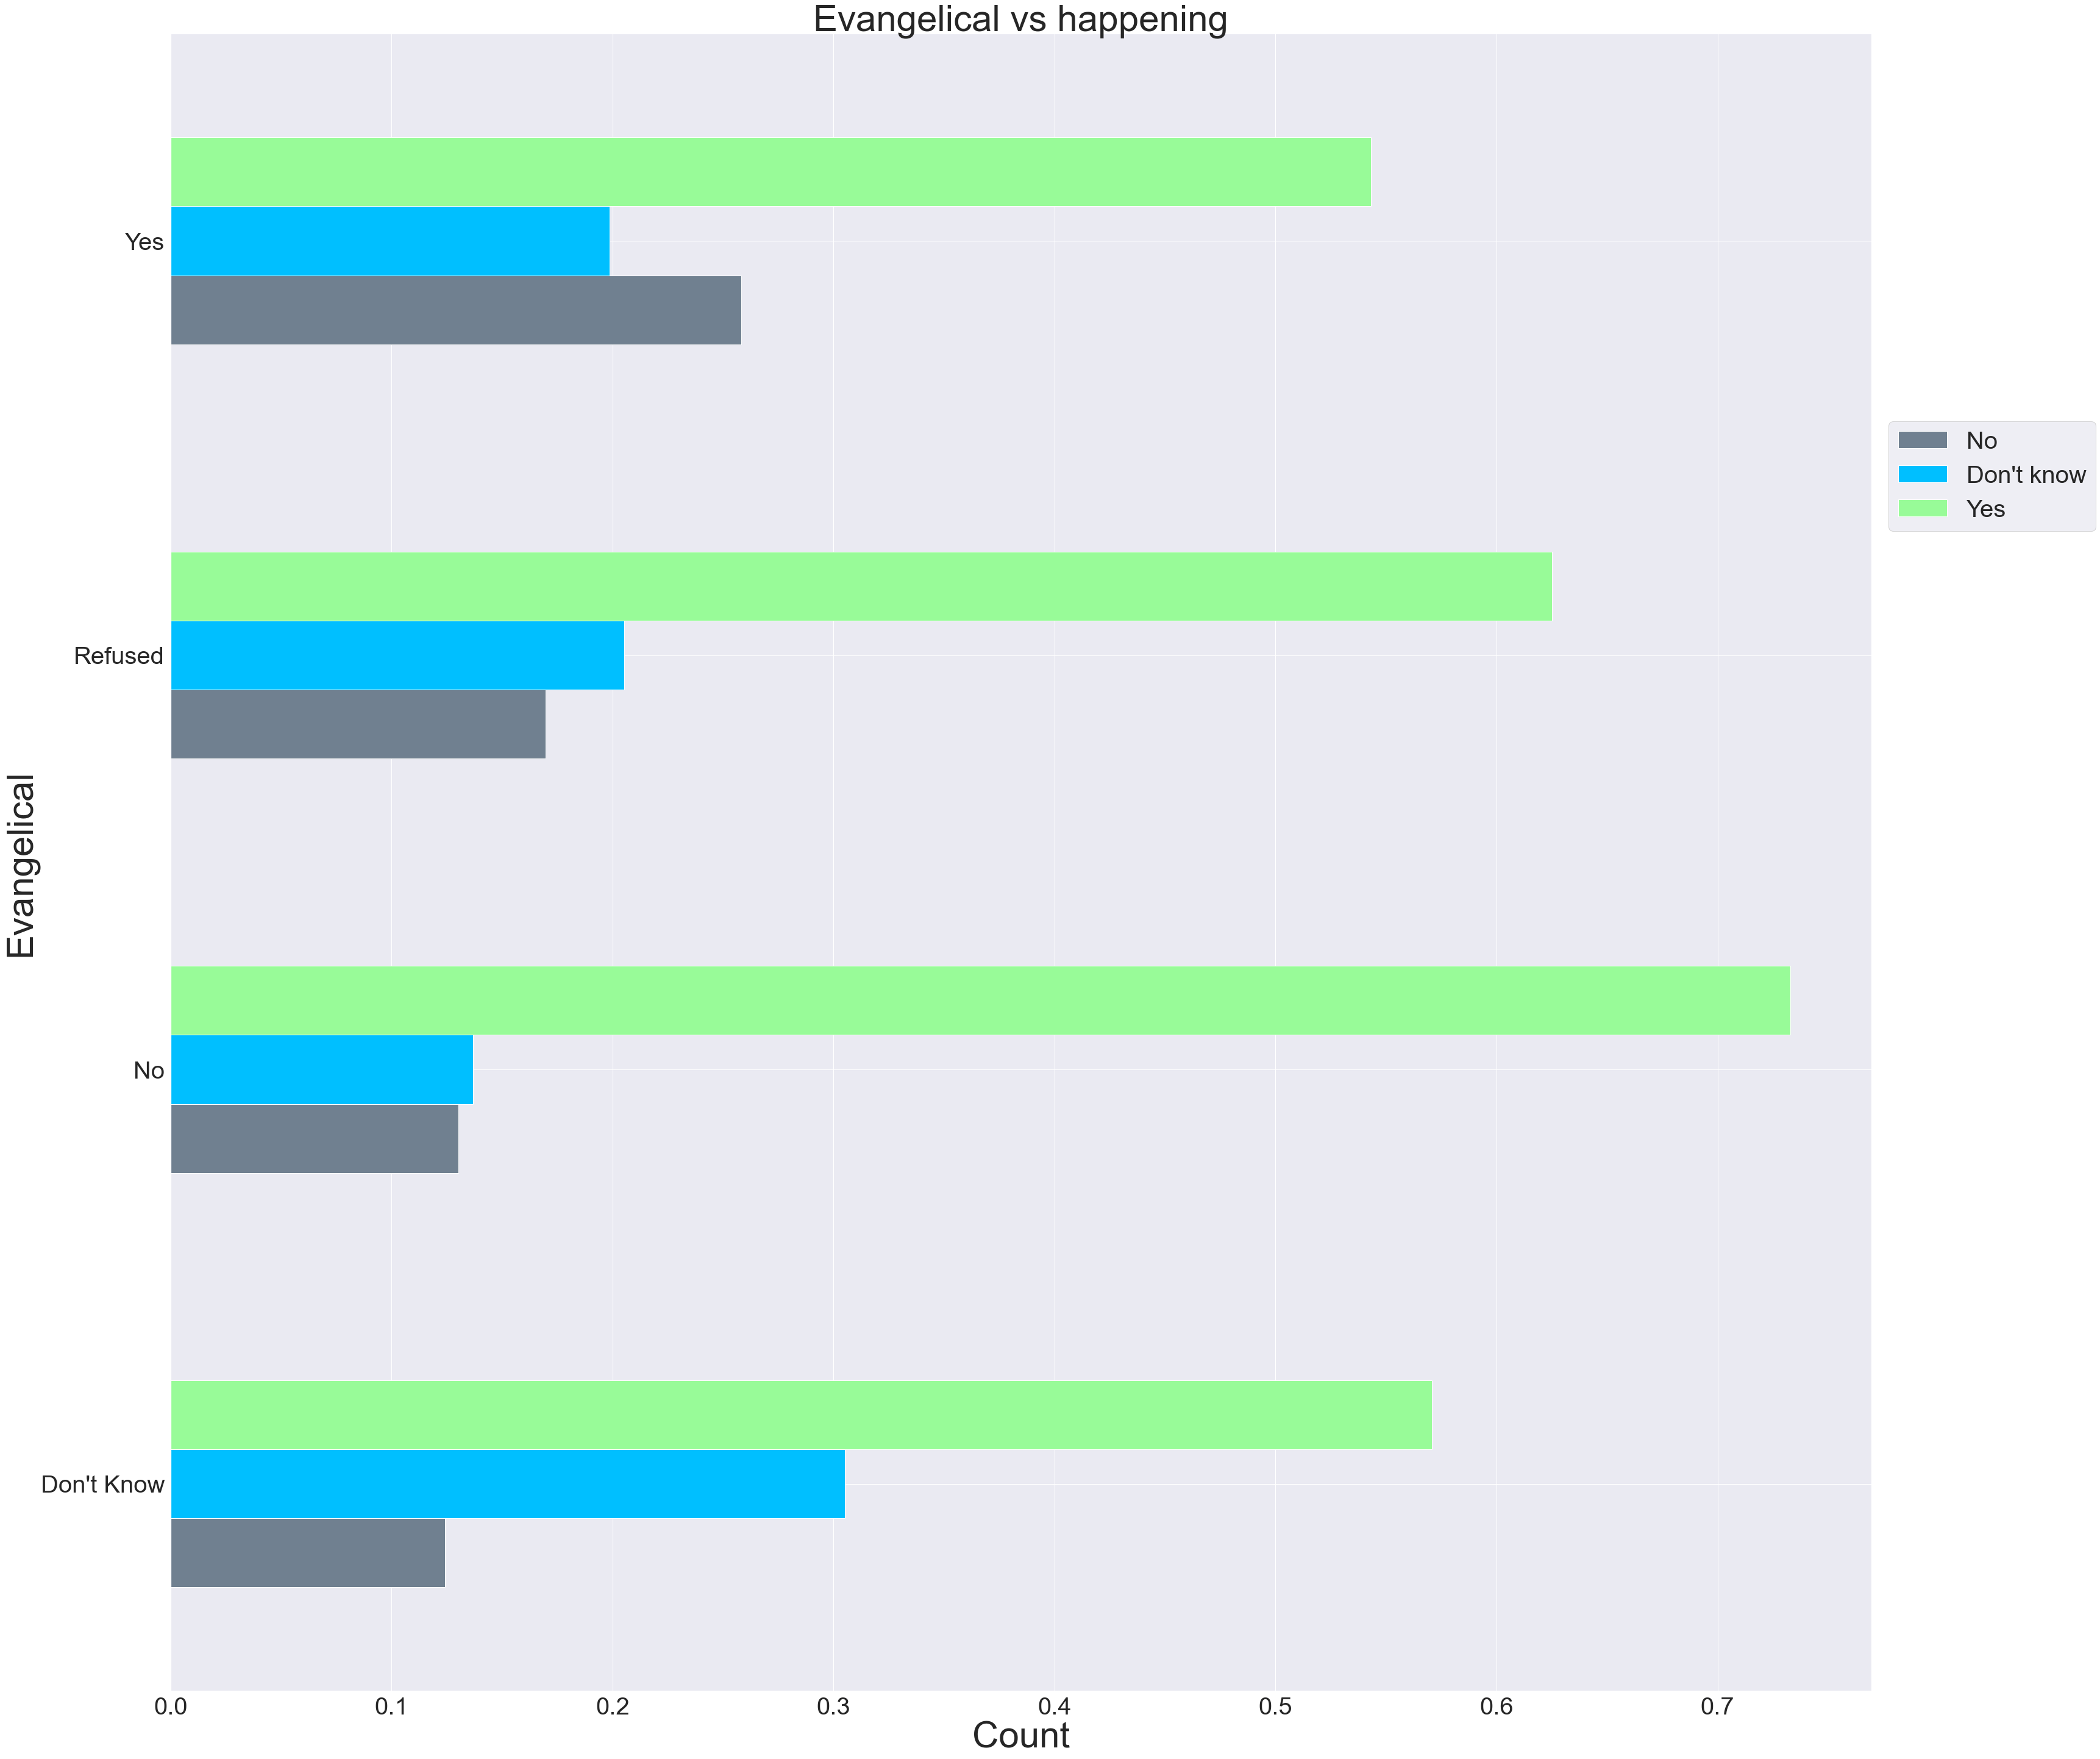

In [189]:
ax = df.groupby('evangelical')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Evangelical',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Evangelical vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**People who said Yes to being evangelical or refused to answer whether they are evangelical have a higher proportion of people not accepting climate change**

In [190]:
df.service_attendance.value_counts(normalize=True)

Never                    0.250412
Once a week              0.216978
Once a year or less      0.179336
A few times a year       0.166575
More than once a week    0.101994
Once or twice a month    0.078531
Refused                  0.006175
Name: service_attendance, dtype: float64

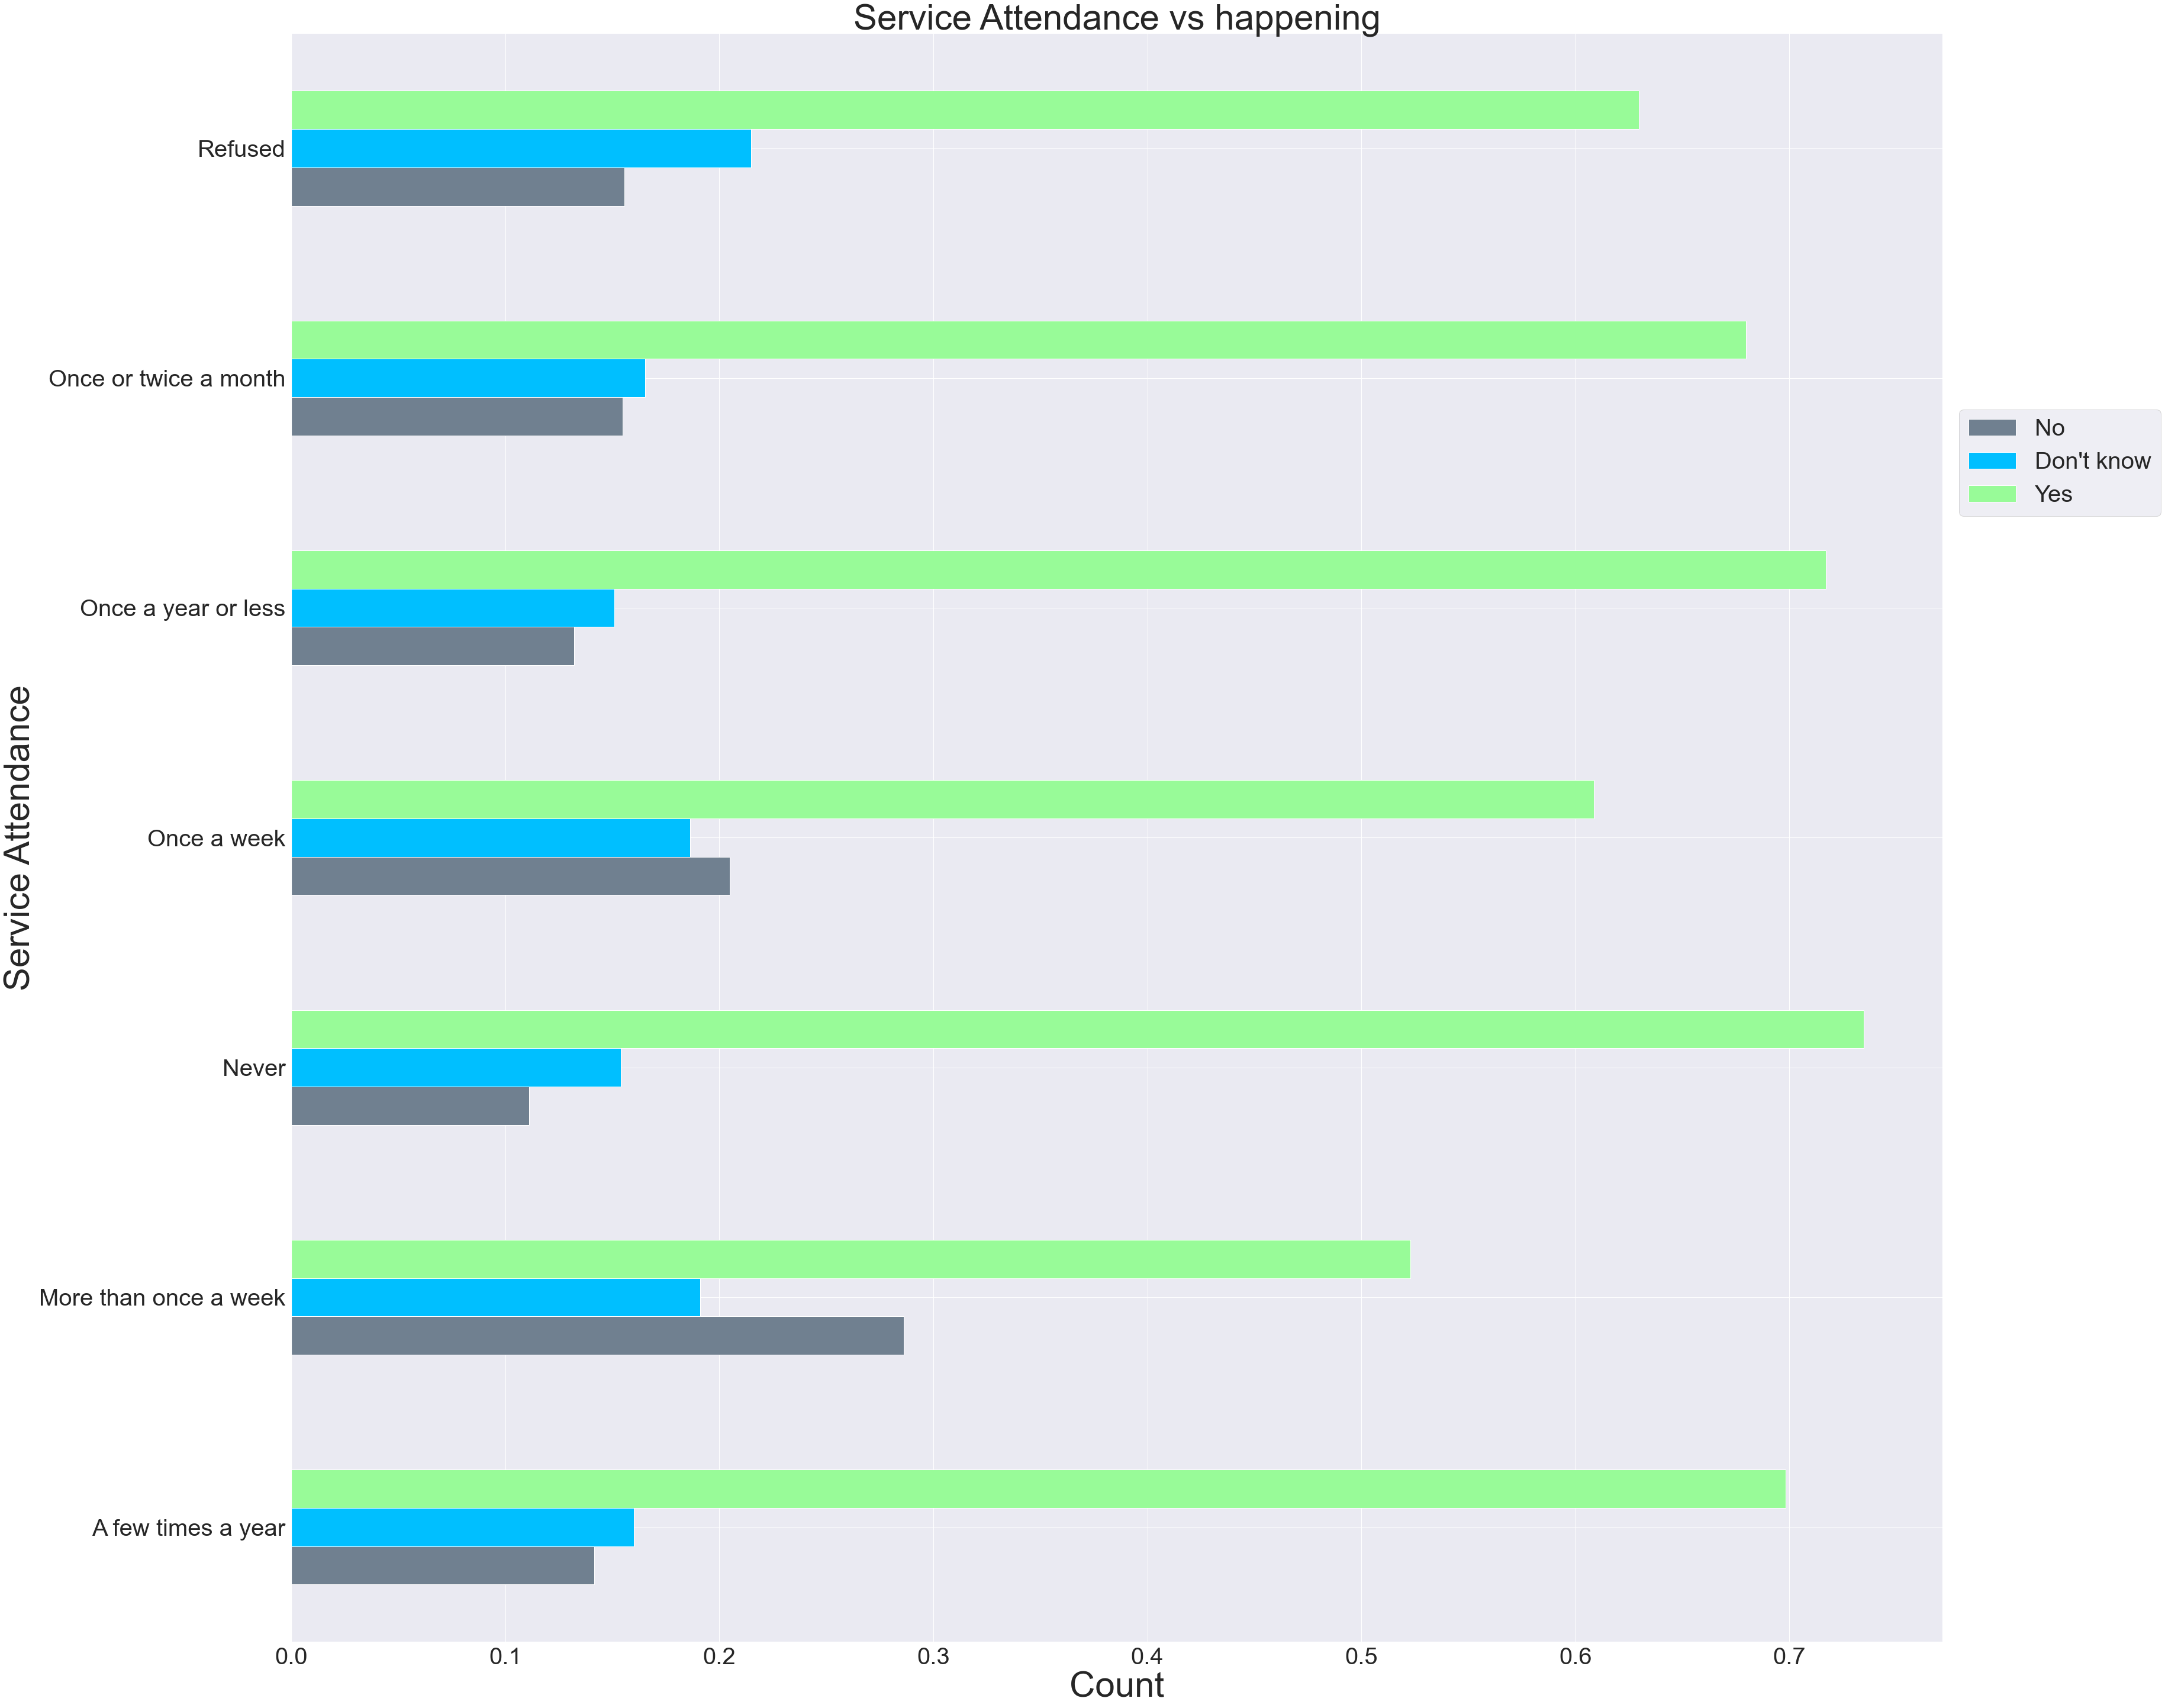

In [191]:
ax = df.groupby('service_attendance')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Service Attendance',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Service Attendance vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**People who go for service attendance for more than once a week and once a week have a higher proportion of people refusing to believe in climate change compared to all people in that particular label of service attendance**

In [192]:
#mapping values to the ordinal variable representing religiosity
service_attendance_di = {'Never': 1,
                   'Once a week': 5,
                   'Once a year or less': 2,
                   'A few times a year': 3,
                   'More than once a week':6,
                   'Once or twice a month':4,
                   'Refused':-1,
                        }
df.service_attendance= df['service_attendance'].map(lambda x: service_attendance_di[x])


In [193]:
df.marit_status.value_counts(normalize=True)

Married                0.582190
Never married          0.181897
Divorced               0.108169
Living with partner    0.060831
Widowed                0.050357
Separated              0.016557
Name: marit_status, dtype: float64

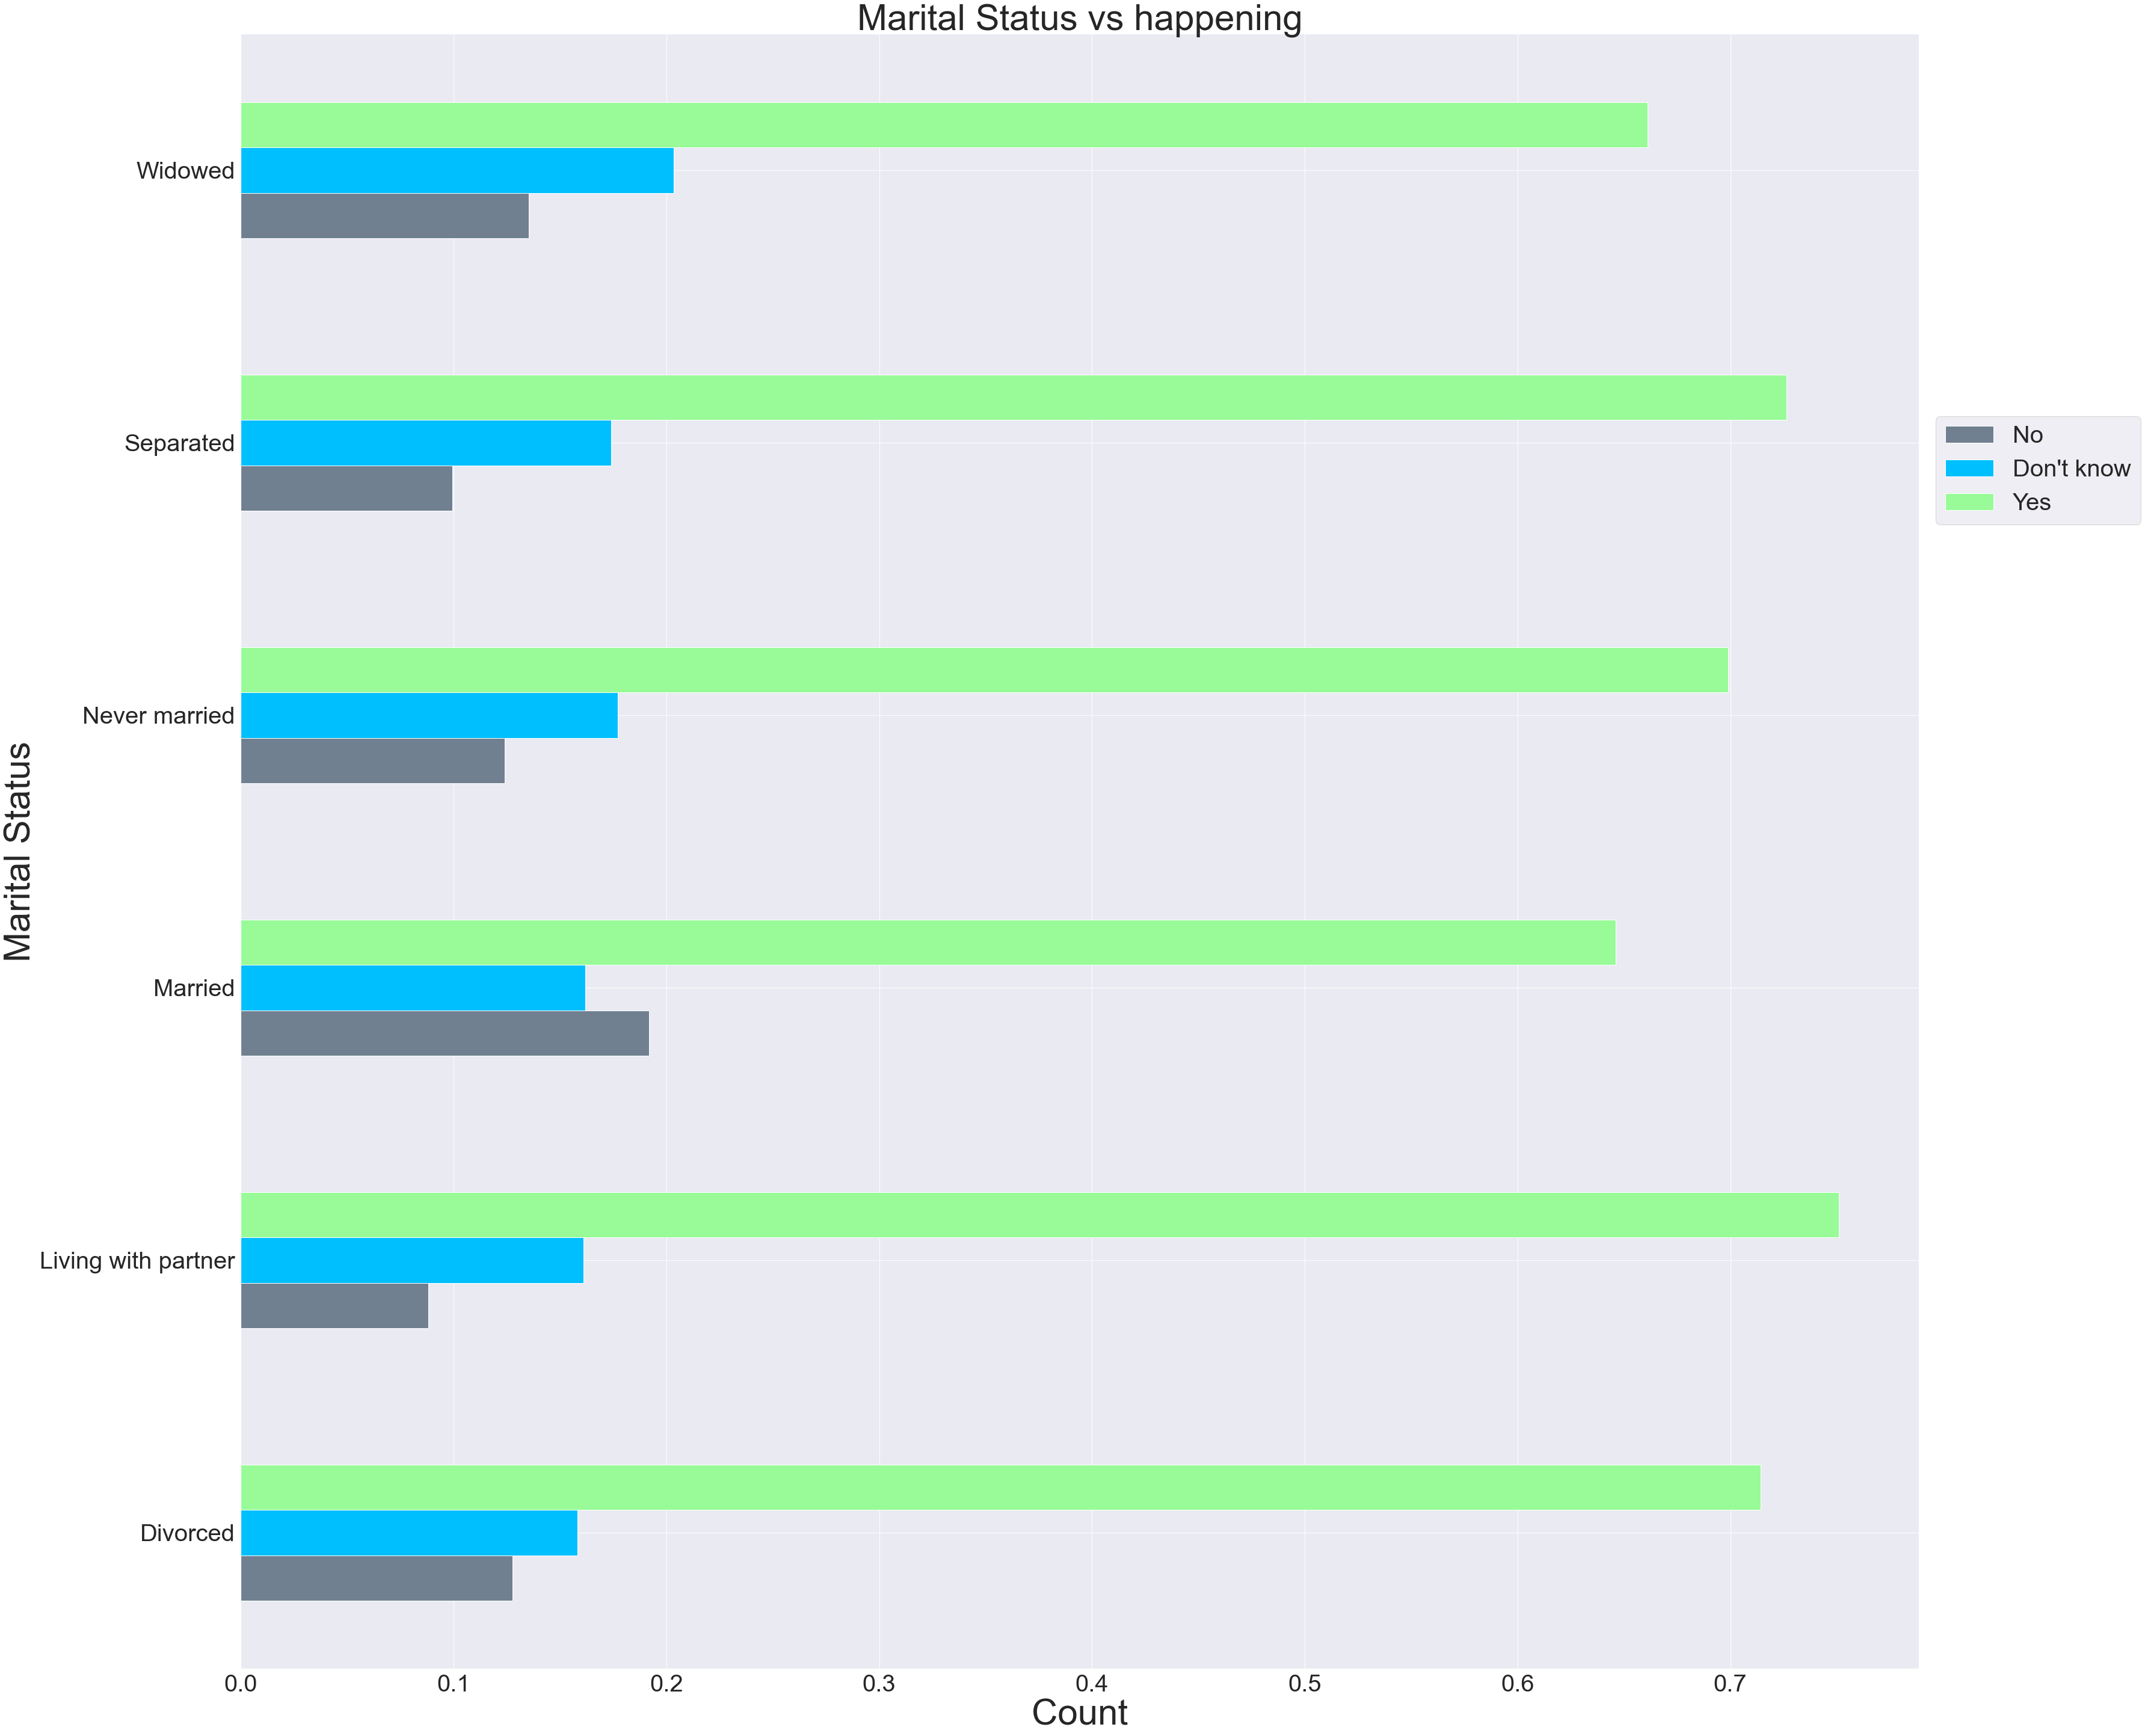

In [194]:
ax = df.groupby('marit_status')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Marital Status',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Marital Status vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` across various marital status.**

In [195]:
df.employment.value_counts(normalize=True)

Working - as a paid employee                    0.495152
Not working - retired                           0.228138
Working - self-employed                         0.075787
Not working - other                             0.071442
Not working - disabled                          0.065084
Not working - looking for work                  0.056714
Not working - on temporary layoff from a job    0.007684
Name: employment, dtype: float64

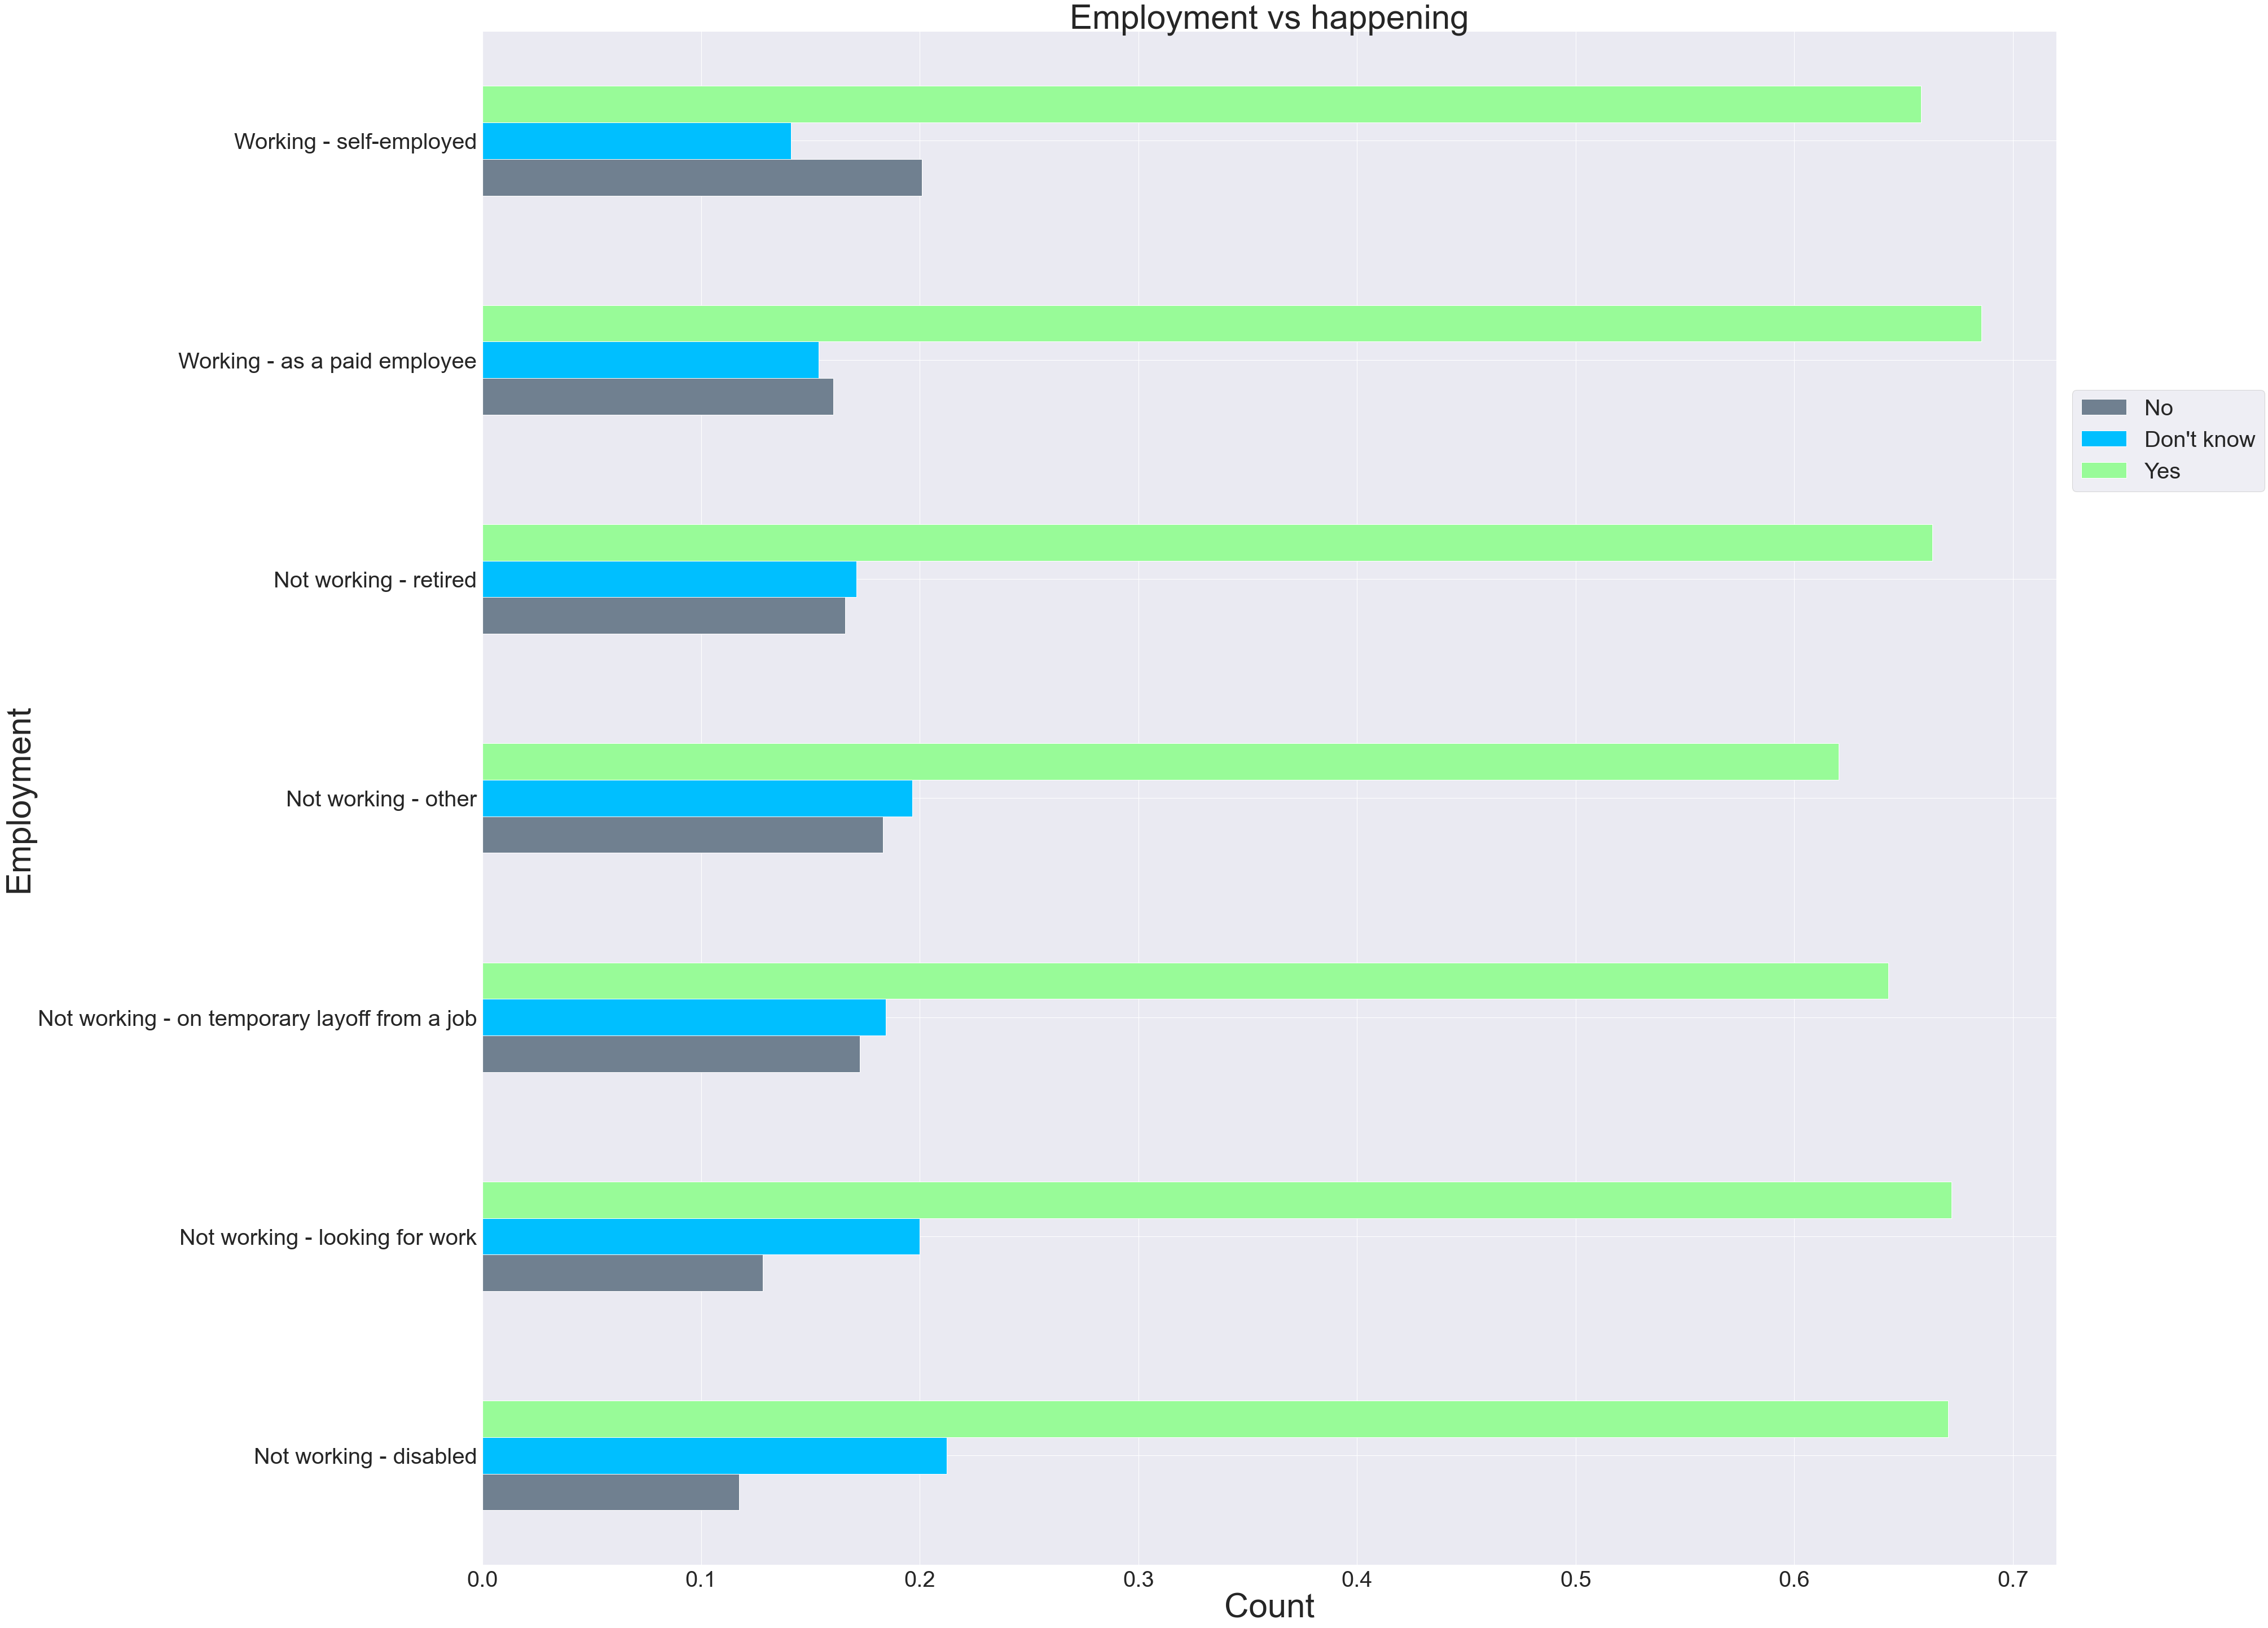

In [196]:
ax = df.groupby('employment')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Employment',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Employment vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` across various employments.Seems like Retired people have a higher proportion of people not accepting climate change**

In [197]:
df.house_head.value_counts(normalize=True)

Head of household        0.828485
Not head of household    0.171515
Name: house_head, dtype: float64

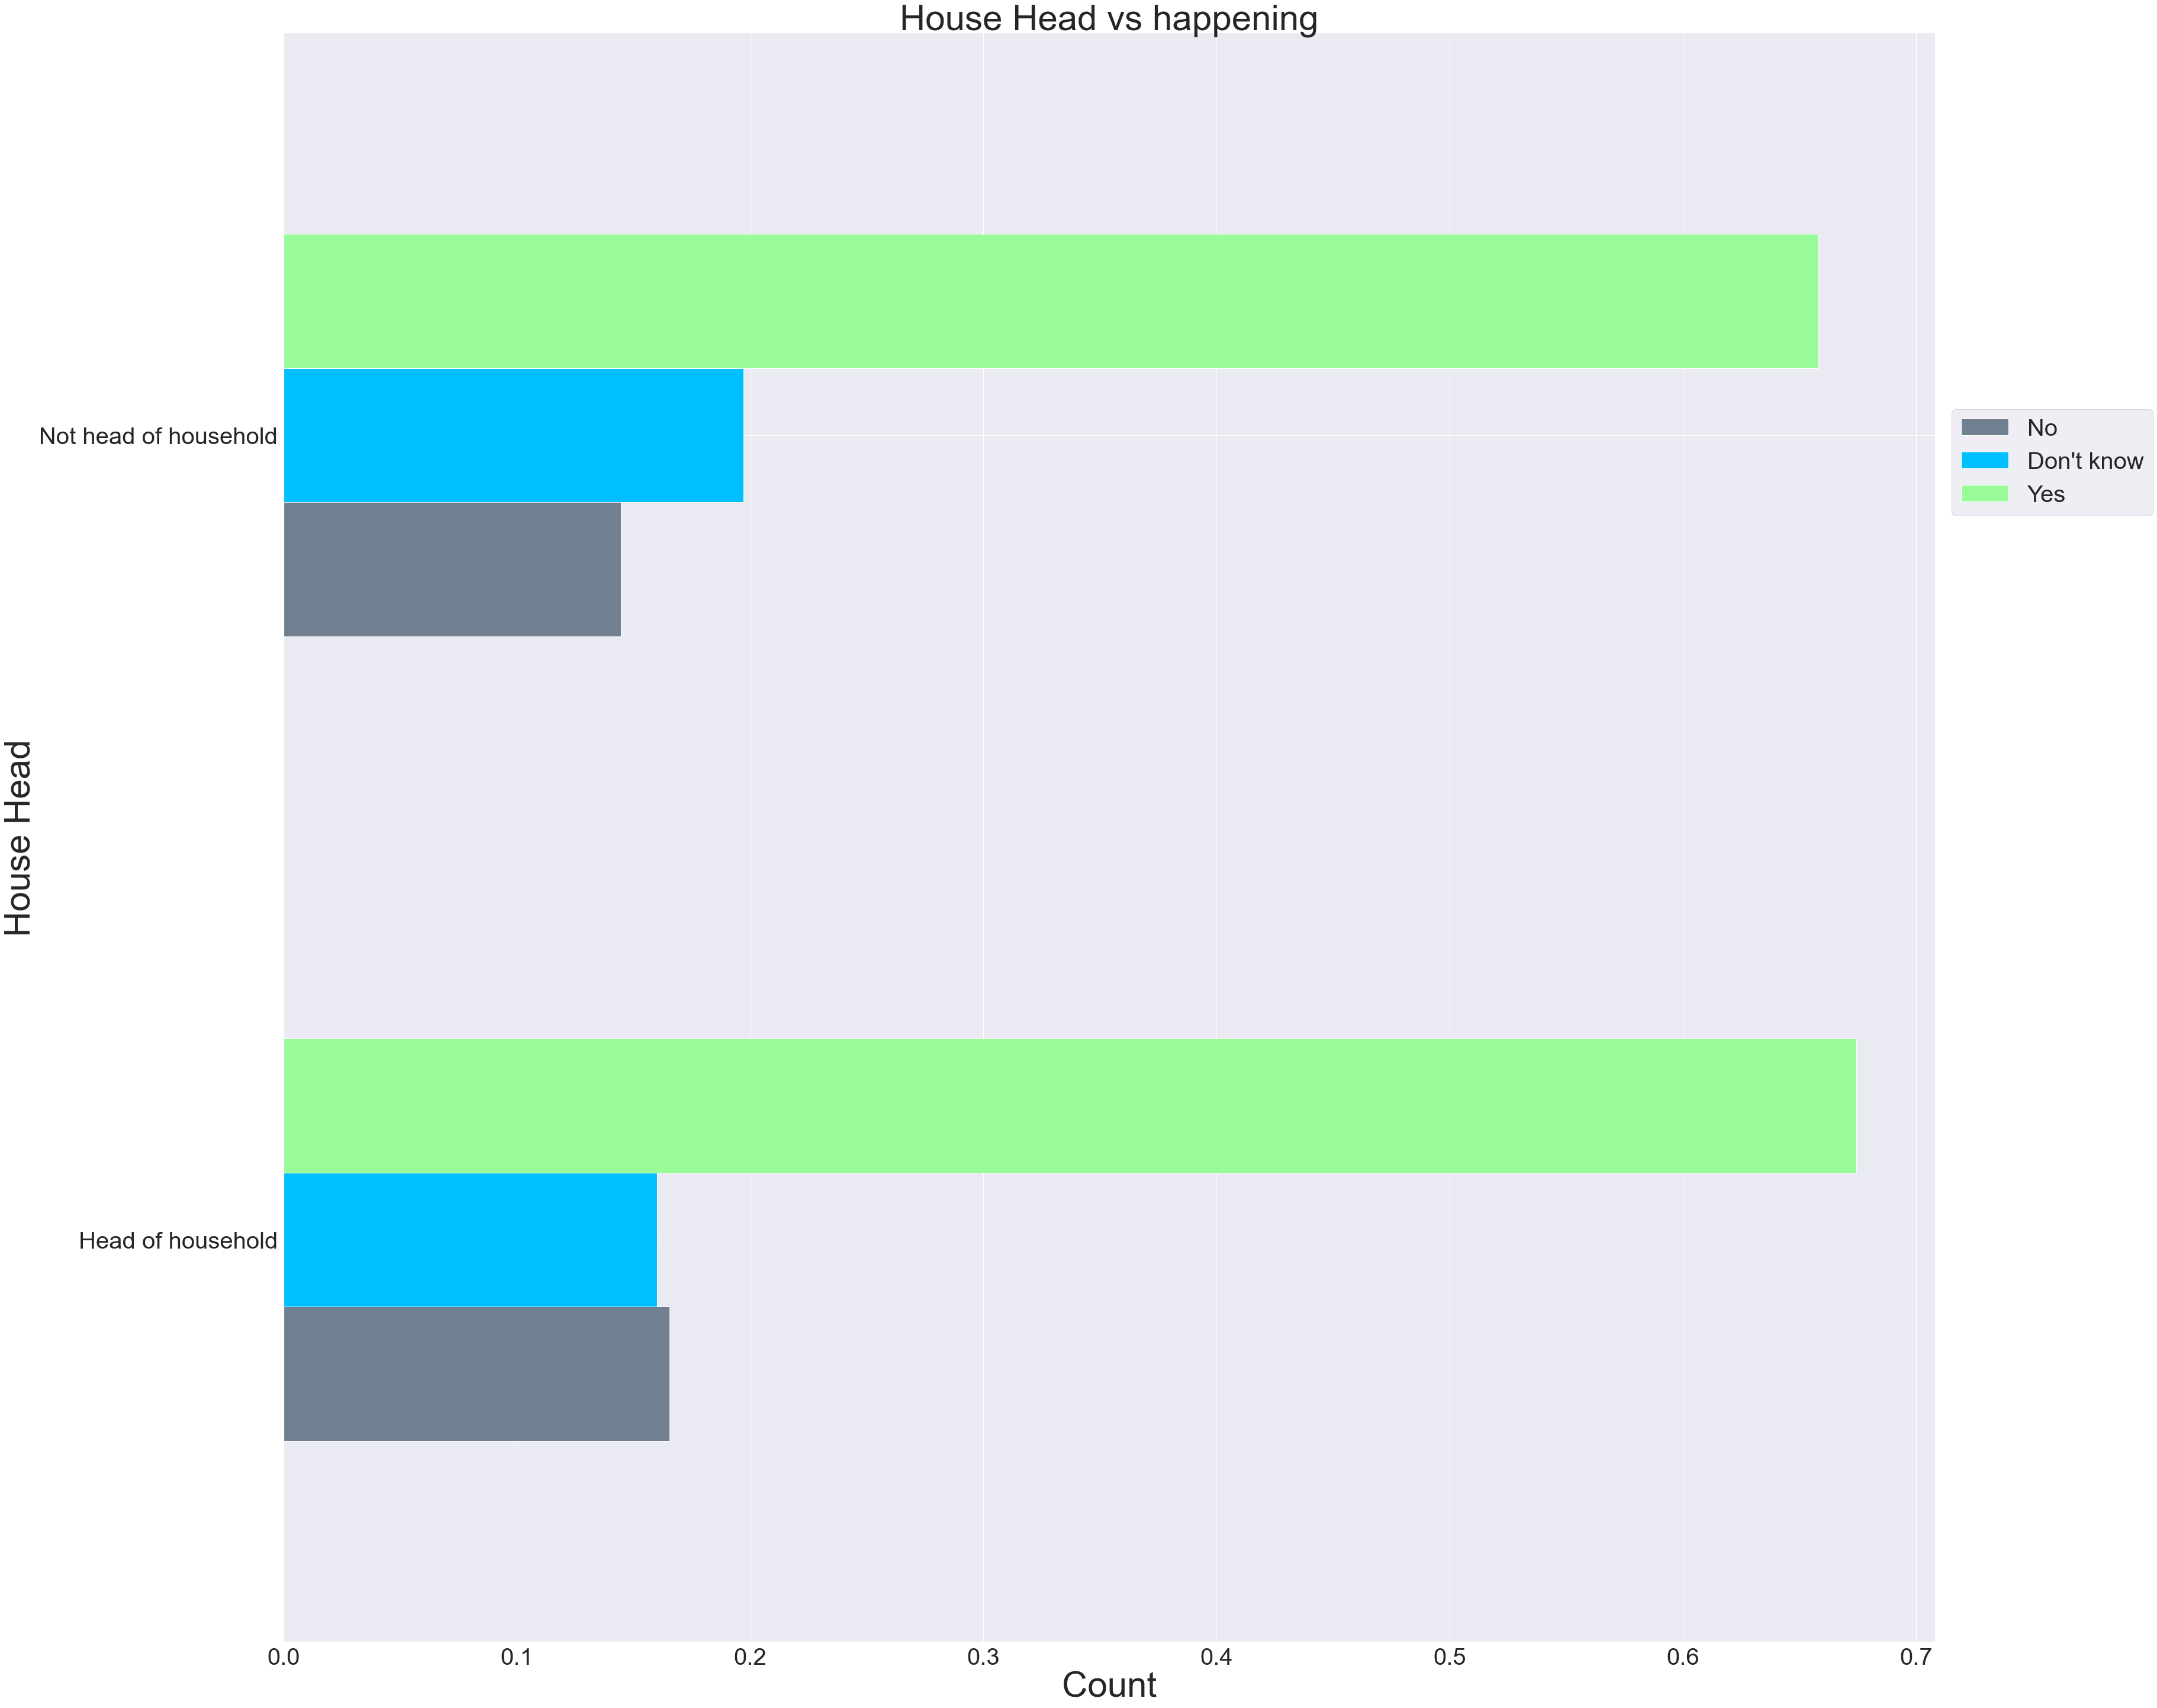

In [198]:
ax = df.groupby('house_head')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Head',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Head vs happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` vs house heads status. Majority of those surveyed seem to own a household**

In [199]:
df.house_size.value_counts(normalize=True)

2.0     0.391145
1.0     0.190816
3.0     0.165615
4.0     0.141877
5.0     0.066182
6.0     0.025979
7.0     0.009468
8.0     0.004711
9.0     0.001829
10.0    0.001647
12.0    0.000595
15.0    0.000091
11.0    0.000046
Name: house_size, dtype: float64

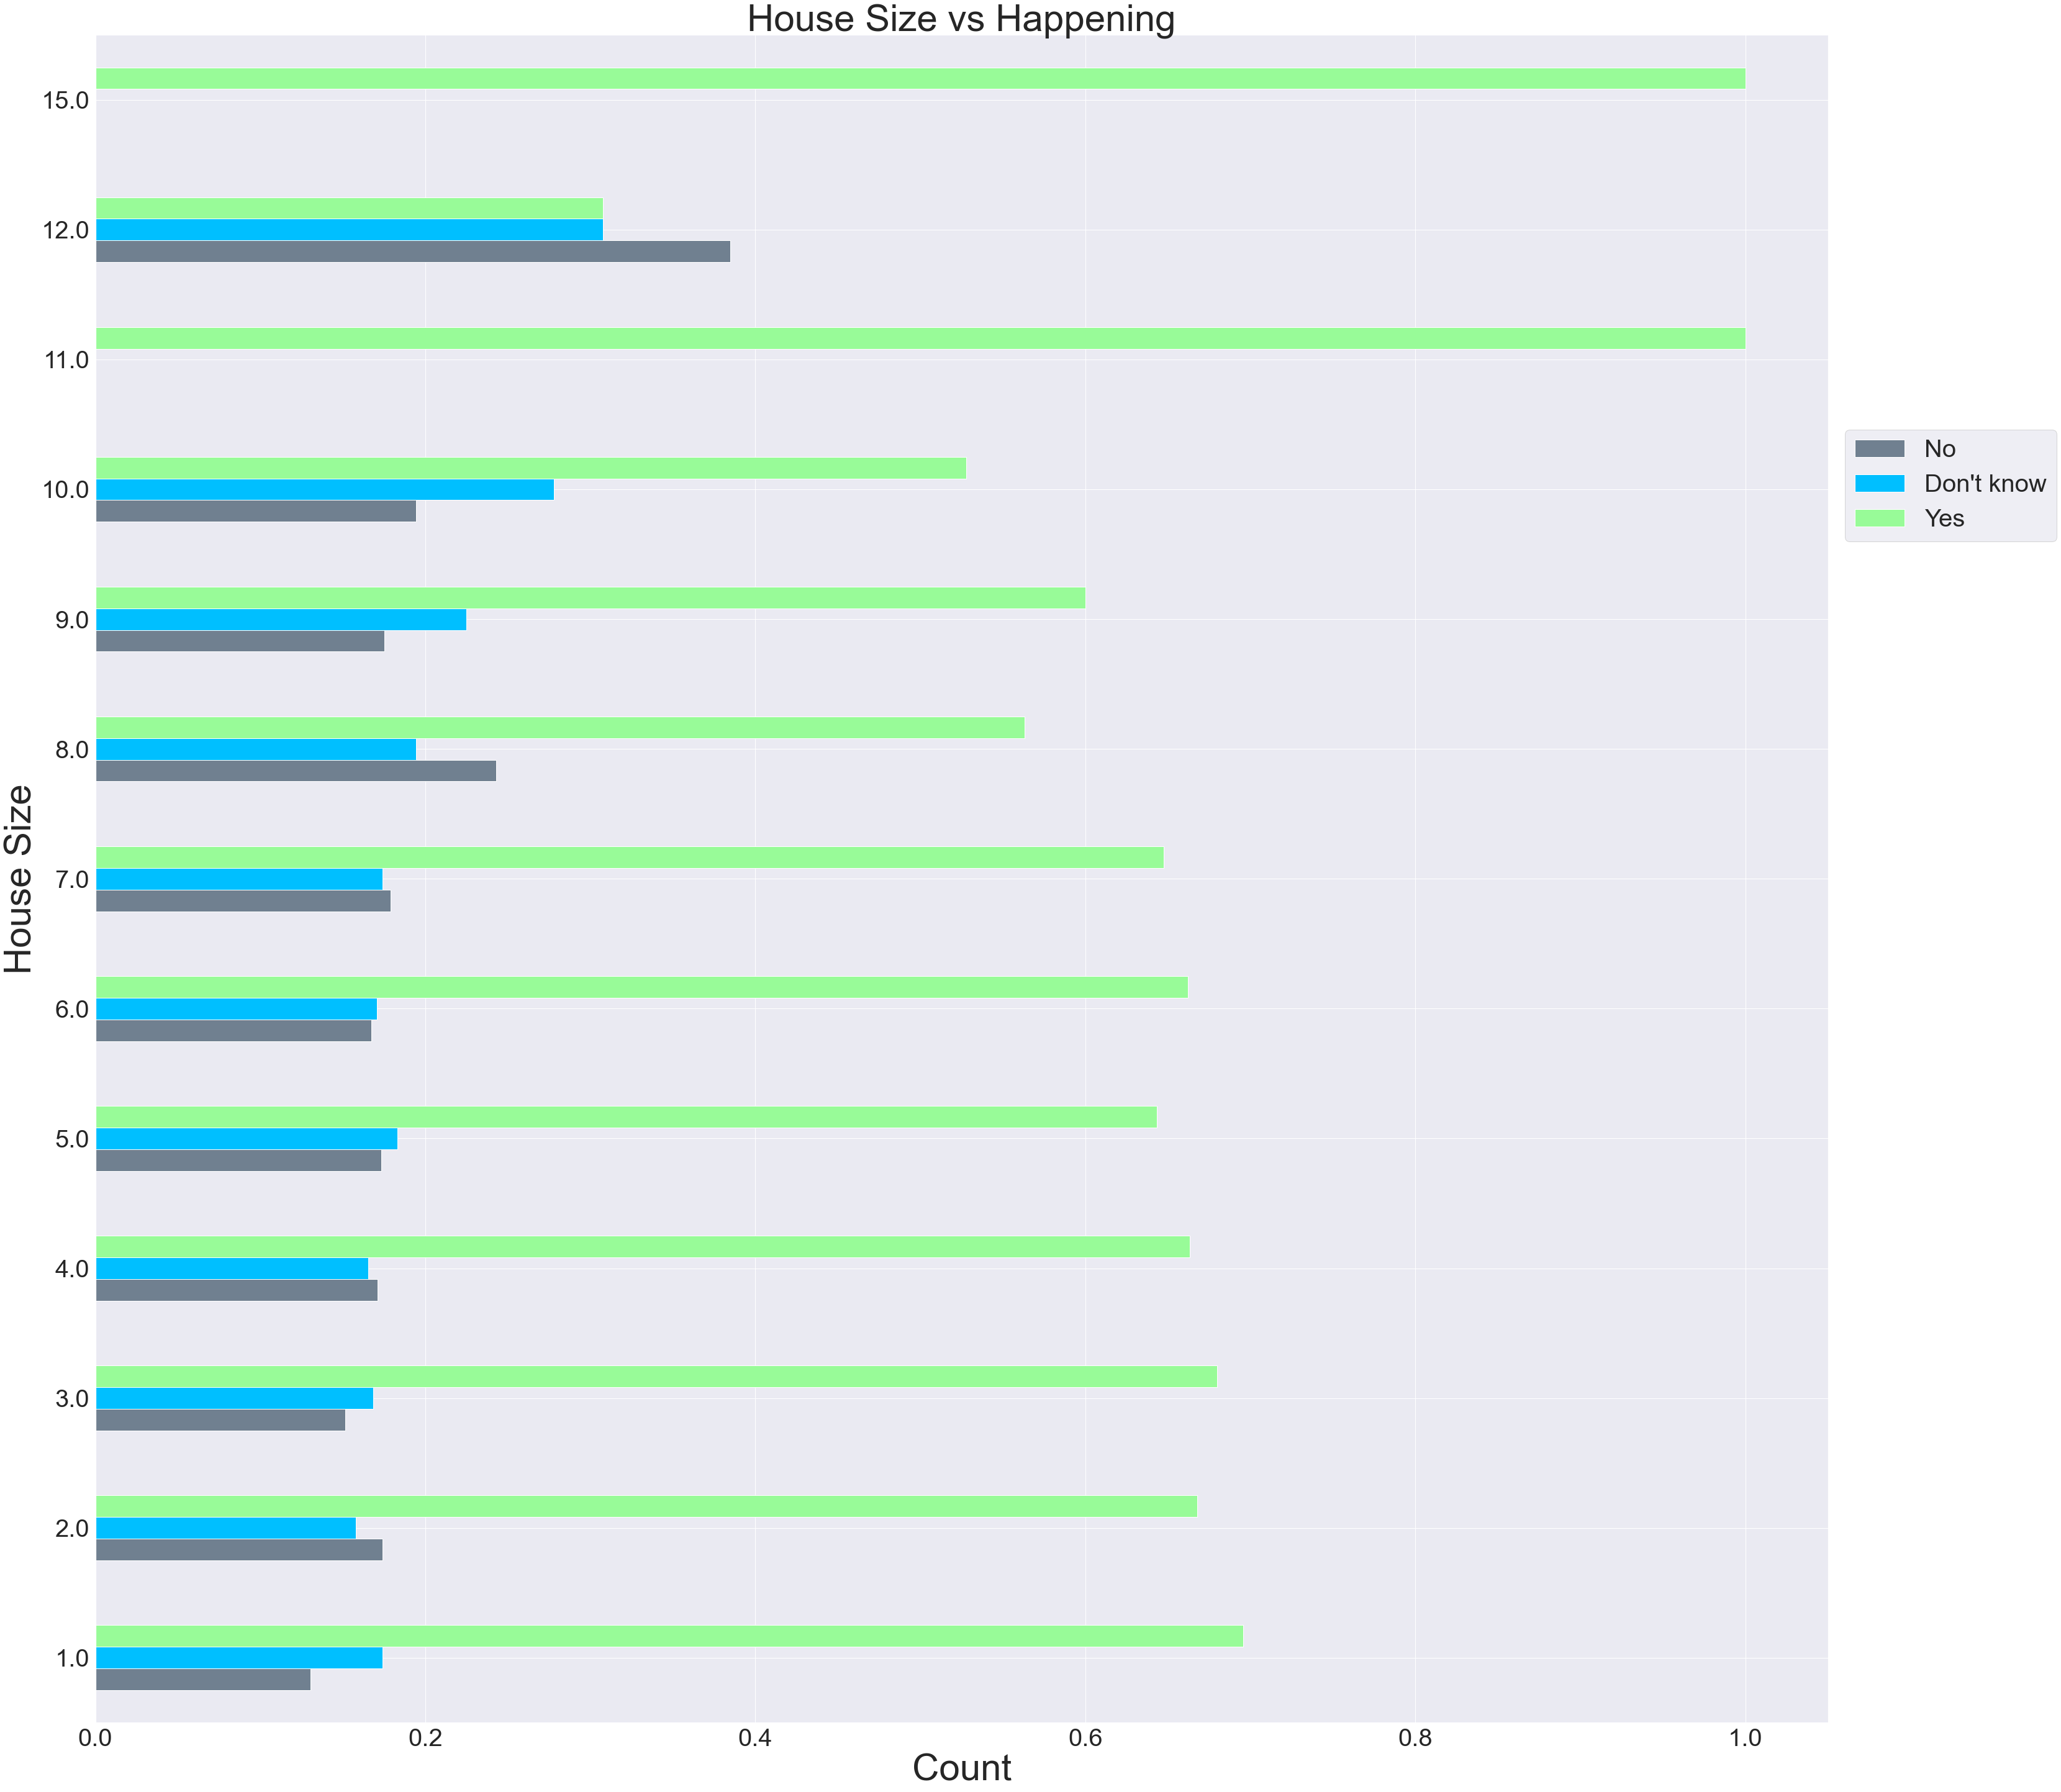

In [200]:
ax = df.groupby('house_size')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Size',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Size vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


**This graph represents the distribution of`happening` vs house size.** 

In [201]:
df.house_ages0to1.value_counts(normalize=True)

0.0    0.961764
1.0    0.035675
2.0    0.001967
3.0    0.000229
4.0    0.000229
6.0    0.000091
7.0    0.000046
Name: house_ages0to1, dtype: float64

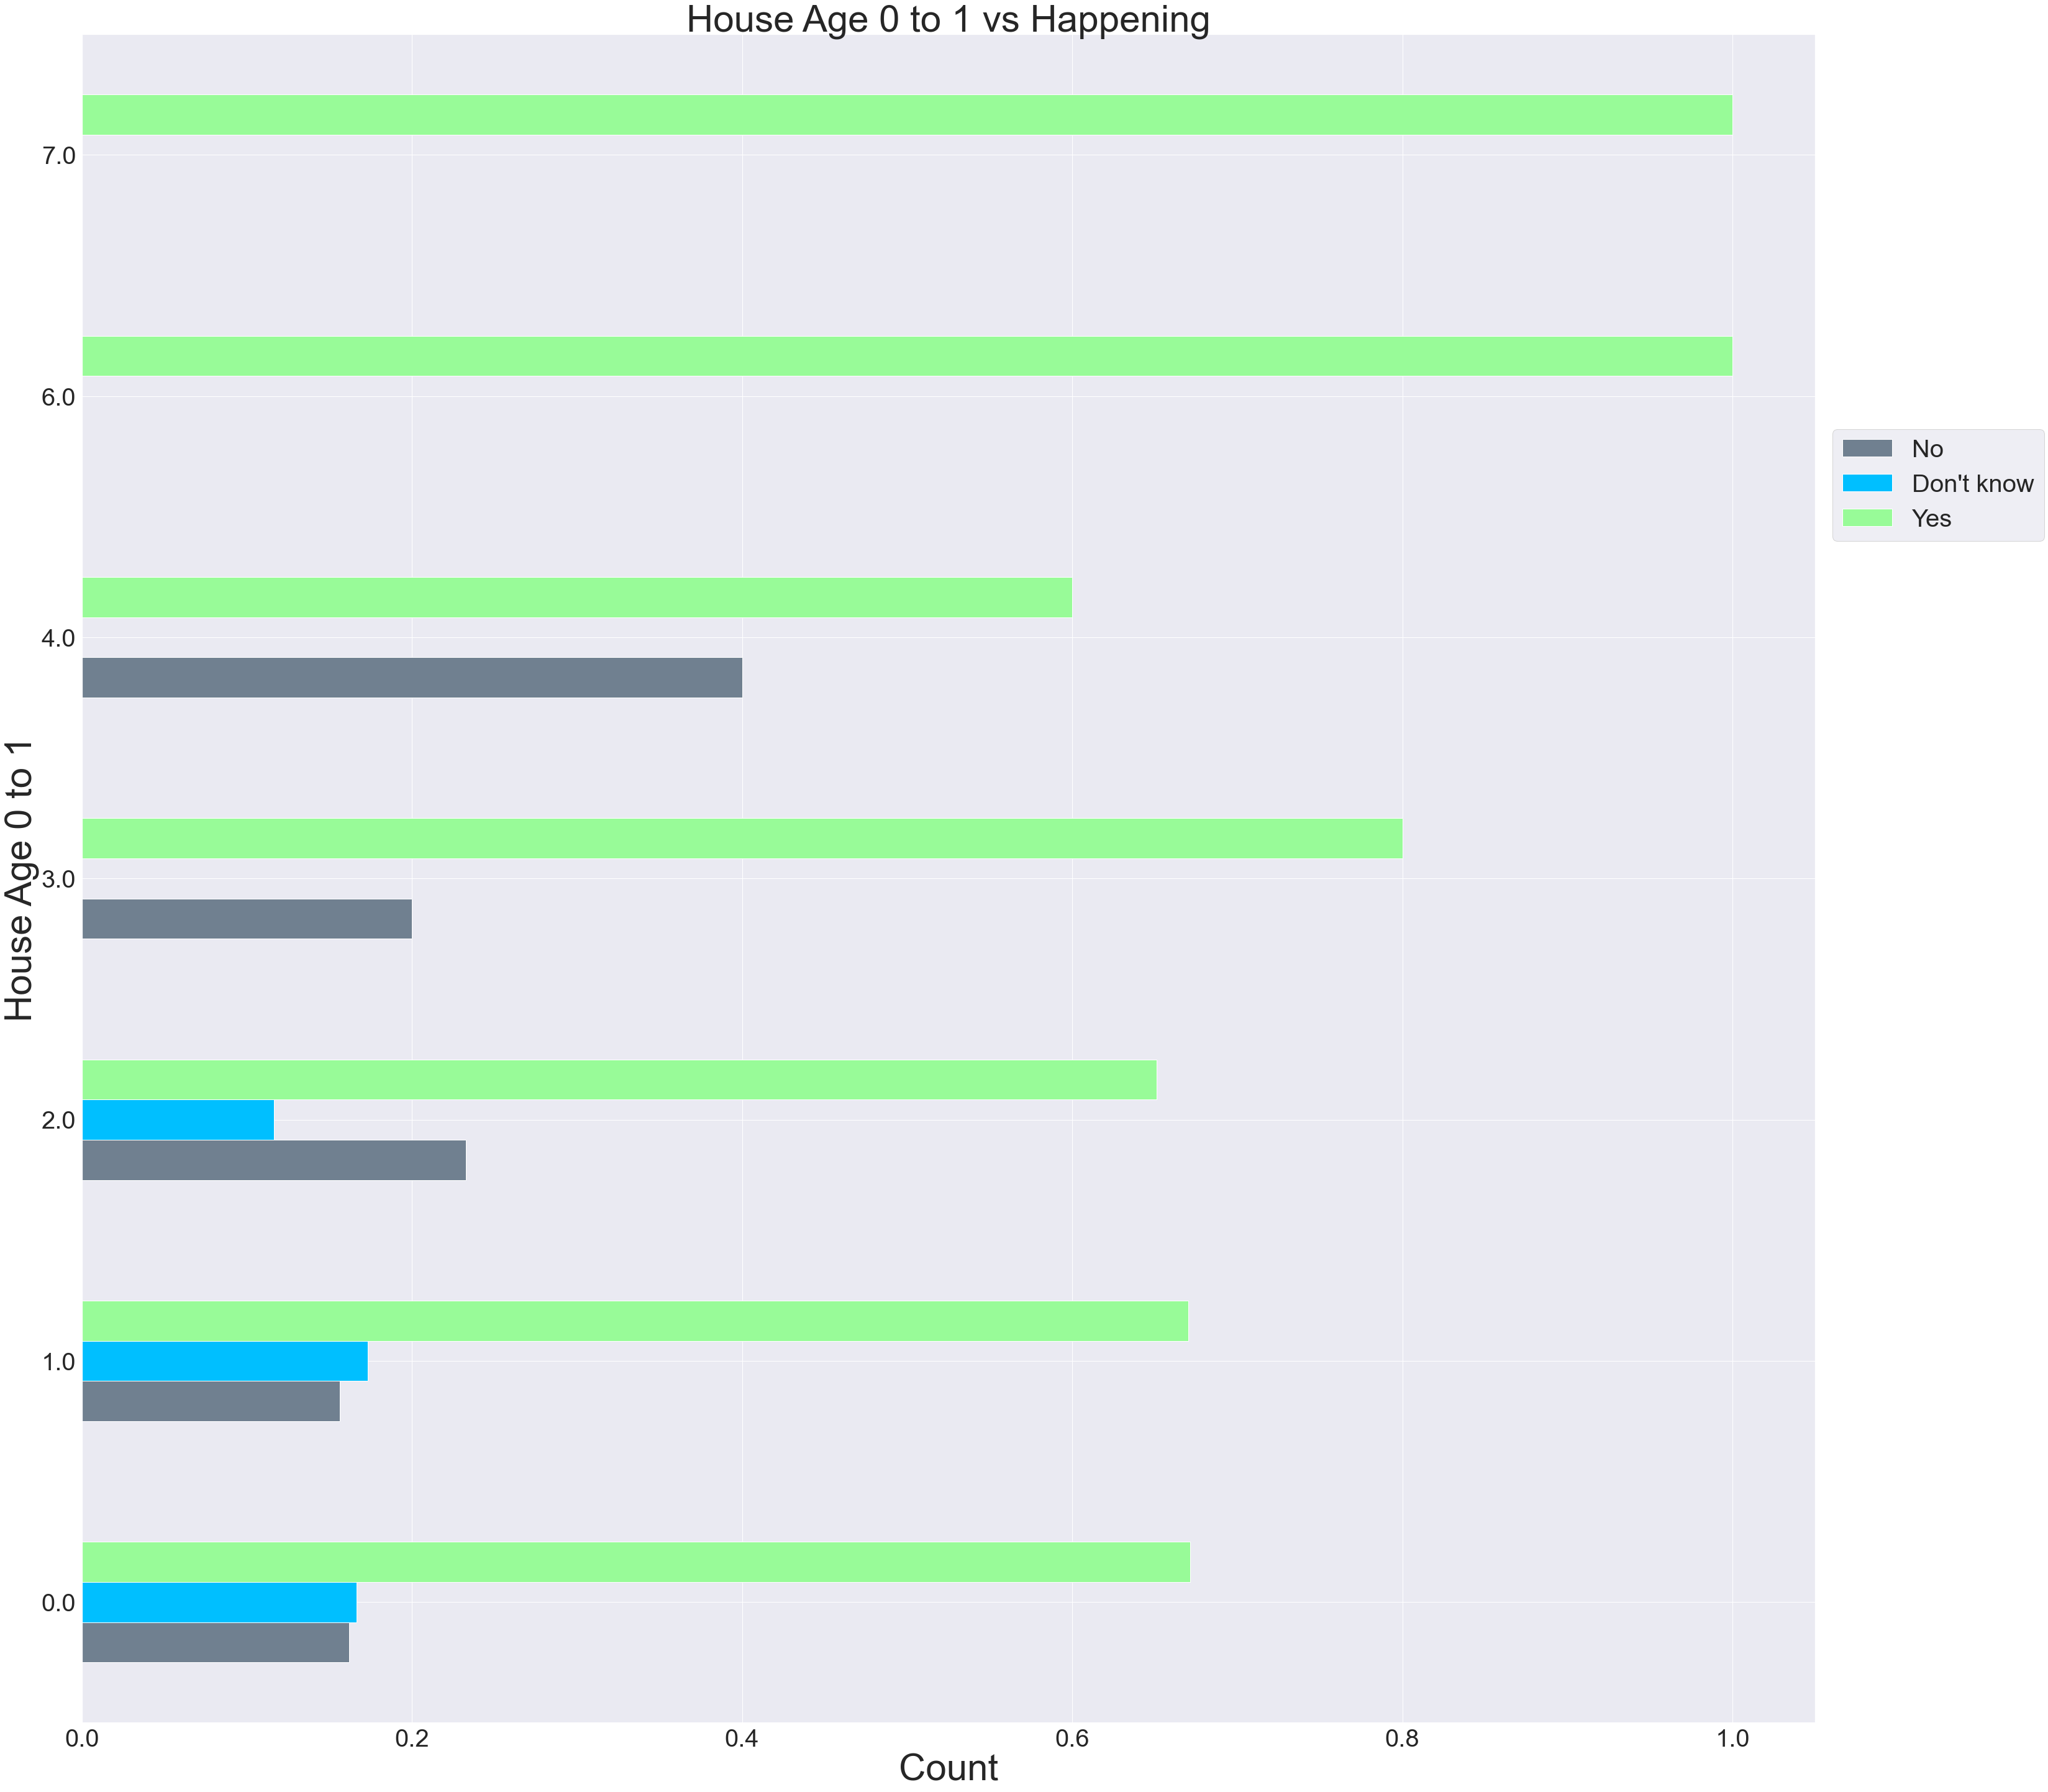

In [202]:
ax = df.groupby('house_ages0to1')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 0 to 1',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 0 to 1 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 0 to 1.**
- **0 is the dominant group** 

In [203]:
df.house_ages2to5.value_counts(normalize=True)

0.0    0.912825
1.0    0.069201
2.0    0.016740
3.0    0.001098
4.0    0.000137
Name: house_ages2to5, dtype: float64

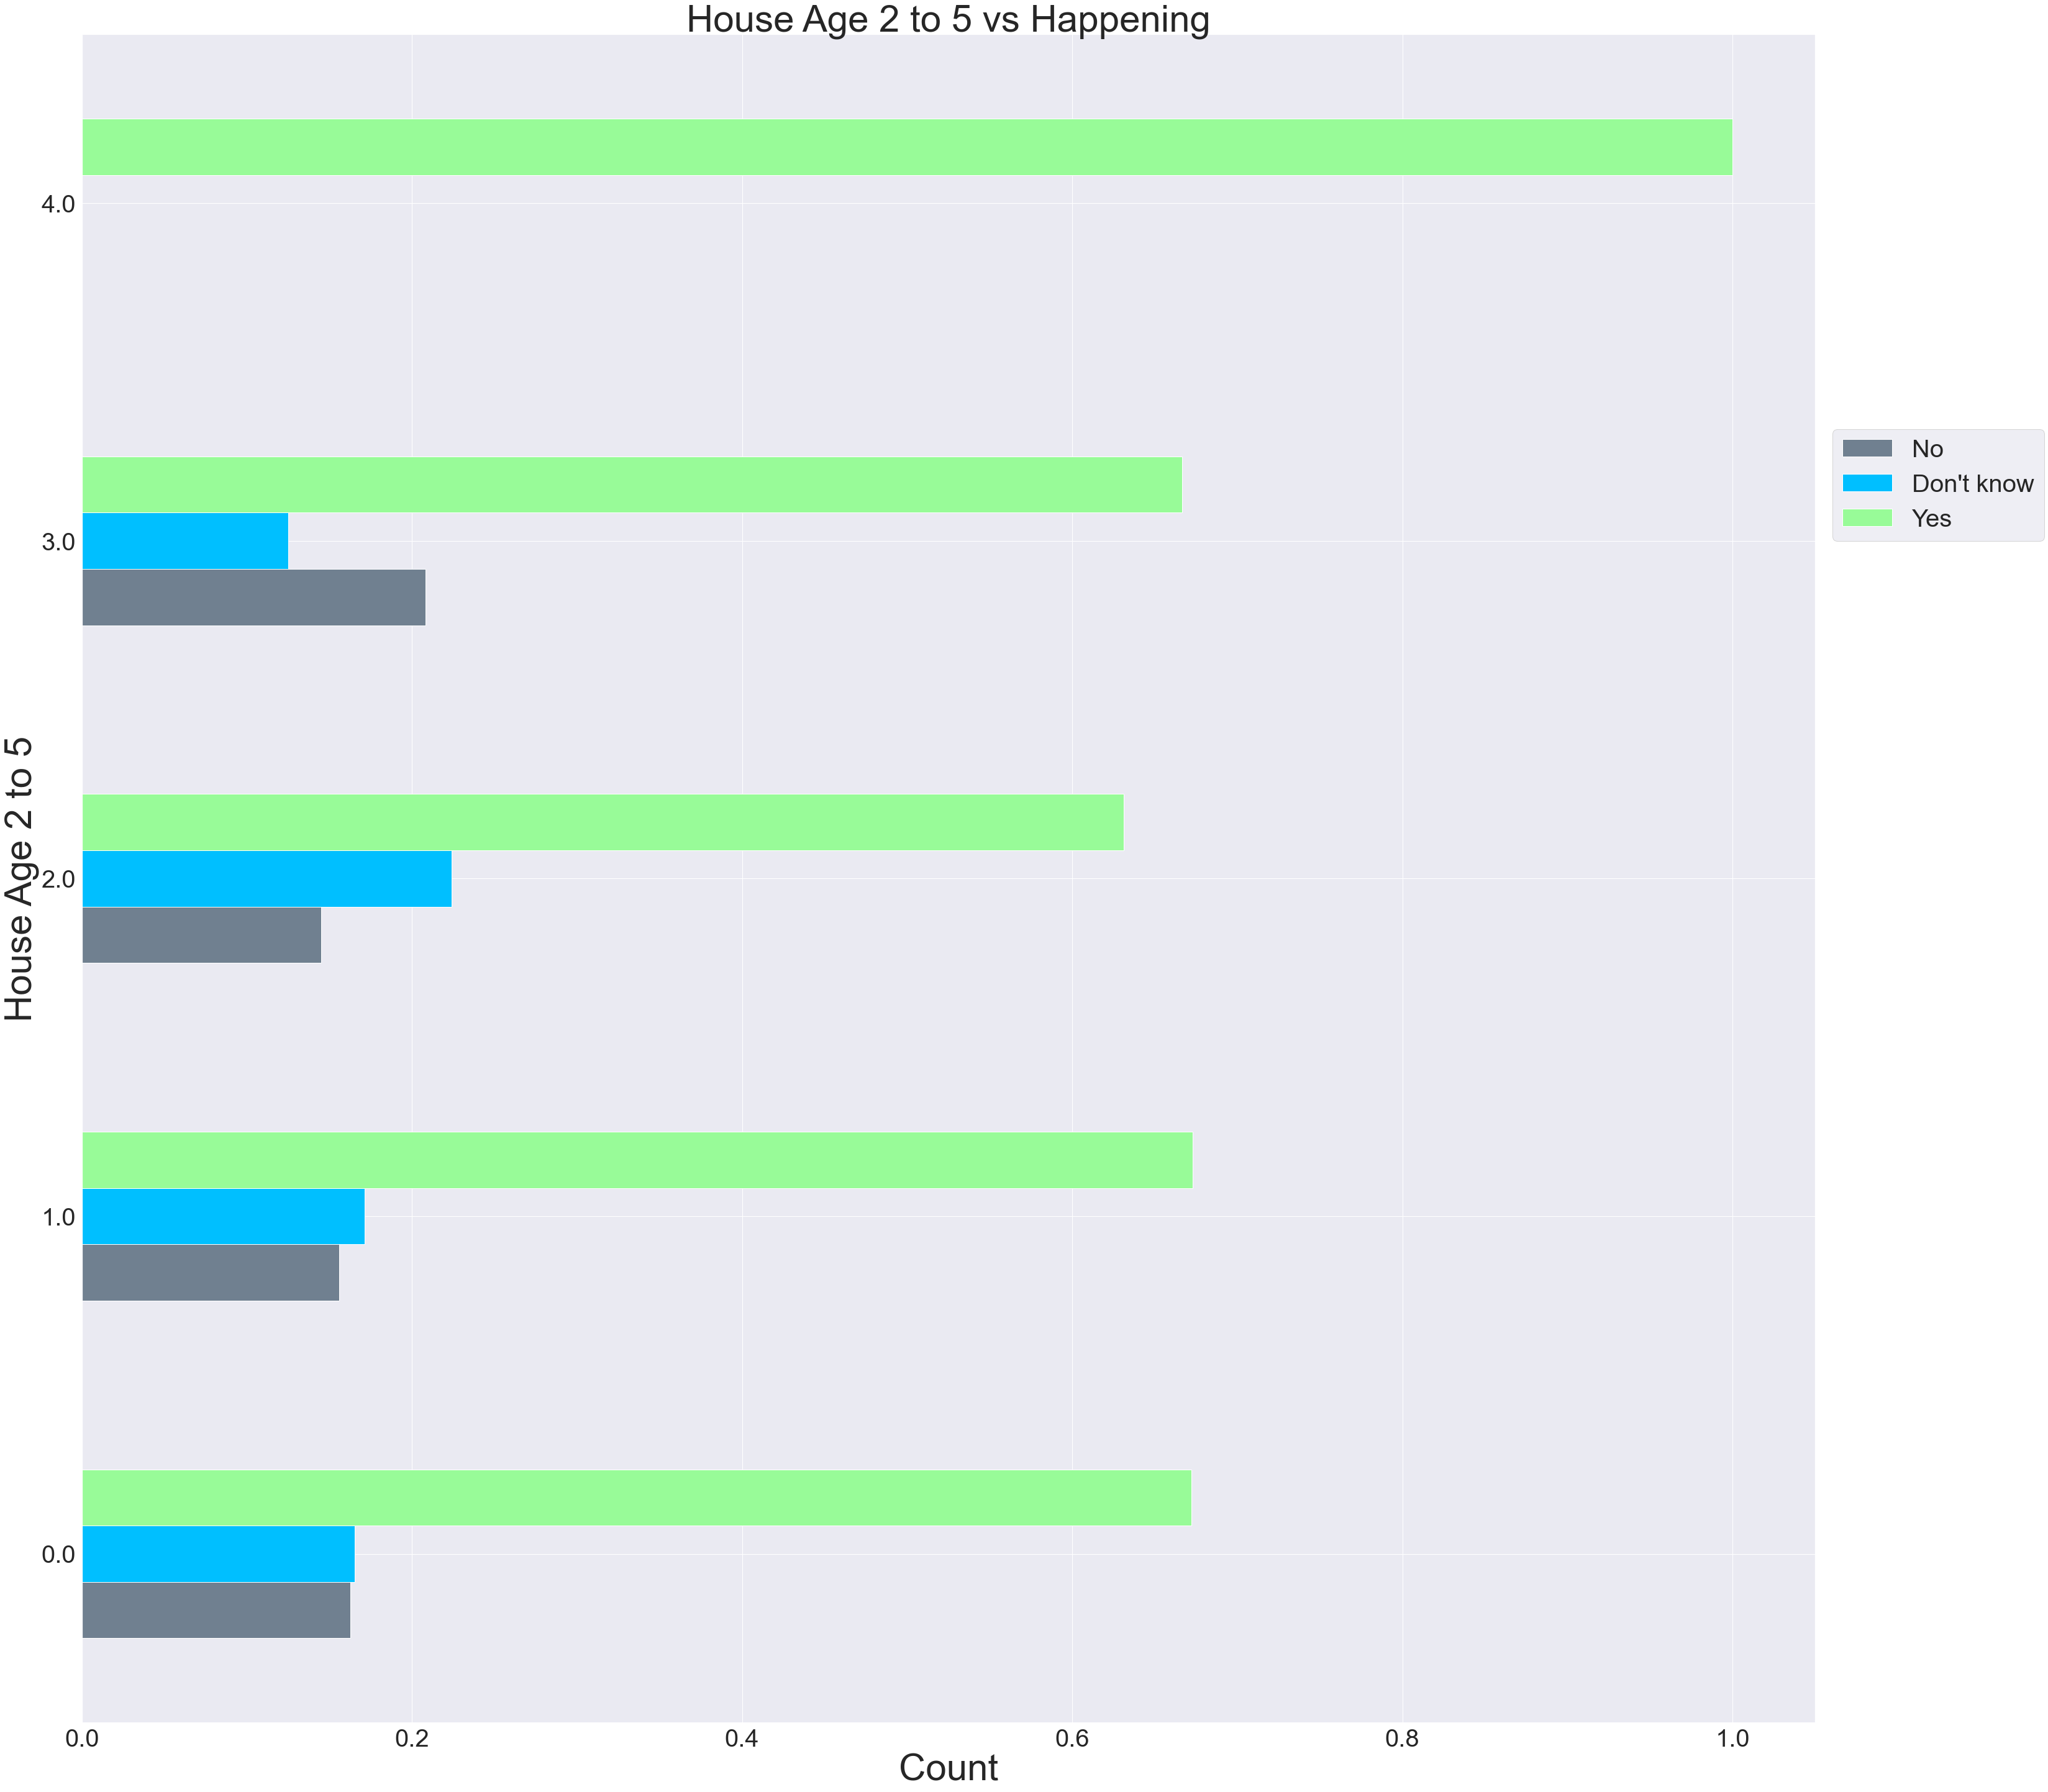

In [204]:
ax = df.groupby('house_ages2to5')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 2 to 5',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 2 to 5 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 2 to 5.**
- **0 is the dominant group** 

In [205]:
df.house_ages6to12.value_counts(normalize=True)

0.0    0.856614
1.0    0.093944
2.0    0.039746
3.0    0.008095
4.0    0.001418
5.0    0.000091
6.0    0.000091
Name: house_ages6to12, dtype: float64

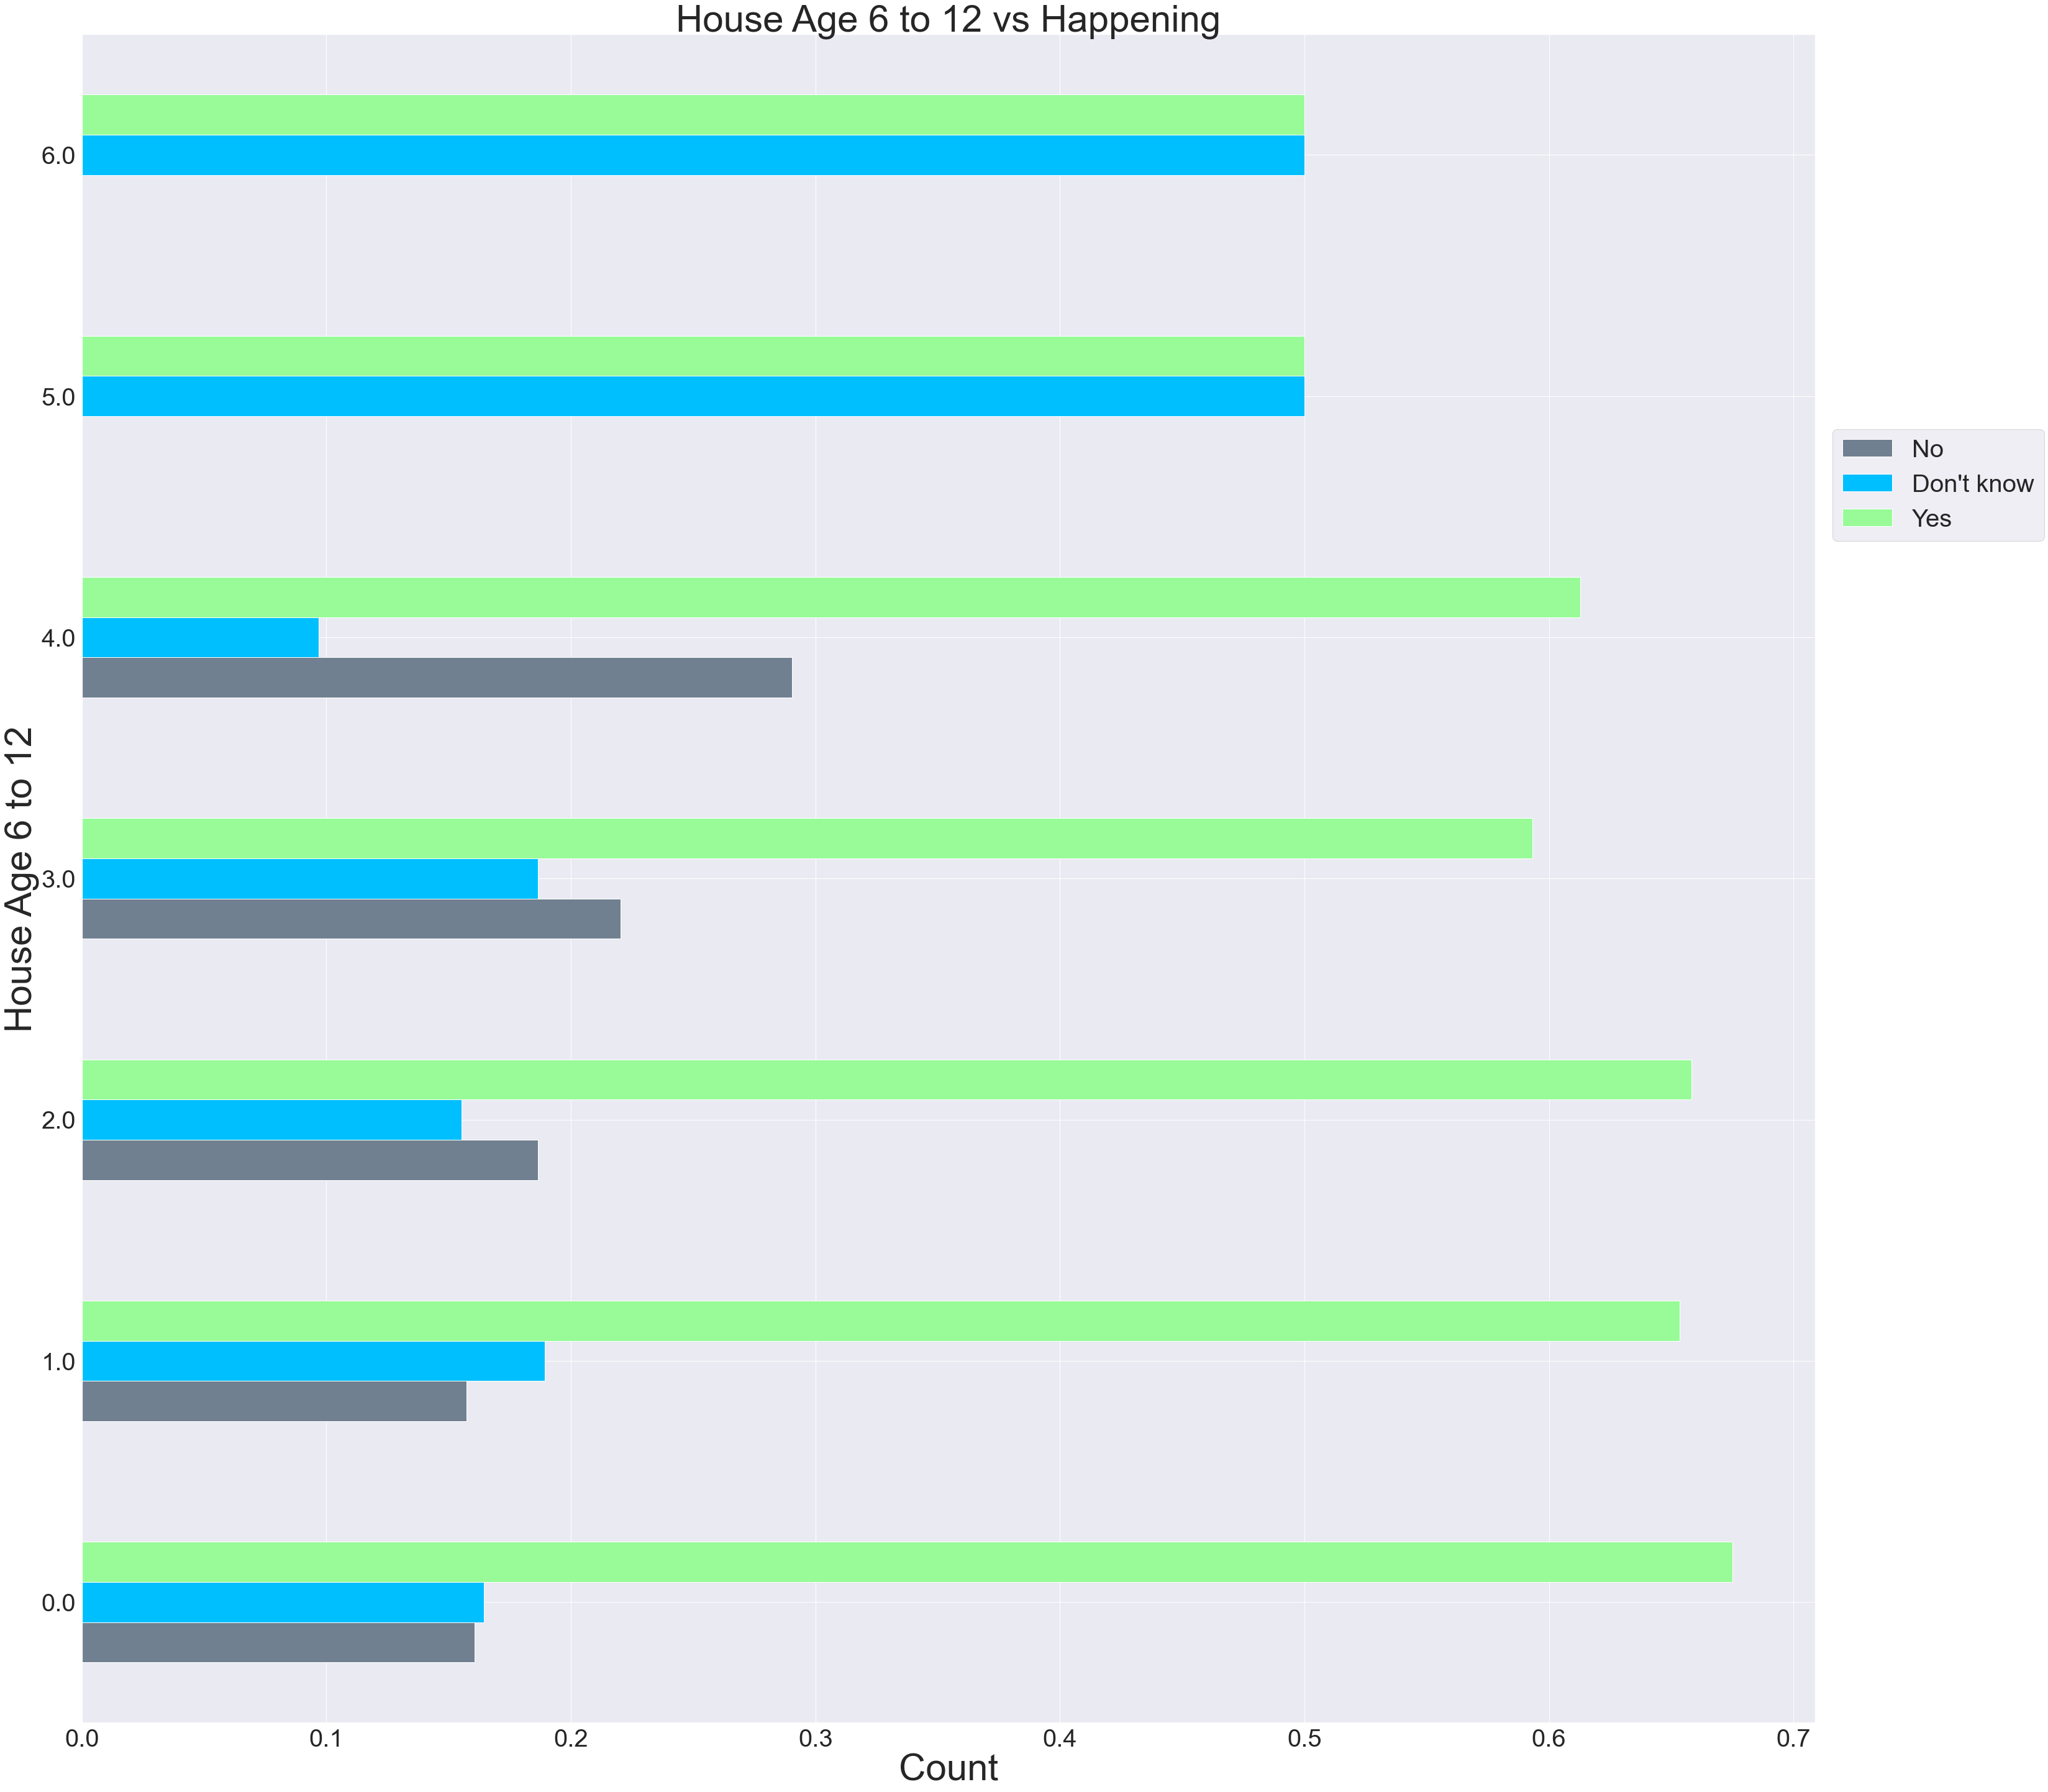

In [206]:
ax = df.groupby('house_ages6to12')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 6 to 12',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 6 to 12 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 6 to 12.** 
- **0 is the dominant group** 


In [207]:
df.house_ages13to17.value_counts(normalize=True)

0.0    0.854464
1.0    0.109358
2.0    0.031467
3.0    0.004071
4.0    0.000640
Name: house_ages13to17, dtype: float64

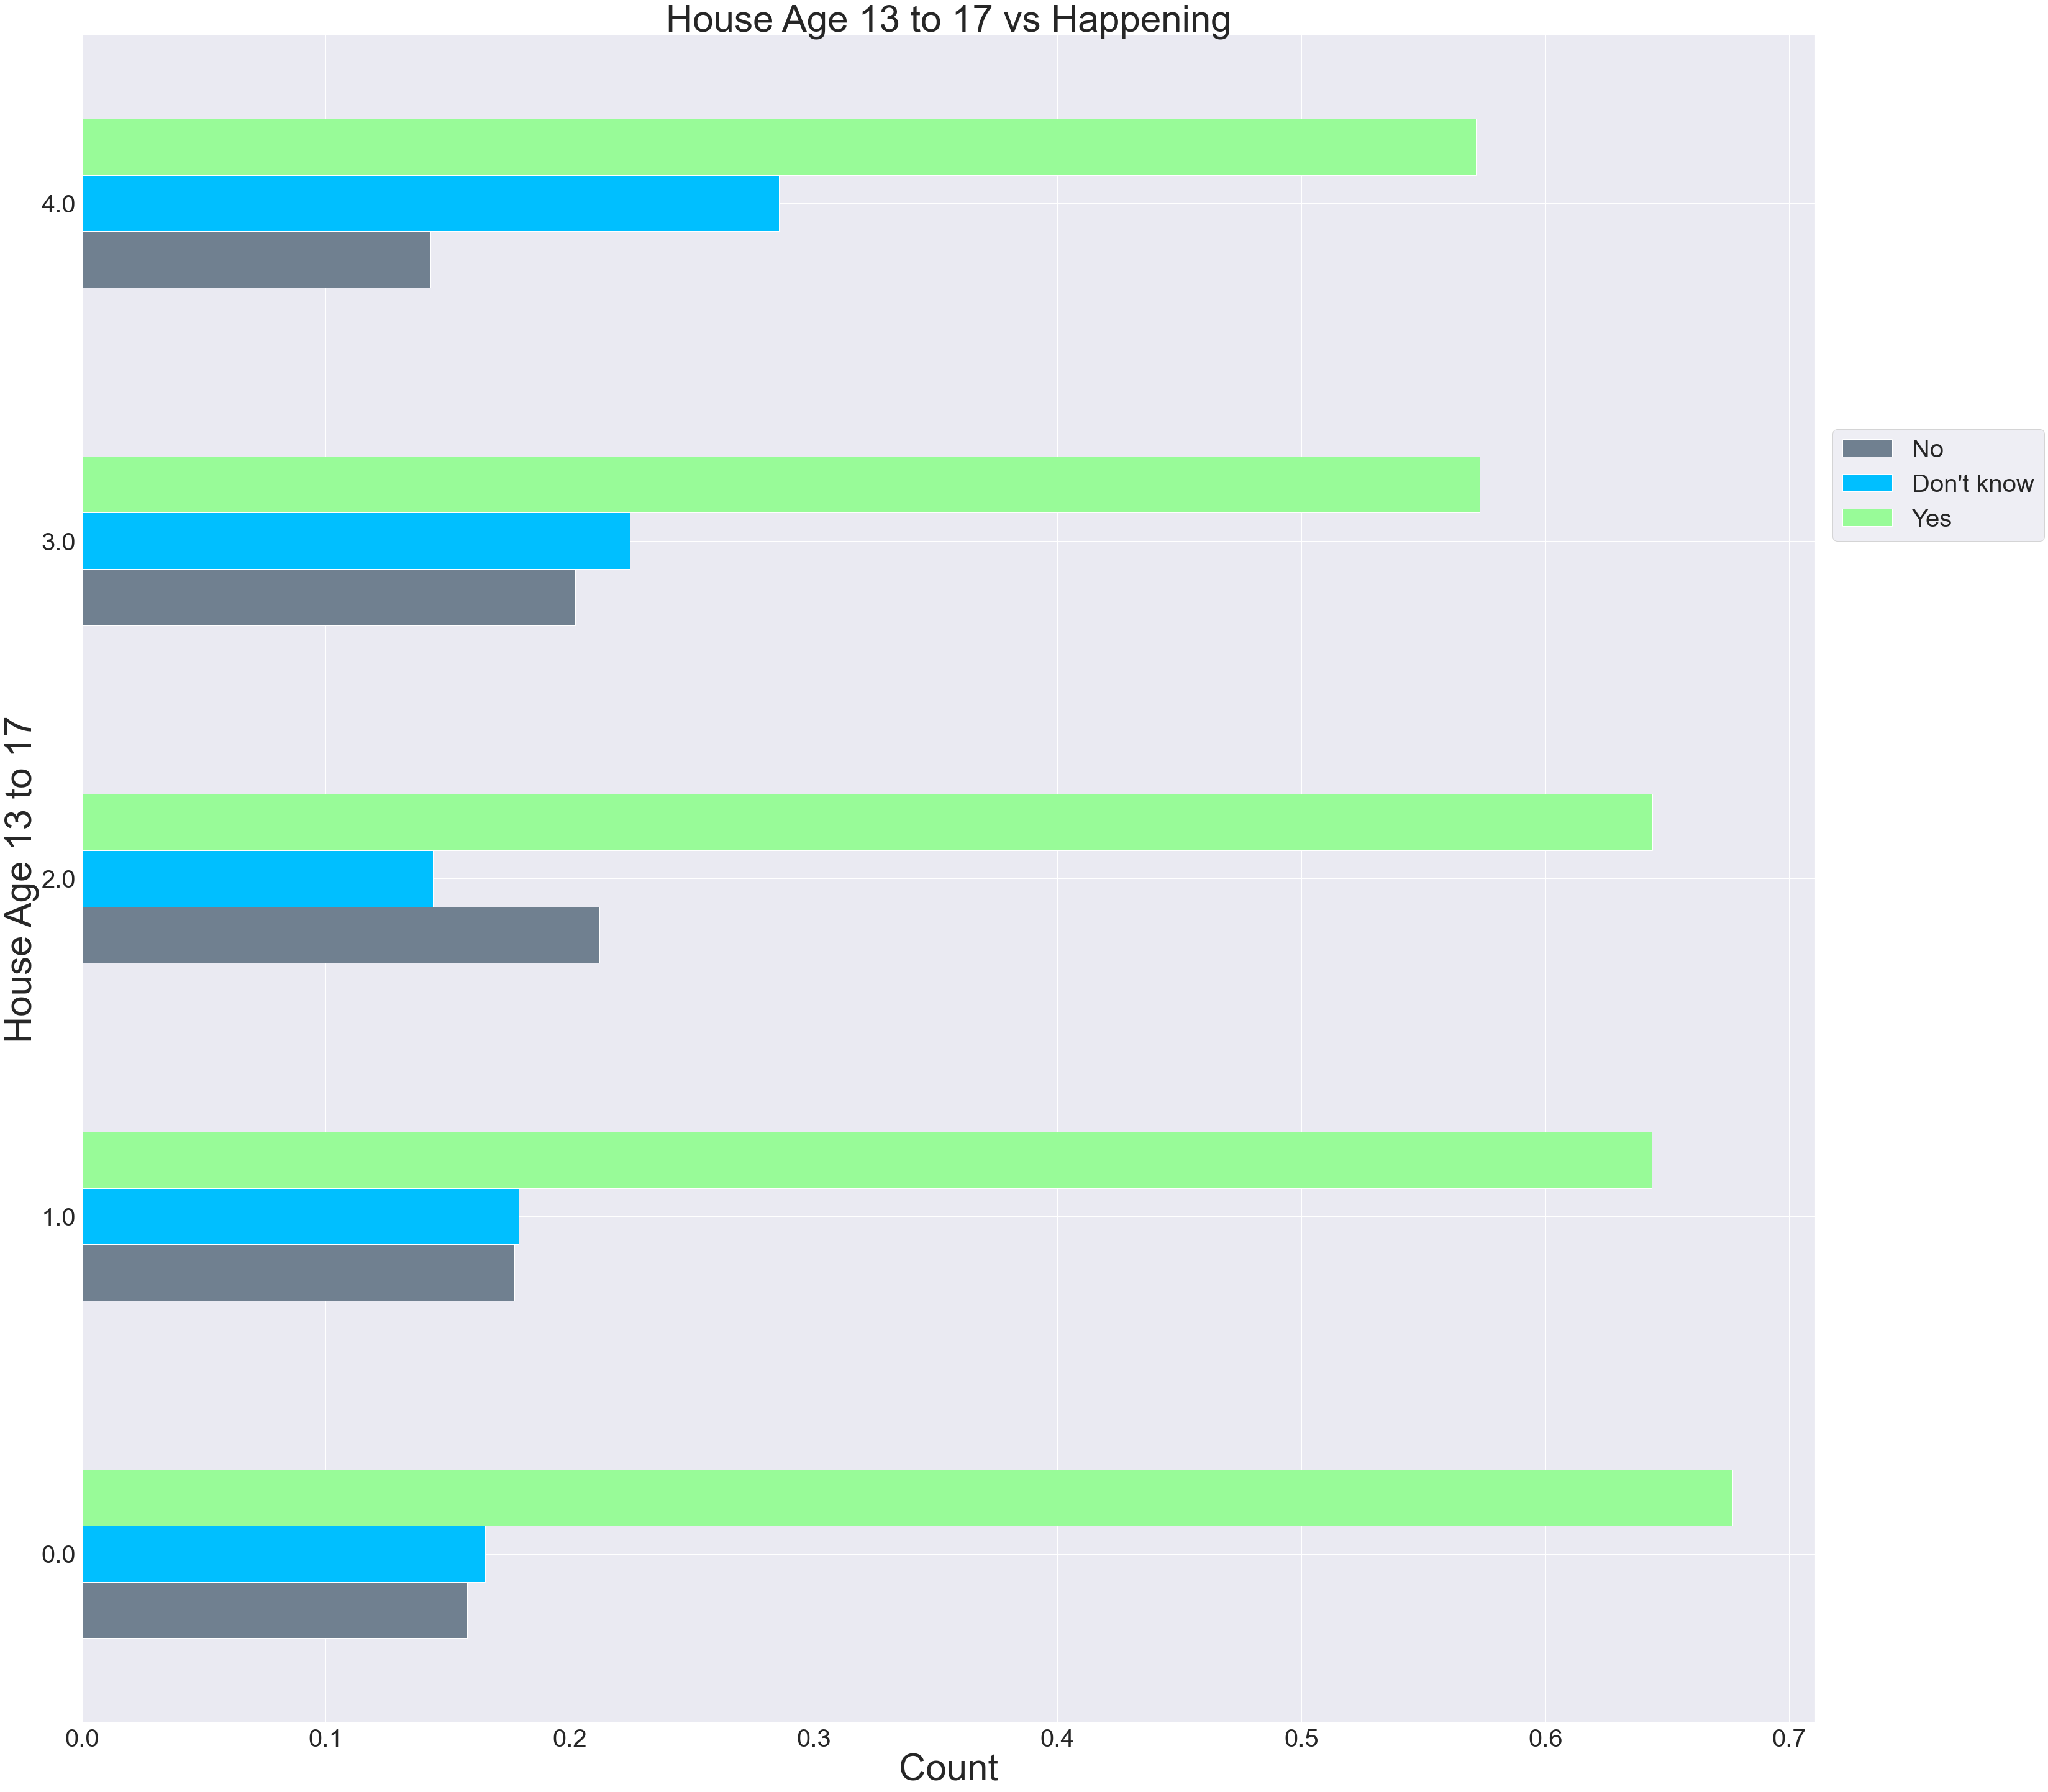

In [208]:
ax = df.groupby('house_ages13to17')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 13 to 17',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 13 to 17 vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 13 to 17.** 
- **0 is the dominant group** 


In [209]:
df.house_ages18plus.value_counts(normalize=True)

2.0     0.557080
1.0     0.214874
3.0     0.147320
4.0     0.057675
5.0     0.015779
6.0     0.004116
7.0     0.002104
8.0     0.000549
12.0    0.000366
9.0     0.000091
10.0    0.000046
Name: house_ages18plus, dtype: float64

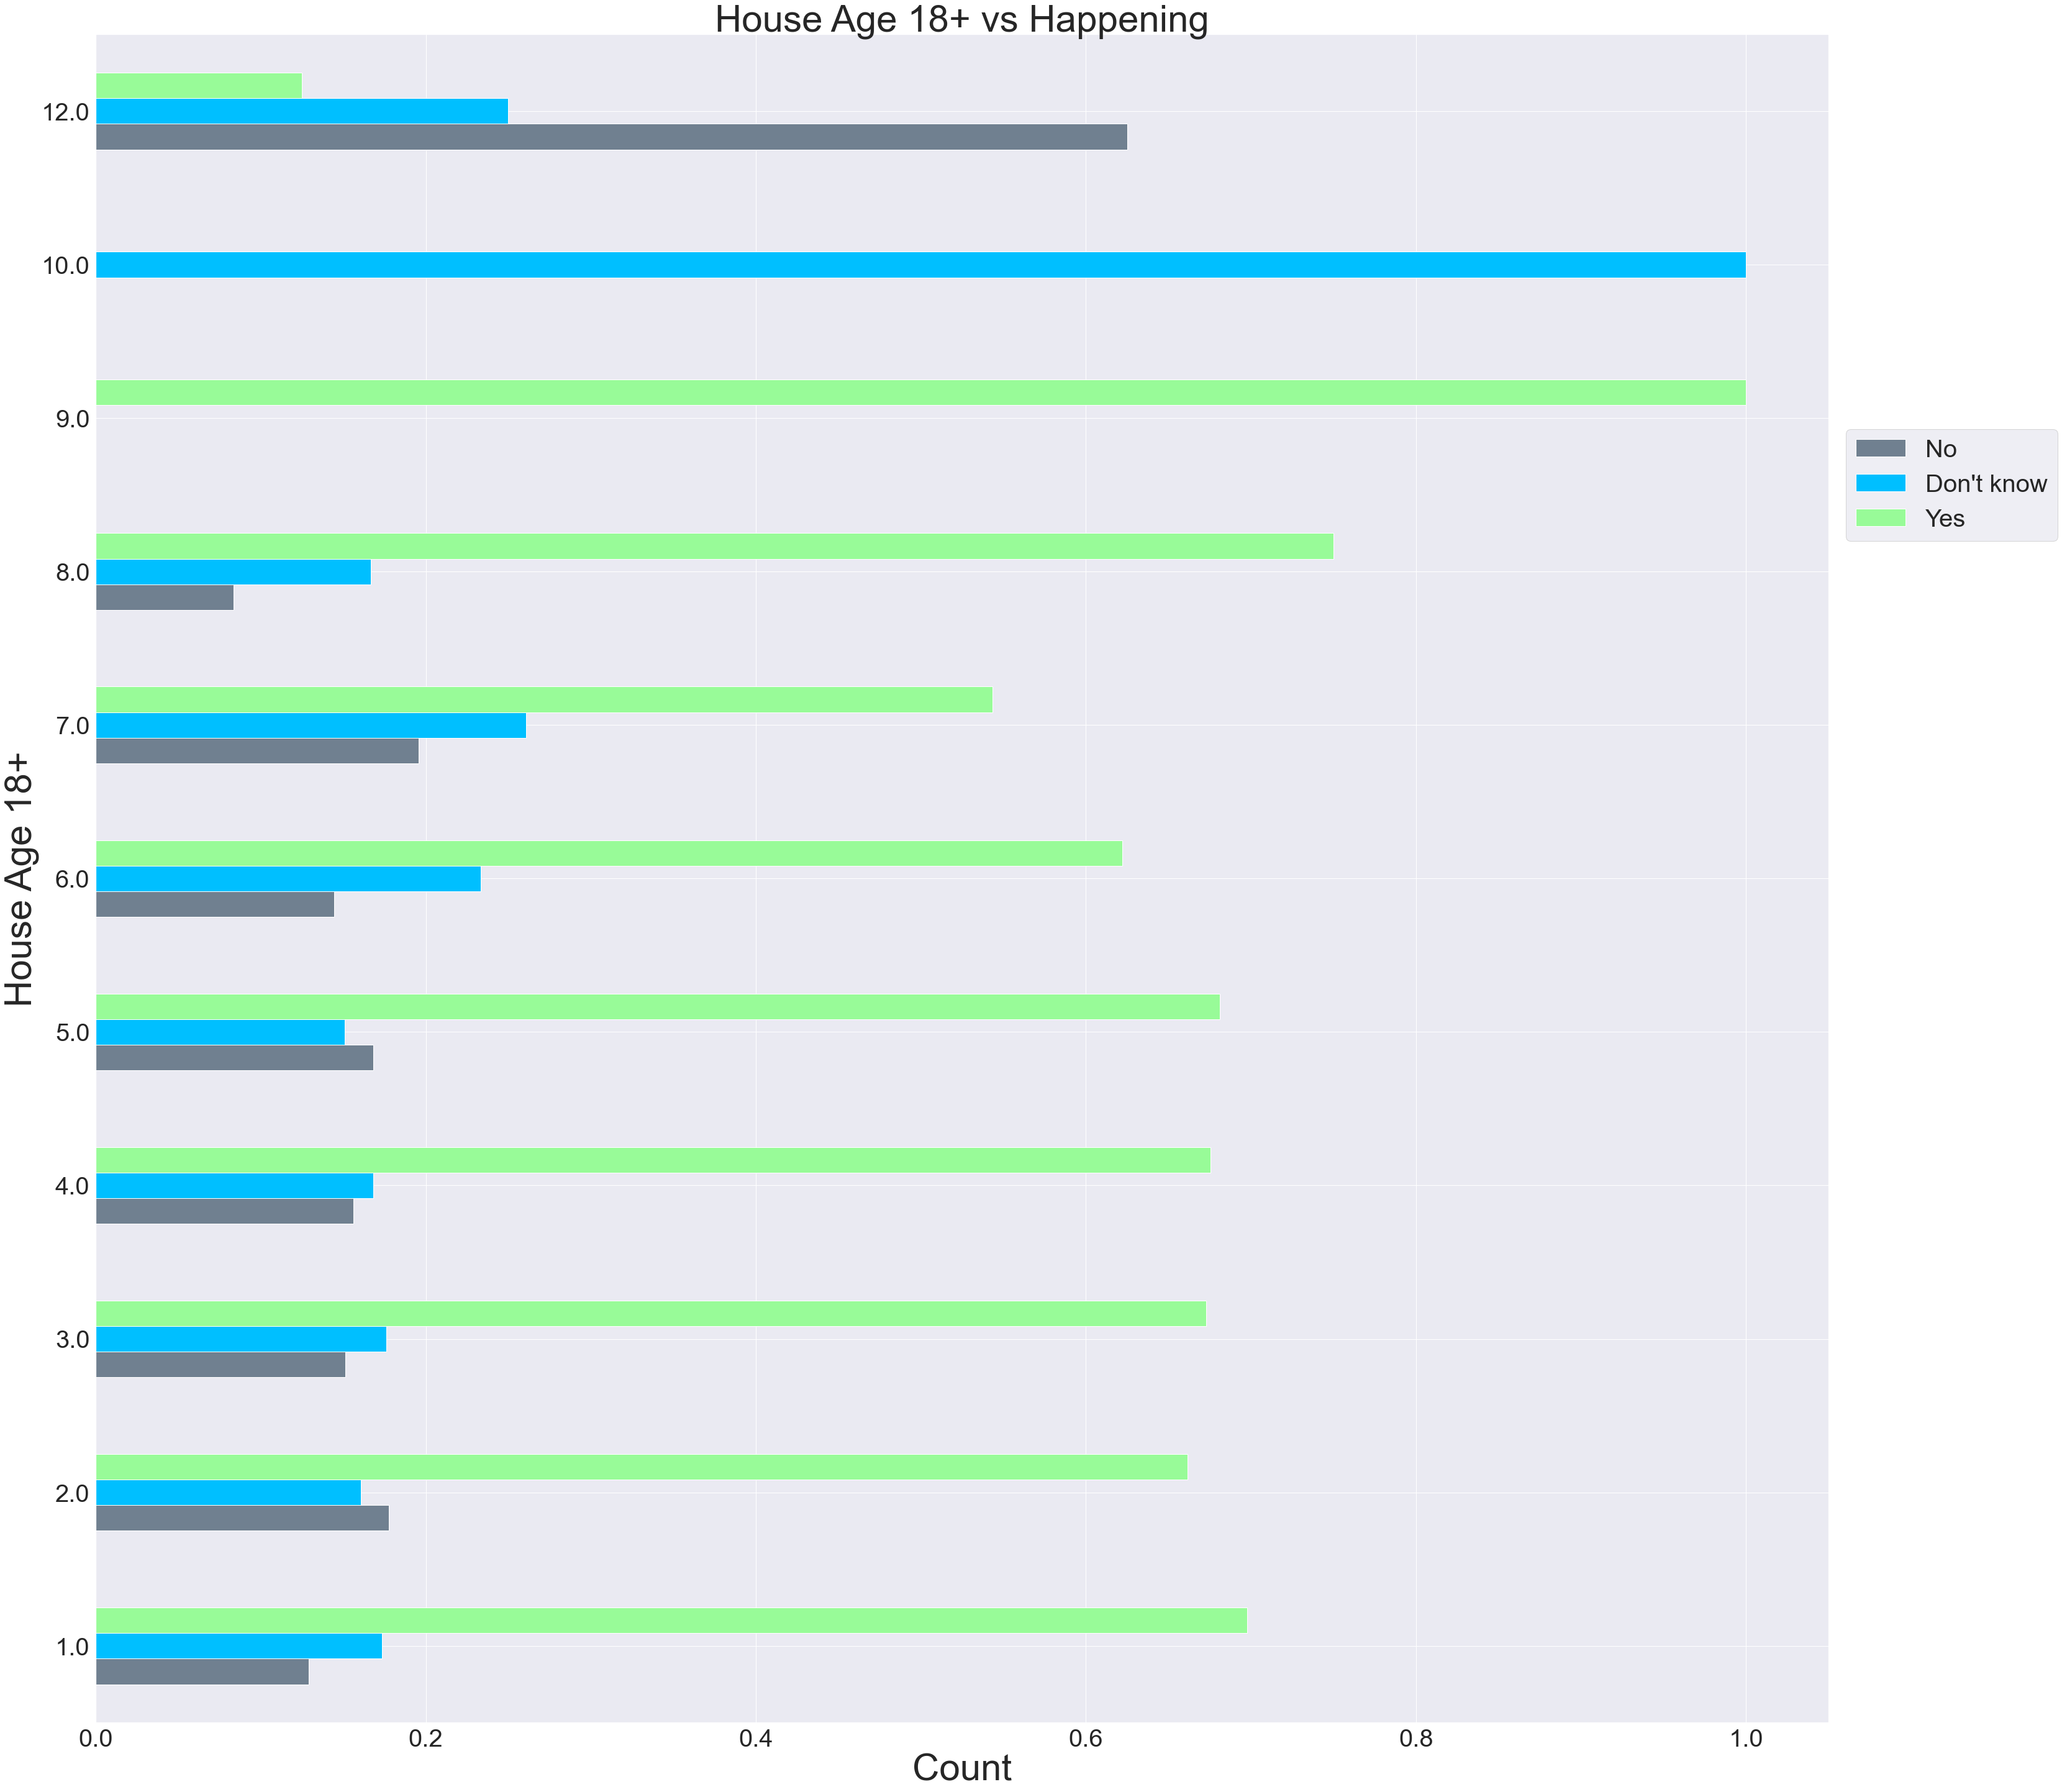

In [210]:
ax = df.groupby('house_ages18plus')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Age 18+',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Age 18+ vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **This graph represents the distribution of`happening` vs house members age 18+.** 
- **0 is the dominant group** 


In [211]:
df.house_type.value_counts(normalize=True)

One-family house detached from any other house                                    0.723061
Building with 2 or more apartments                                                0.154592
One-family house attached to one or more houses (such as a condo or townhouse)    0.075741
Mobile home                                                                       0.044182
Boat, RV, van, etc.                                                               0.002424
Name: house_type, dtype: float64

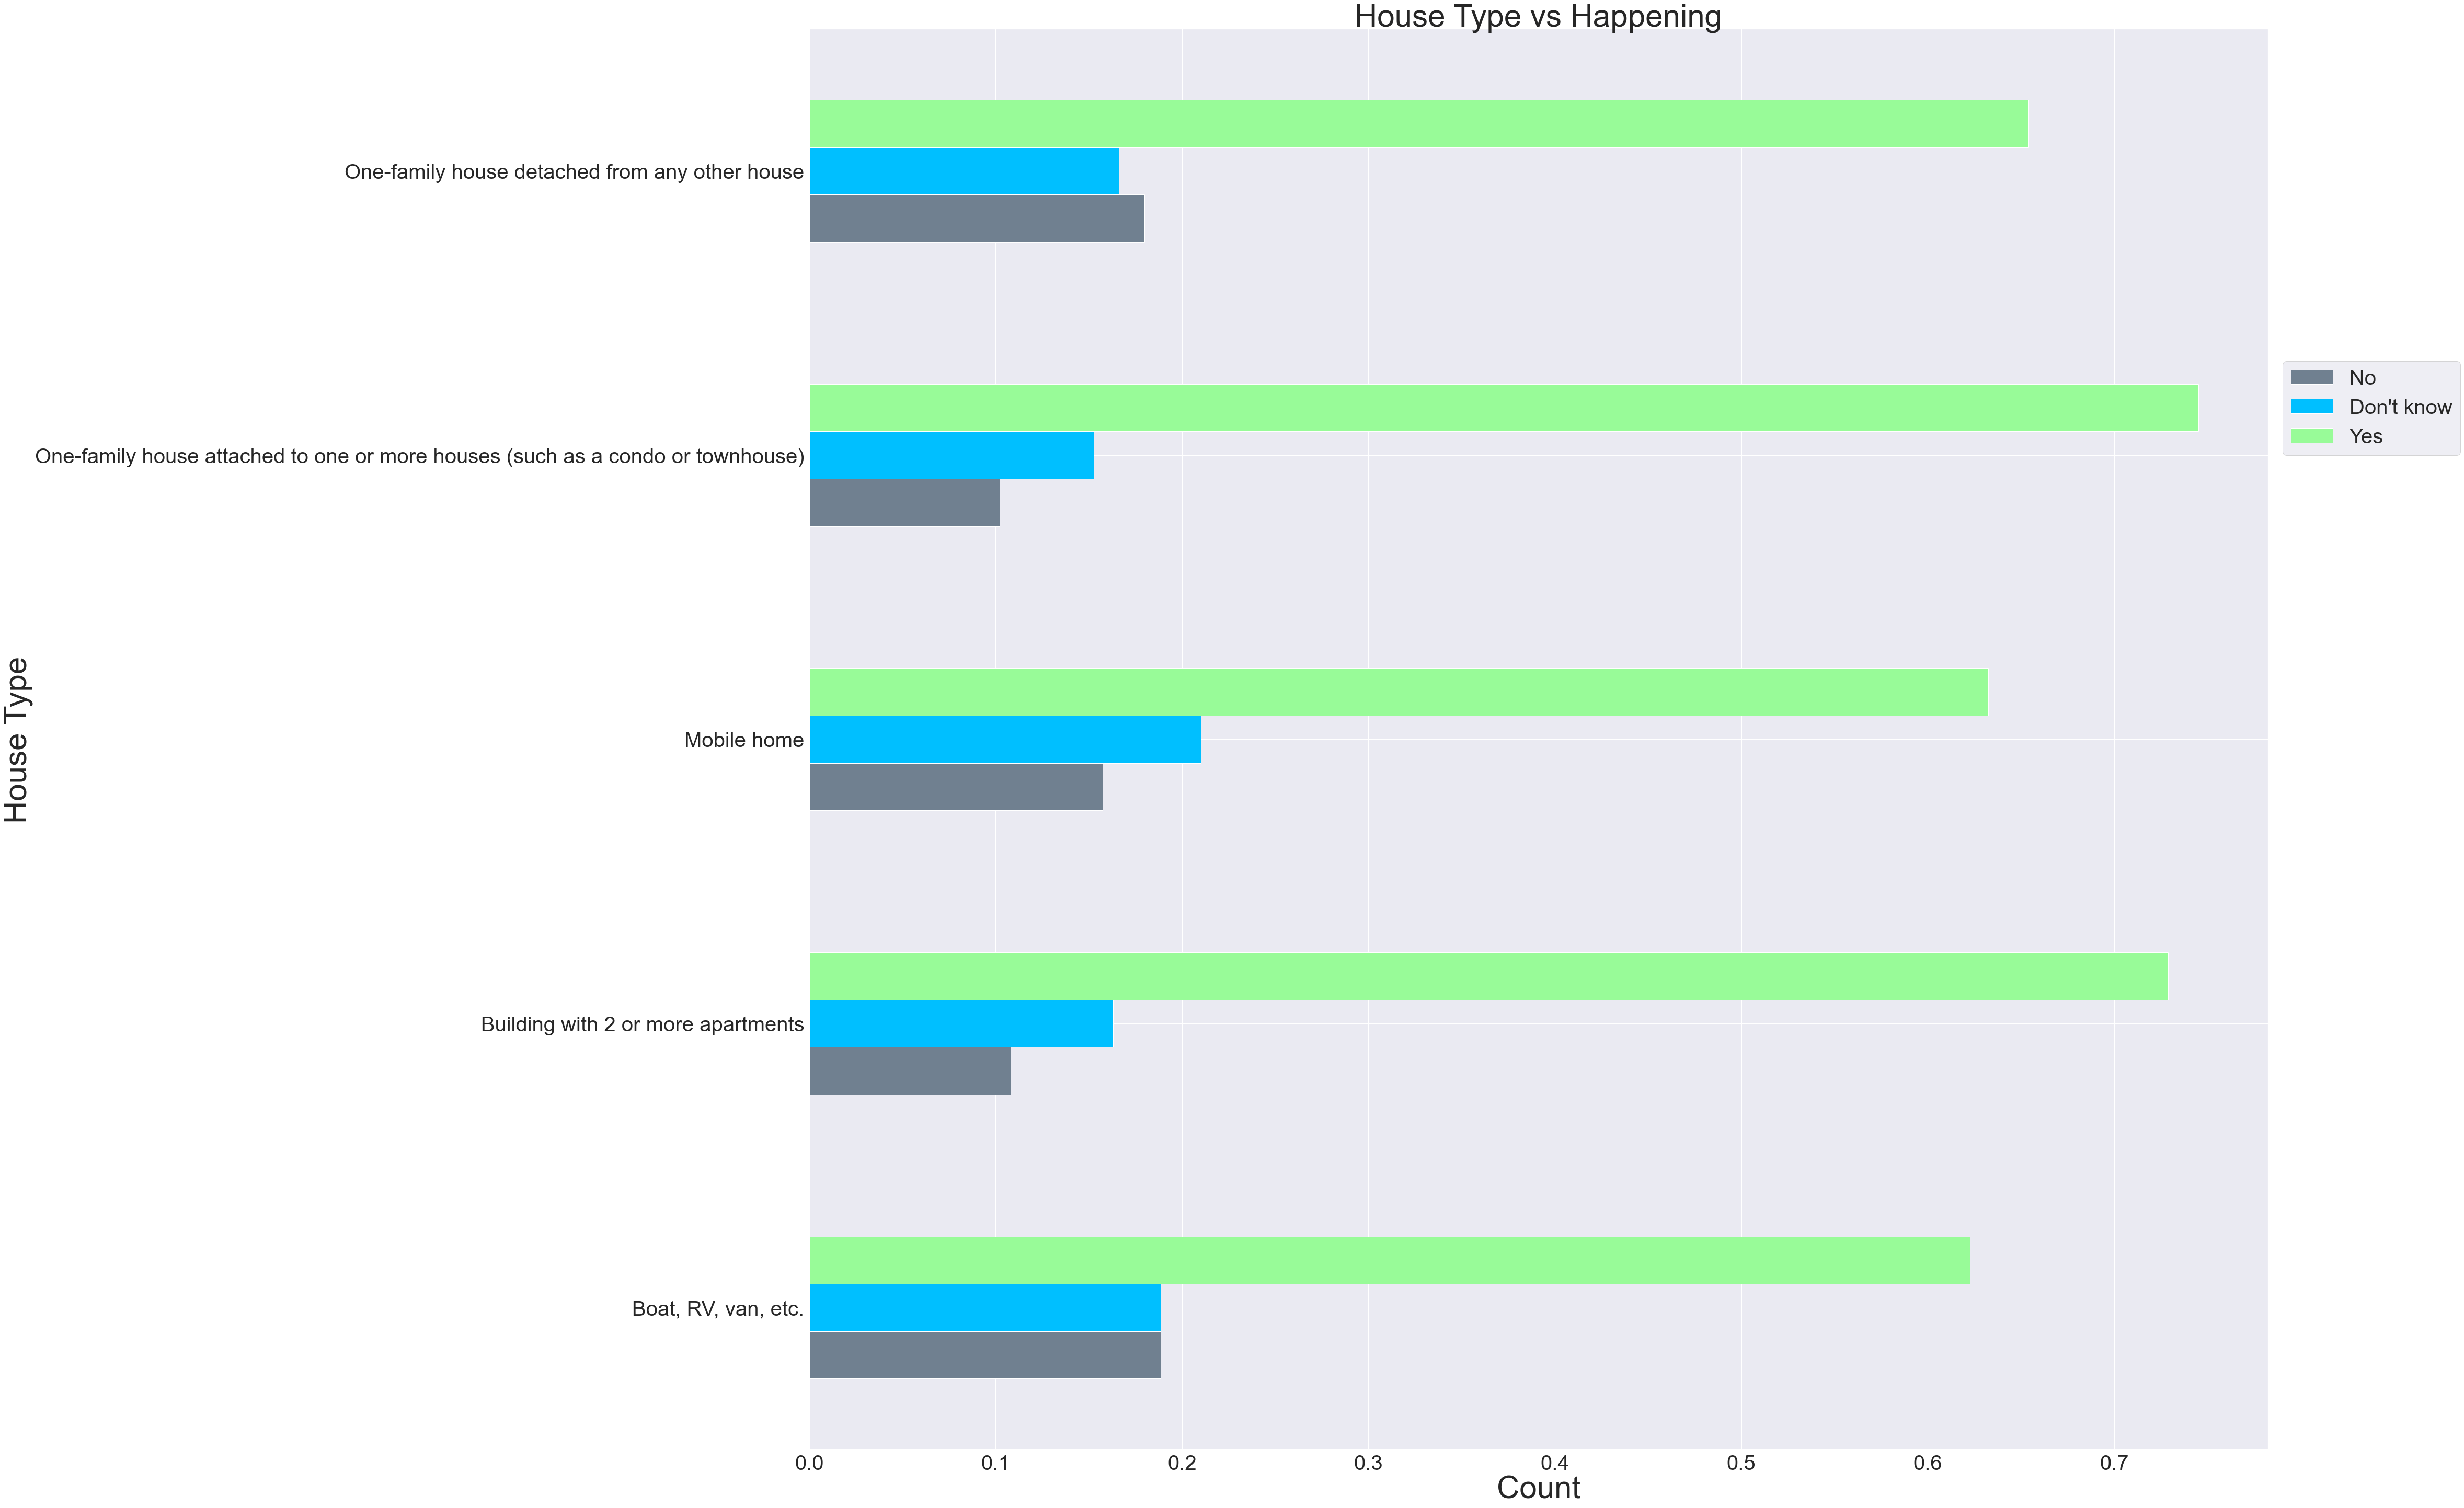

In [212]:
ax = df.groupby('house_type')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Type',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Type vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **One family house are pre-dominant.** 
- **People with mobile homes seem to have a higher proportion of non-believers of climate change** 


In [213]:
df.house_own.value_counts(normalize=True)

Owned by you or someone in your household    0.748033
Rented                                       0.228366
Occupied without payment of rent             0.023600
Name: house_own, dtype: float64

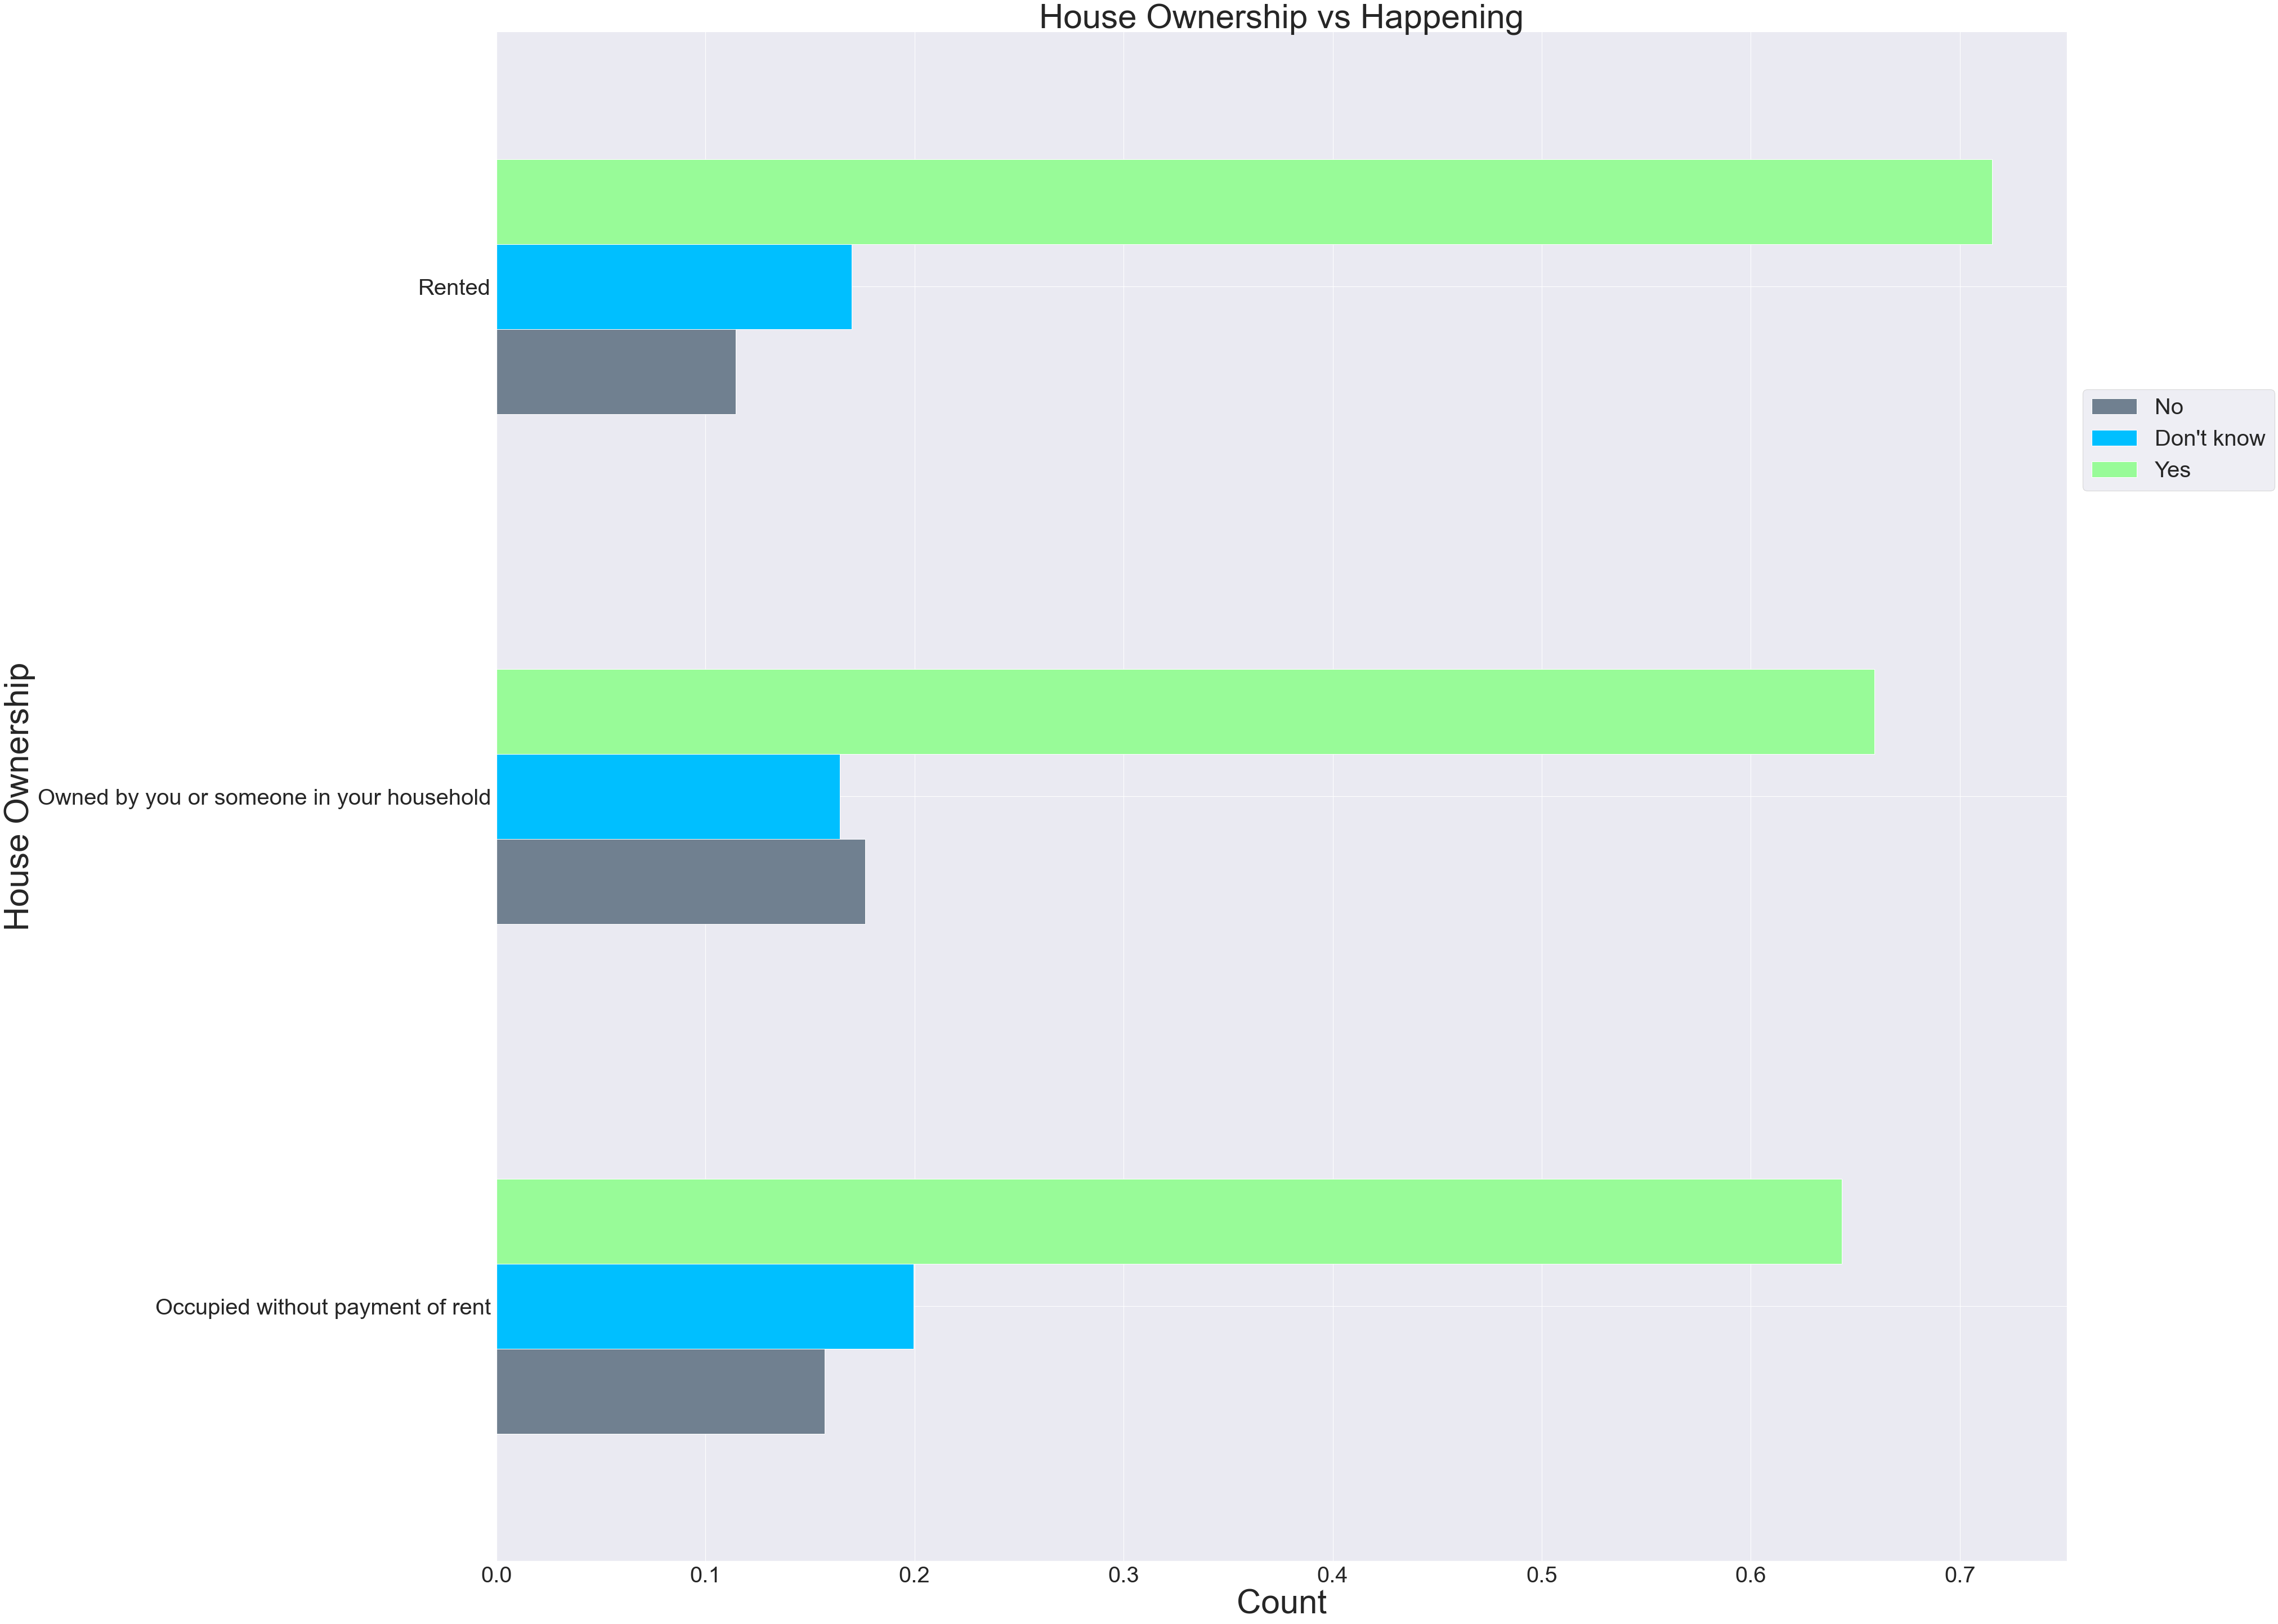

In [214]:
ax = df.groupby('house_own')['happening'].value_counts(normalize=True).unstack().T.loc[['No',"Don't know",'Yes']].T.plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Ownership',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Ownership vs Happening',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);



- **houses owned by an individual or a family member are pre-dominant.** 


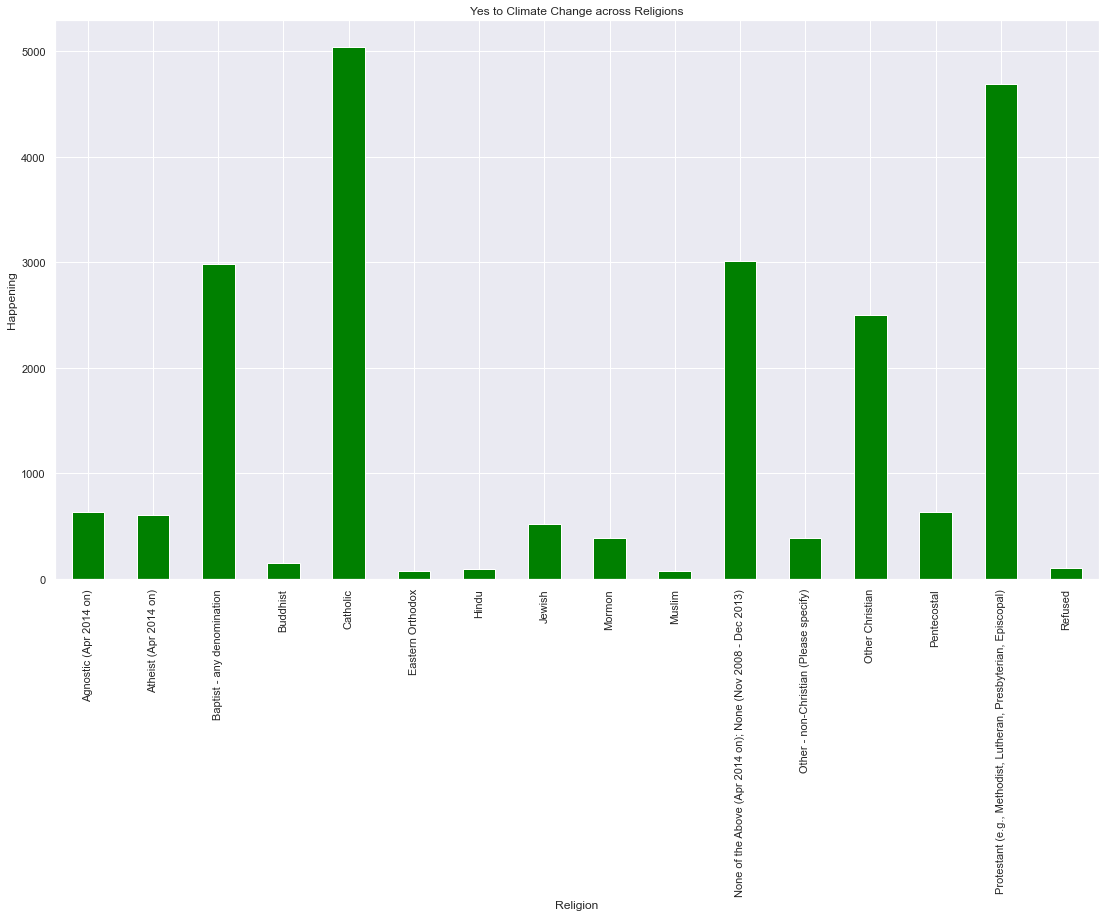

In [215]:
ax = df.groupby(['religion'])['happening'].count().plot(kind='bar',stacked = True, color='green')
ax.set_xlabel('Religion')
ax.set_ylabel('Happening')
ax.set_title('Yes to Climate Change across Religions');




- **This graph represents the believers in climate change across religions.** 
- **The numbers vary due to different population of respective religion people** 
- **As expected for American society Catholic and Protestant have highest number of counts followed by Atheists and Baptists**

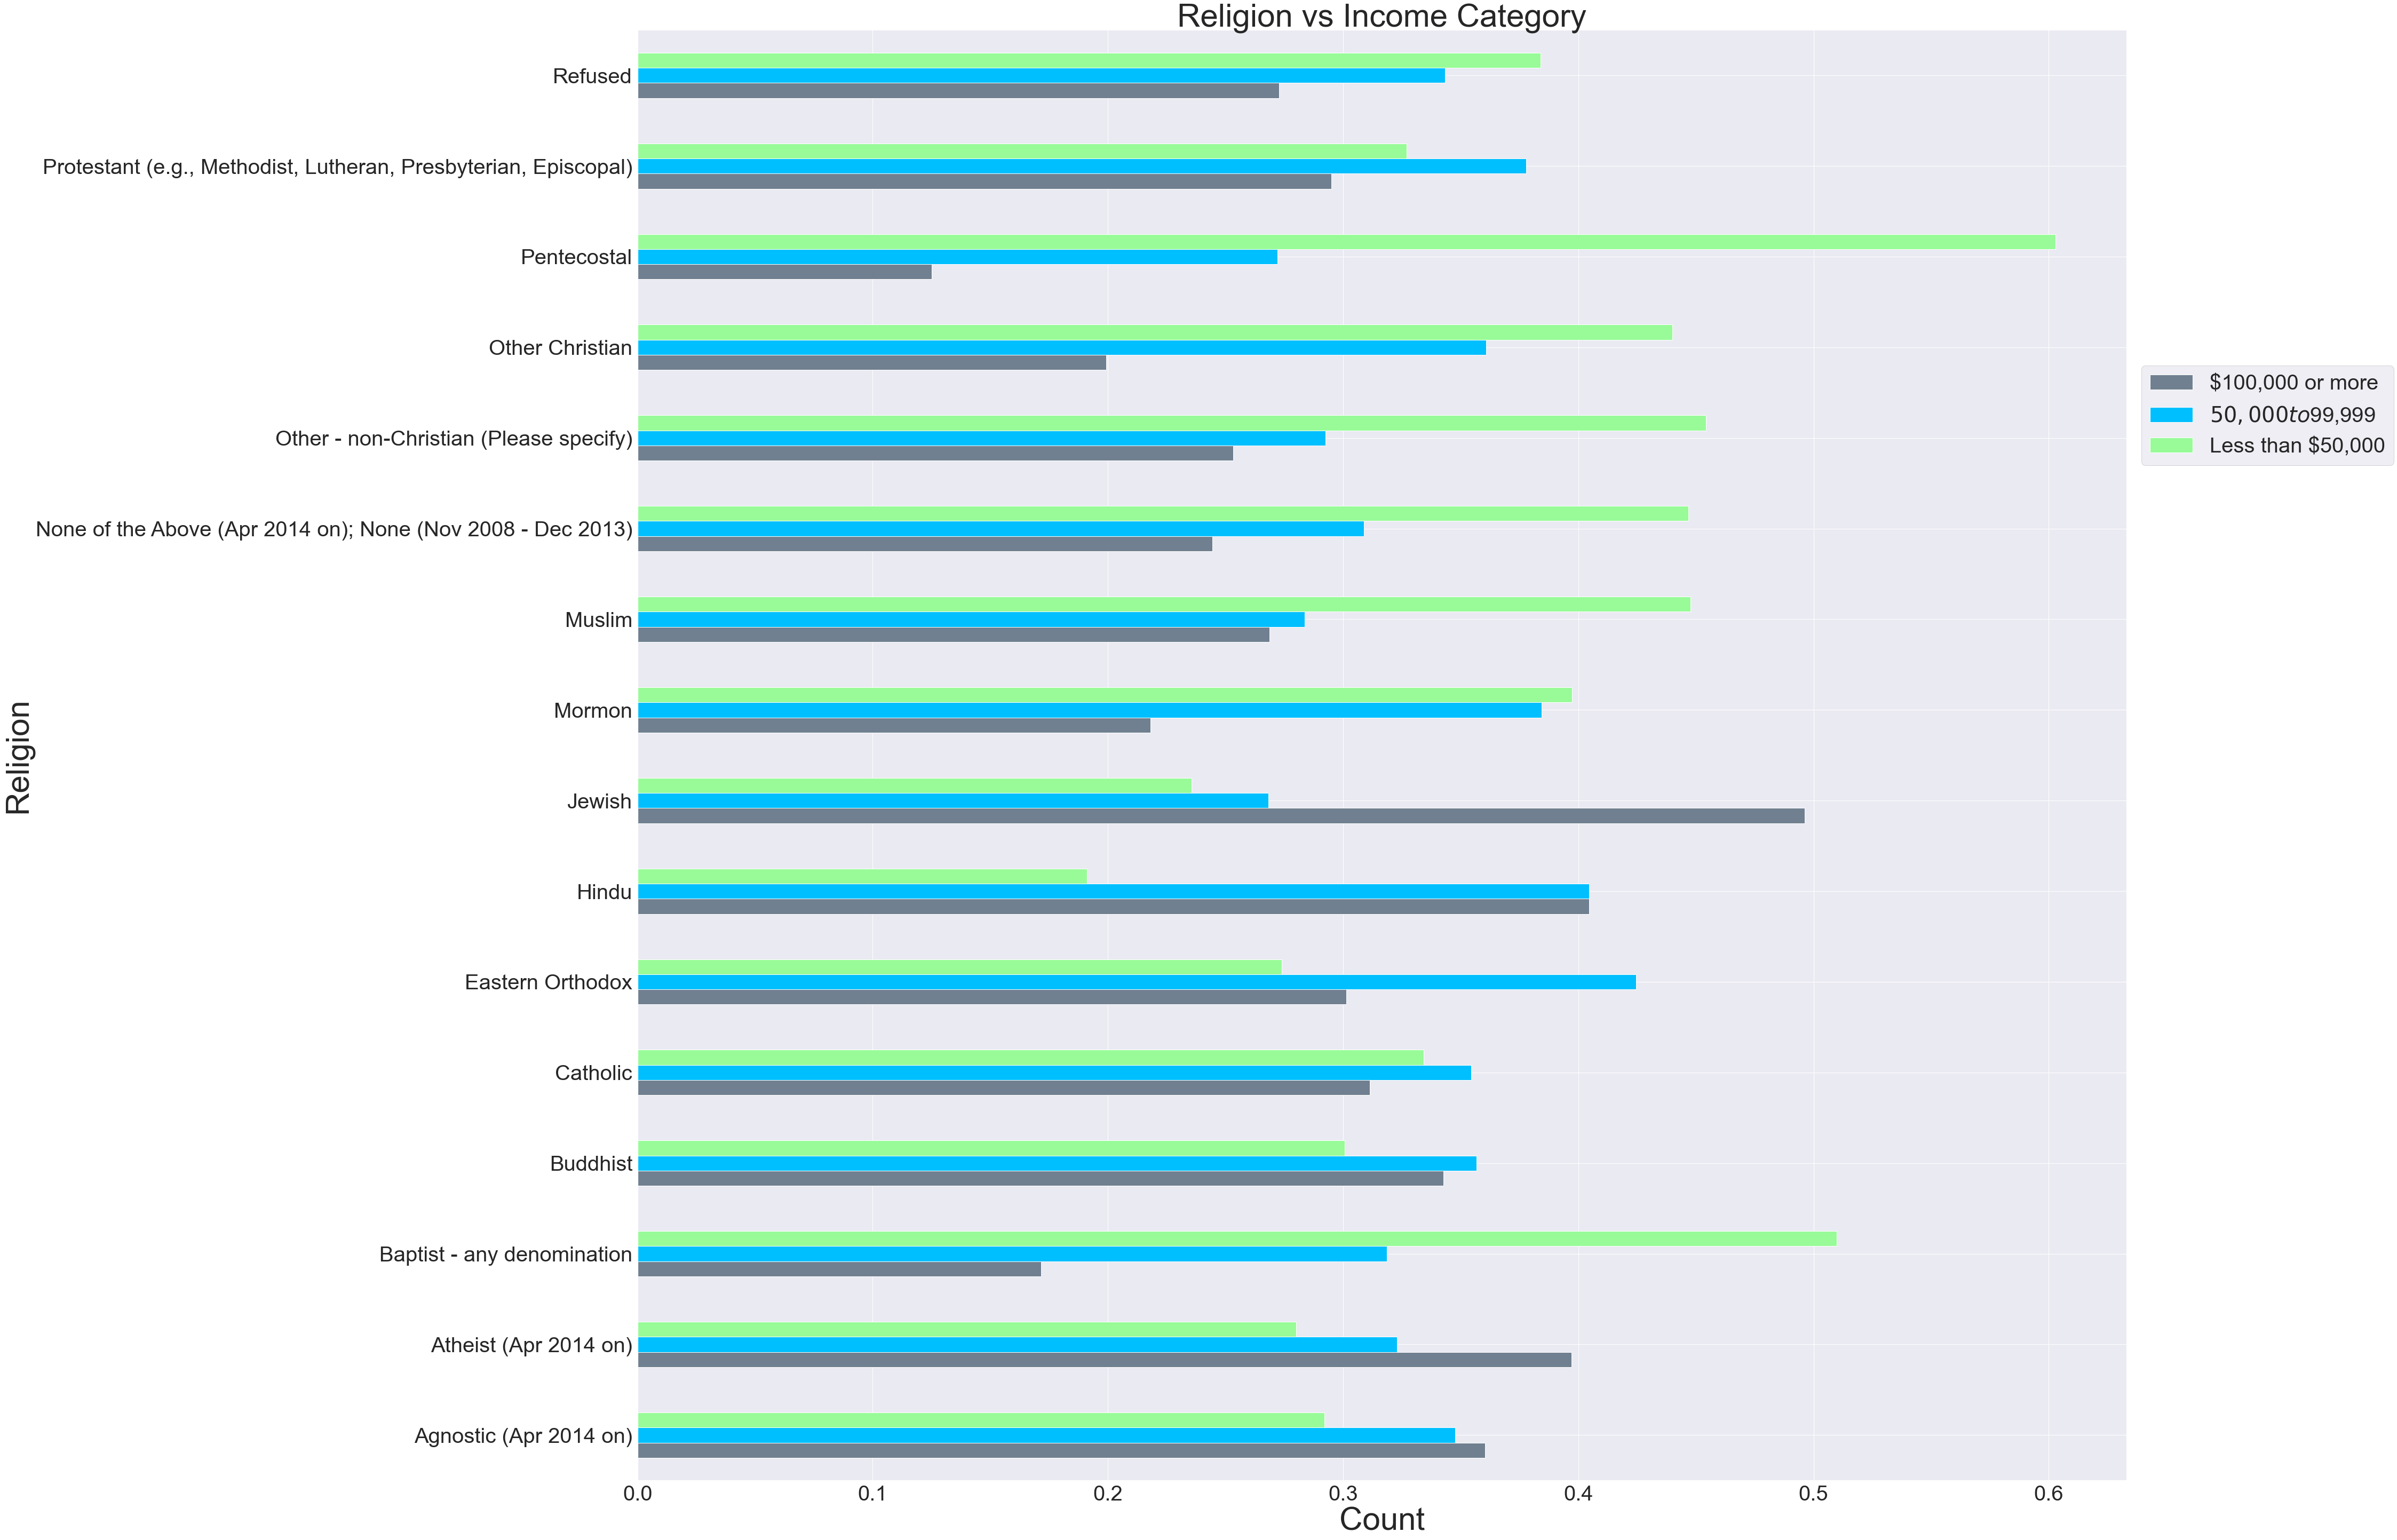

In [216]:
ax = df.groupby(['religion'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Religion',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Religion vs Income Category',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);


- **High income category is prominent in Jewish, Atheist and Agnostic**
- **Middle income category is prominent in Protestant, Catholic, Eastern Orthodox**
- **Low Income category is predominant in all other religions**


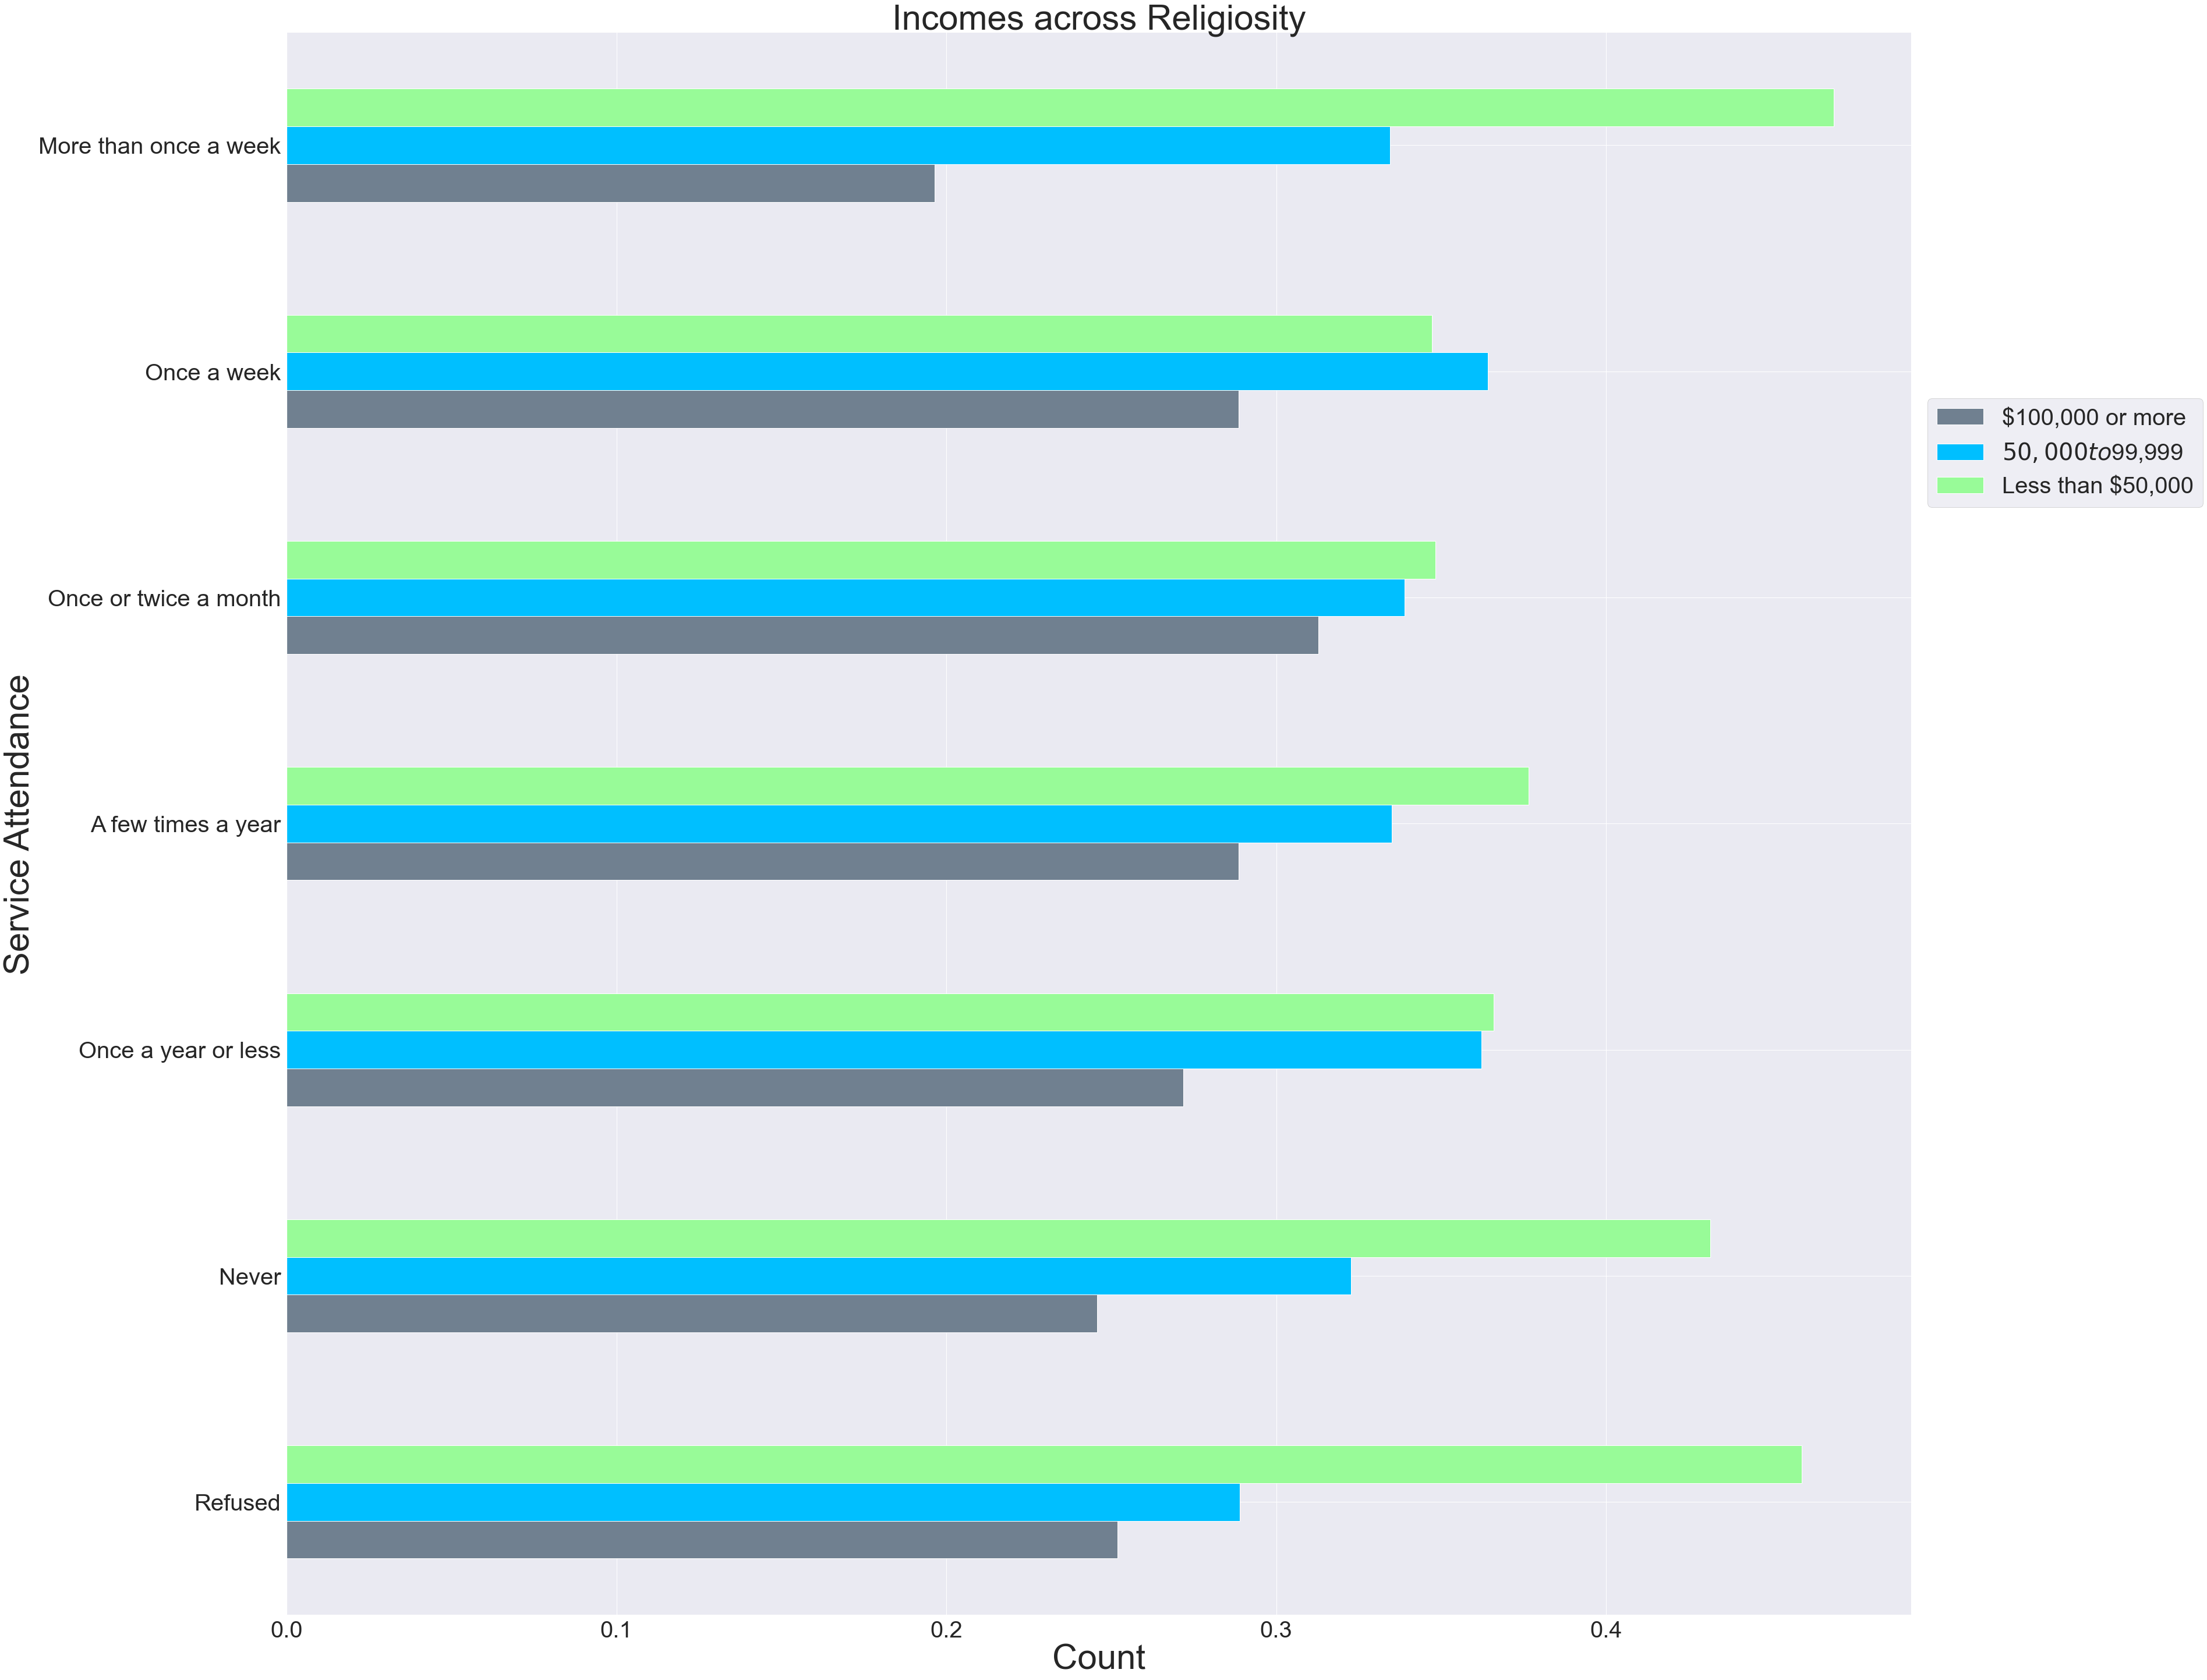

In [217]:
ax = df.groupby(['service_attendance'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
                color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Service Attendance',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Incomes across Religiosity',fontsize=60)
plt.setp(ax.get_xticklabels(), fontsize=40)
ax.set_yticklabels(['Refused','Never','Once a year or less','A few times a year','Once or twice a month','Once a week','More than once a week'],fontsize=40);
#-1. Refused
# 1. Never
# 2. Once a year or less
# 3. A few times a year
# 4. Once or twice a month
# 5. Once a week
# 6. More than once a week


- **To my surprise people who never go for service attendance(marked 1) have the most people in low income category**
- **Low income category is most represented across various groups**


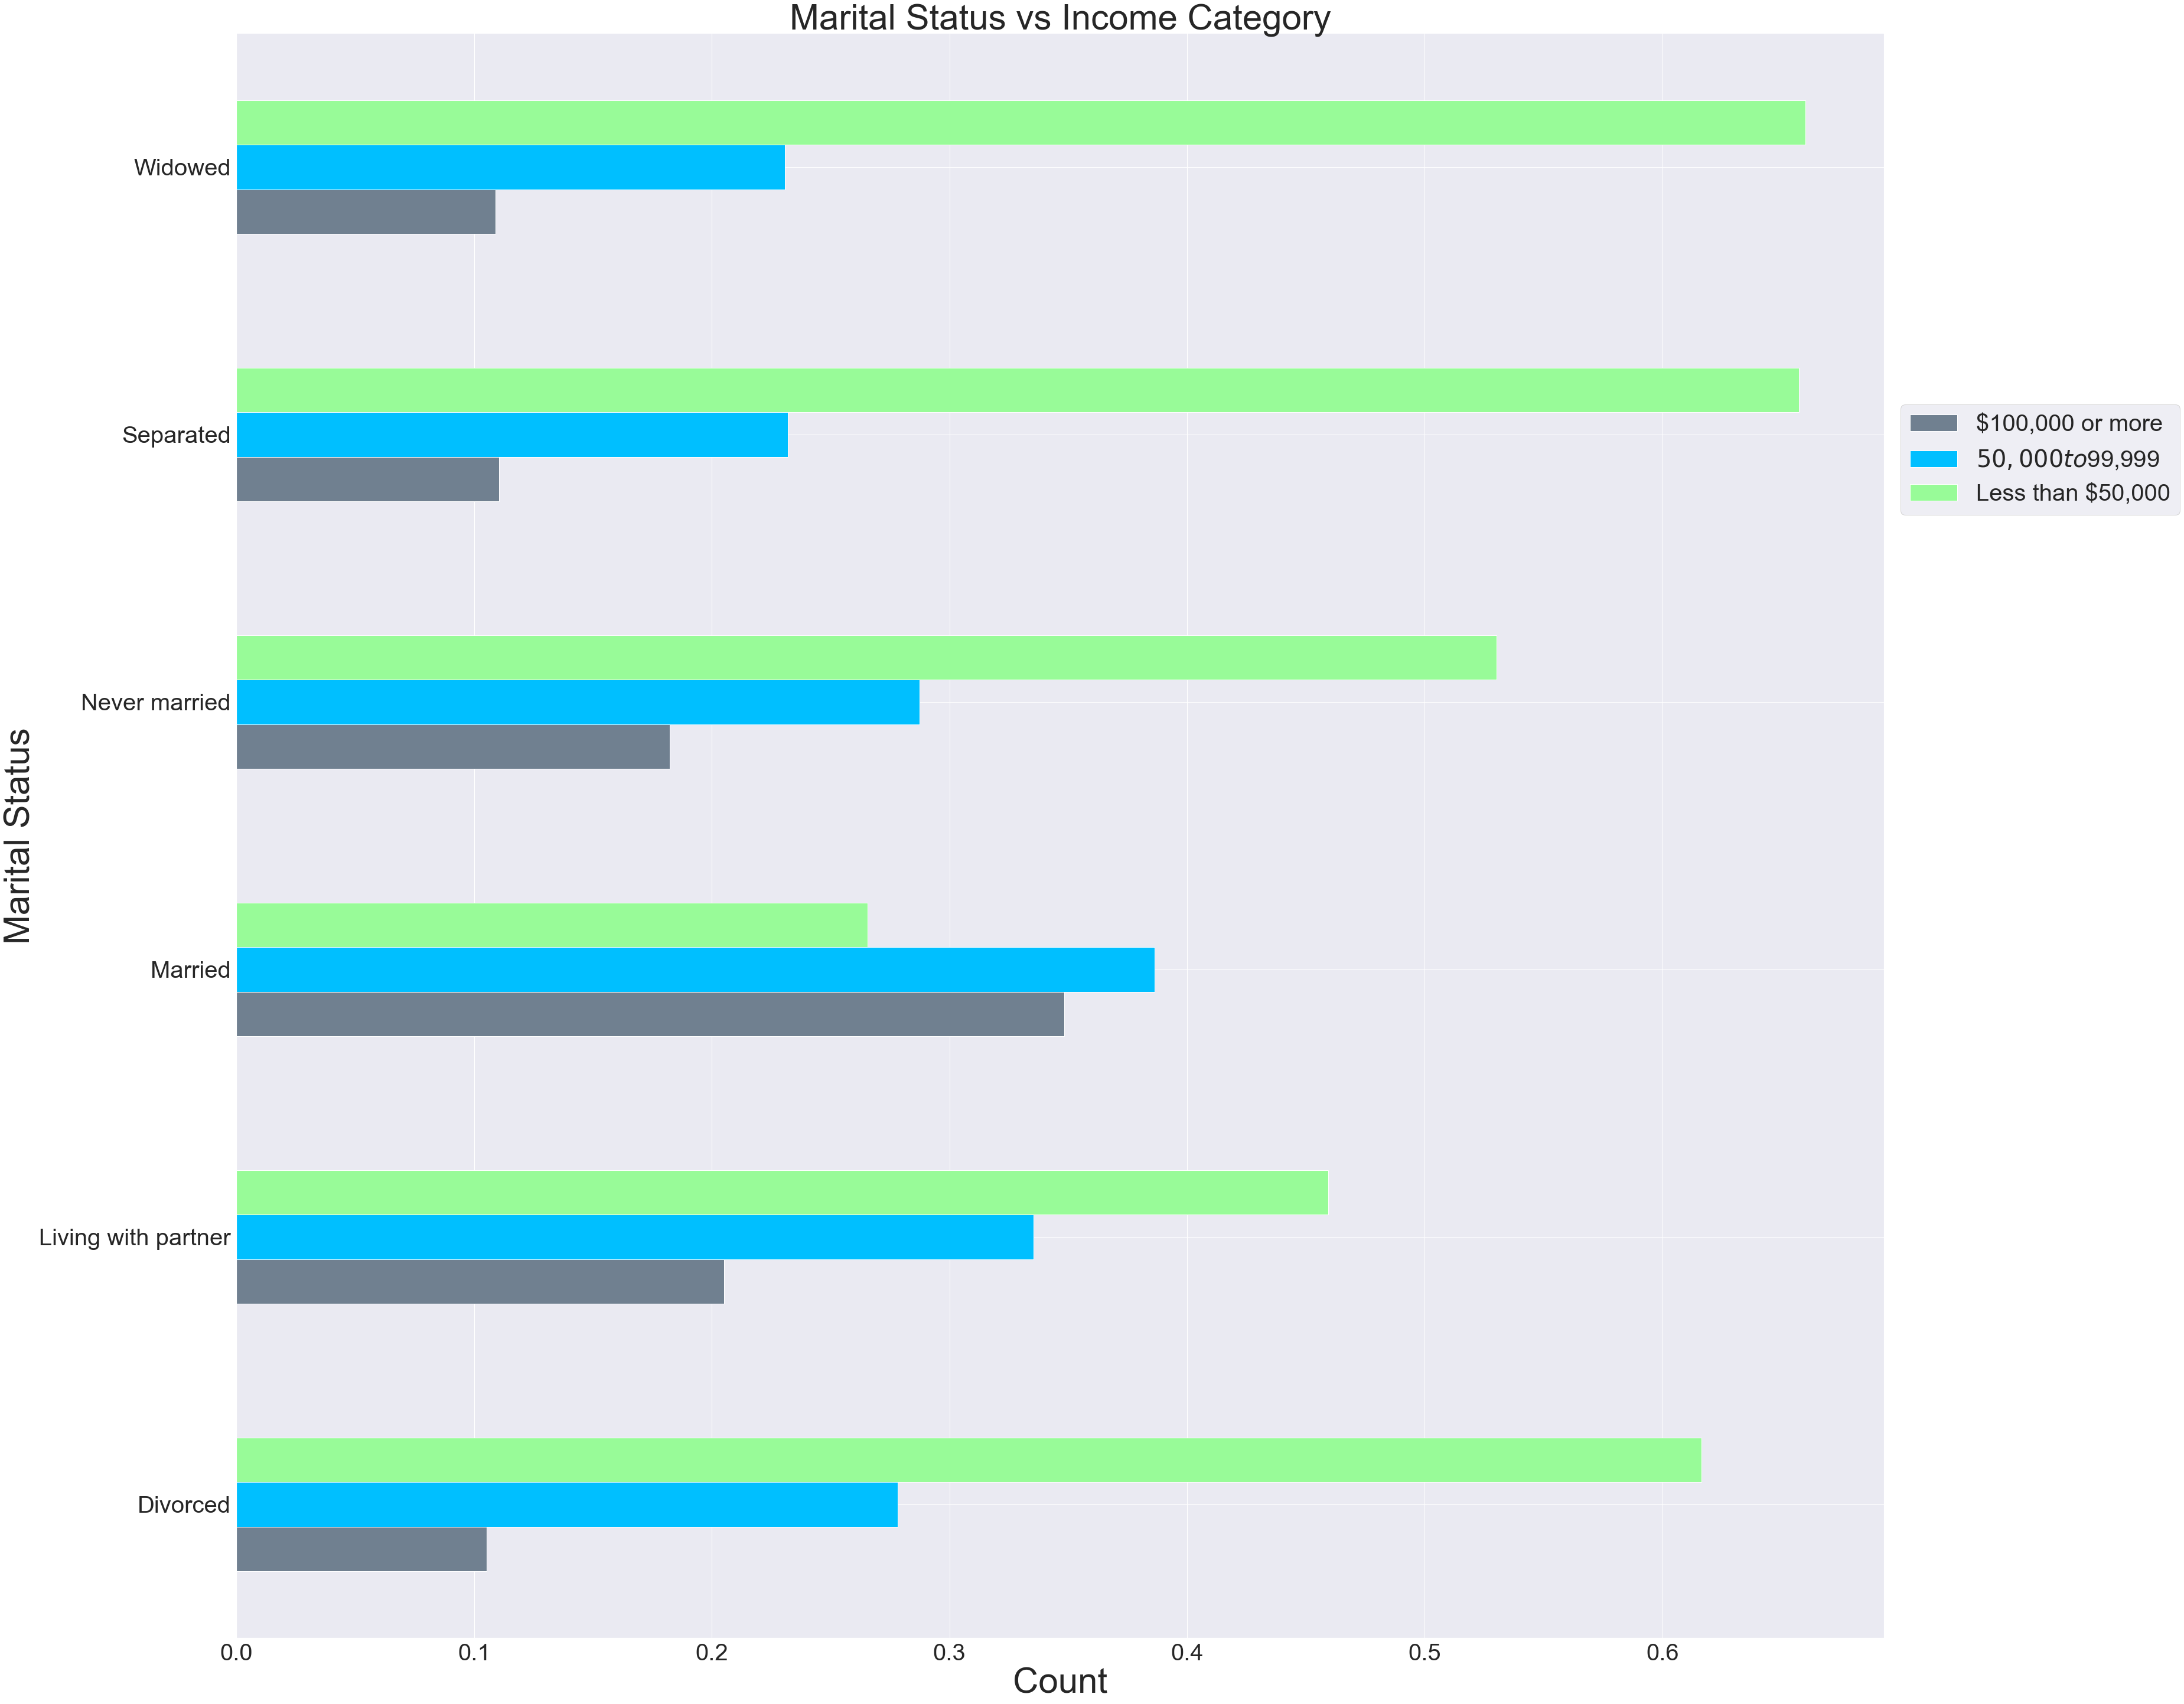

In [218]:
ax = df.groupby(['marit_status'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('Marital Status',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('Marital Status vs Income Category',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);

- **Low Income category has most people lying in it except for the Married group where Middle Income is predominant**
- **Married people are likely to have more income than the rest**


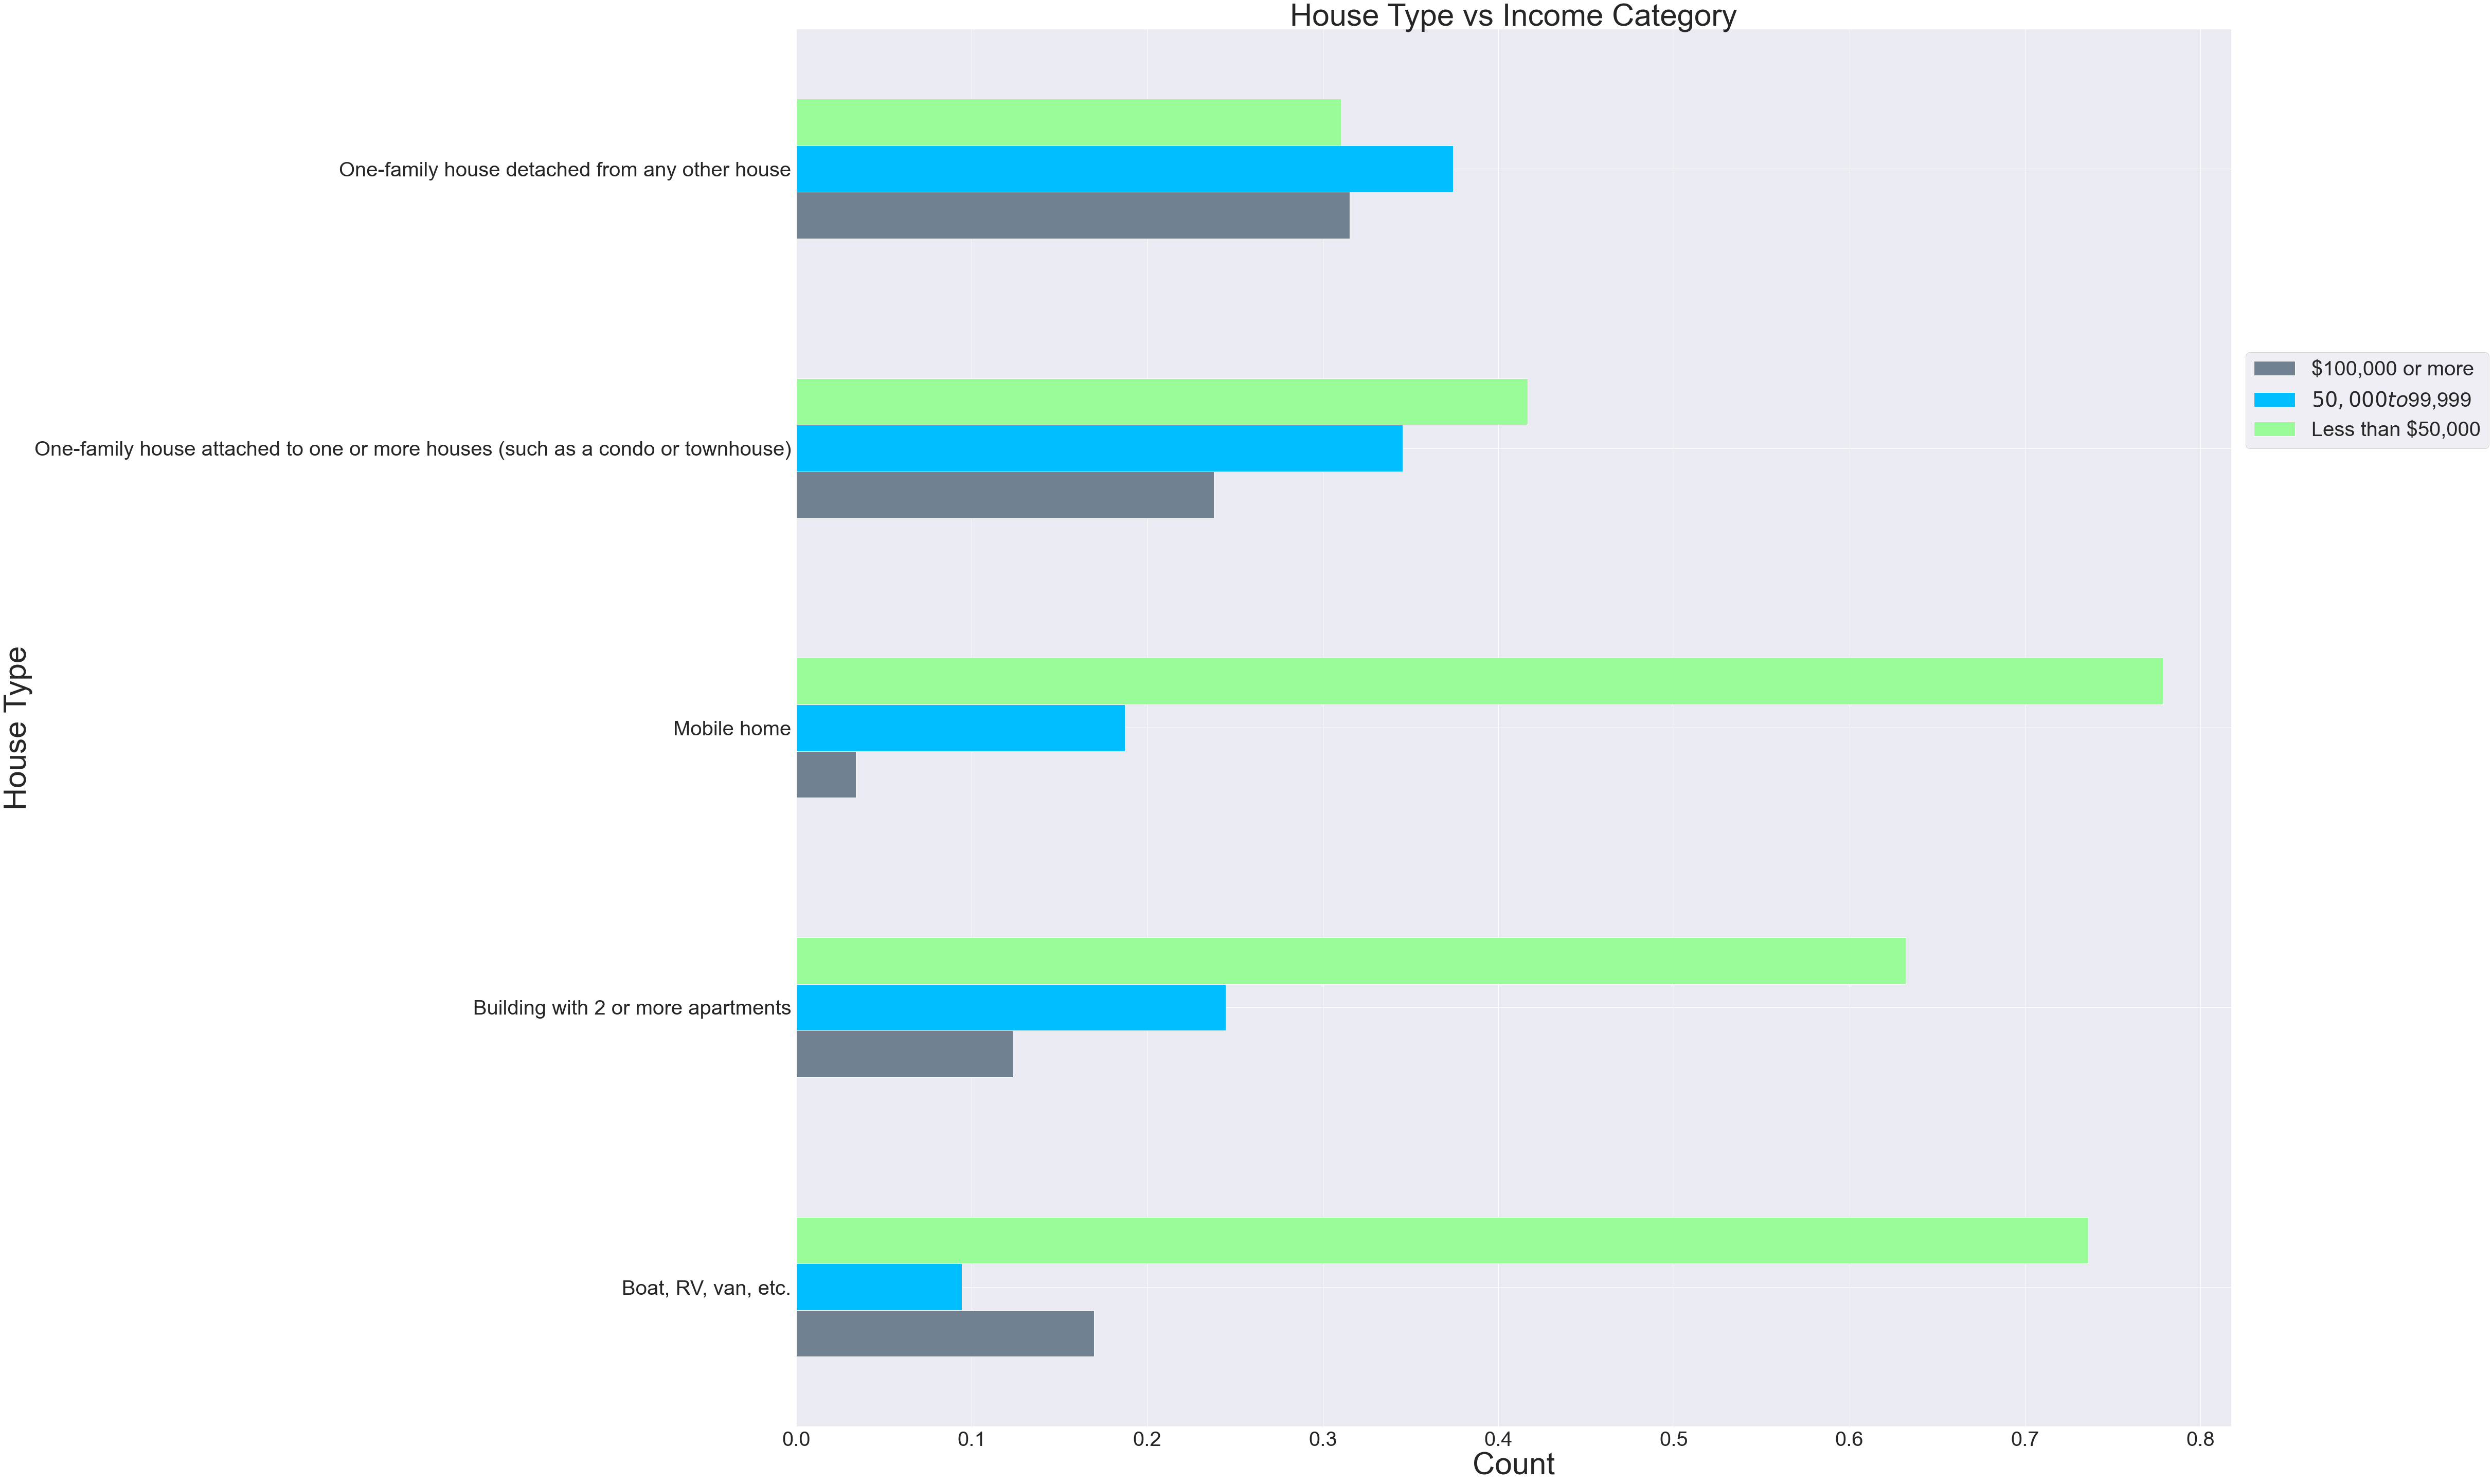

In [219]:
ax = df.groupby(['house_type'])['income_category'].value_counts(normalize=True).unstack().plot(kind='barh', figsize=(50,50),
color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_ylabel('House Type',fontsize=60)
ax.set_xlabel('Count',fontsize=60)
ax.legend(loc= (1.01,0.7),fontsize =40)
ax.set_title('House Type vs Income Category',fontsize =60)
plt.setp(ax.get_xticklabels(), fontsize=40)
plt.setp(ax.get_yticklabels(), fontsize=40);

**- Middle income people are more likely to own a One-Family house**

In [220]:
my_columns=['religion','religion_other_nonchristian', 'evangelical', 'service_attendance',
       'marit_status', 'employment', 'house_head', 'house_size',
       'house_ages0to1', 'house_ages2to5', 'house_ages6to12',
       'house_ages13to17', 'house_ages18plus', 'house_type', 'house_own']

In [221]:
df[my_columns].dtypes

religion                        object
religion_other_nonchristian     object
evangelical                     object
service_attendance               int64
marit_status                    object
employment                      object
house_head                      object
house_size                     float64
house_ages0to1                 float64
house_ages2to5                 float64
house_ages6to12                float64
house_ages13to17               float64
house_ages18plus               float64
house_type                      object
house_own                       object
dtype: object

In [222]:
df['service_attendance']=df['service_attendance'].astype(np.int64)
df['house_size']=df['house_size'].astype(np.int64)
df['house_ages0to1']=df['house_ages0to1'].astype(np.int64)
df['house_ages2to5']=df['house_ages2to5'].astype(np.int64)
df['house_ages6to12']=df['house_ages6to12'].astype(np.int64)
df['house_ages13to17']=df['house_ages13to17'].astype(np.int64)
df['house_ages18plus']=df['house_ages18plus'].astype(np.int64)

In [223]:
df[my_columns].corr()

service_attendance  house_size  house_ages0to1  \
service_attendance            1.000000    0.075189        0.020820   
house_size                    0.075189    1.000000        0.247579   
house_ages0to1                0.020820    0.247579        1.000000   
house_ages2to5                0.029718    0.415121        0.193268   
house_ages6to12               0.065369    0.560907        0.063252   
house_ages13to17              0.062723    0.507067       -0.015224   
house_ages18plus              0.028628    0.733200        0.036705   

                    house_ages2to5  house_ages6to12  house_ages13to17  \
service_attendance        0.029718         0.065369          0.062723   
house_size                0.415121         0.560907          0.507067   
house_ages0to1            0.193268         0.063252         -0.015224   
house_ages2to5            1.000000         0.237578          0.019229   
house_ages6to12           0.237578         1.000000          0.212890   
house_ages13to17          0.019229         0.212890          1.000000   
house_ages18plus          0.057075         0.061566          0.133434   

                    house_ages18plus  
service_attendance          0.028628  
house_size                  0.733200  
house_ages0to1              0.036705  
house_ages2to5              0.057075  
house_ages6to12             0.061566  
house_ages13to17            0.133434  
house_ages18plus            1.000000

In [224]:
df[my_columns].describe()

service_attendance    house_size  house_ages0to1  house_ages2to5  \
count        21864.000000  21864.000000    21864.000000    21864.000000   
mean             3.113611      2.670143        0.042078        0.106522   
std              1.769576      1.471793        0.230272        0.369992   
min             -1.000000      1.000000        0.000000        0.000000   
25%              1.000000      2.000000        0.000000        0.000000   
50%              3.000000      2.000000        0.000000        0.000000   
75%              5.000000      4.000000        0.000000        0.000000   
max              6.000000     15.000000        7.000000        4.000000   

       house_ages6to12  house_ages13to17  house_ages18plus  
count     21864.000000      21864.000000      21864.000000  
mean          0.204400          0.187065          2.130077  
std           0.558827          0.497117          0.948813  
min           0.000000          0.000000          1.000000  
25%           0.000000          0.000000          2.000000  
50%           0.000000          0.000000          2.000000  
75%           0.000000          0.000000          2.000000  
max           6.000000          4.000000         12.000000

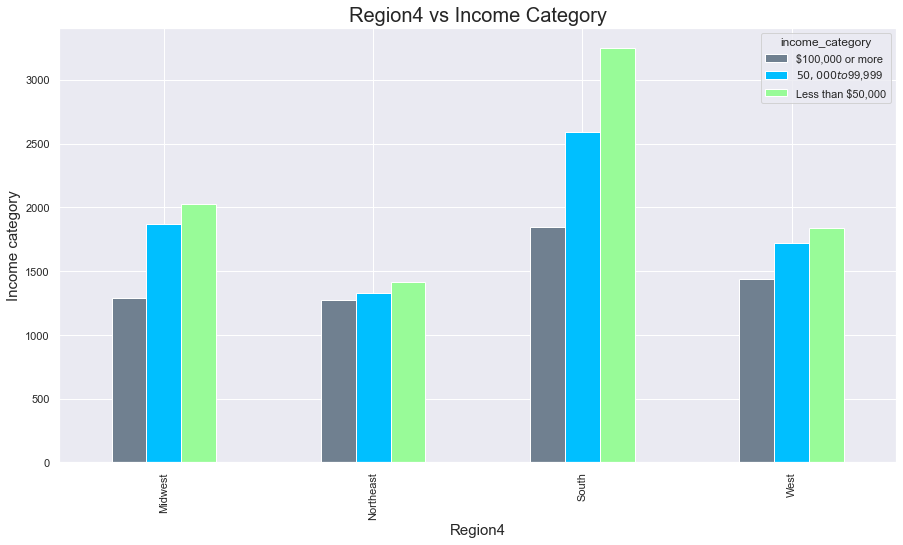

In [225]:
ax= pd.crosstab(index=df['region4'],columns=df['income_category']).plot.bar(figsize=(15,8),color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_xlabel('Region4',fontsize=15)
ax.set_ylabel('Income category',fontsize=15)
ax.set_title('Region4 vs Income Category',fontsize=20);

- **Low income category is predominant**
- **High income is less represented across regions**

In [226]:
# ax= pd.crosstab(index=df['region9'],columns=df['income_category']).plot.bar(figsize=(15,8),color=['slategrey', 'deepskyblue', 'palegreen'])
# ax.set_xlabel('Region9',fontsize=15)
# ax.set_ylabel('Income category',fontsize=15)
# ax.set_title('Region9 vs Income Category',fontsize=20);

- **Low Income is predominant across regions except New England and West-North Central**
- **High income is predominant in New England**
- **Stark  inequality in East South Central region**
- **Pacific region has almost uniform distribution of low, medium and high income categories**

In [227]:
df[['house_size','house_ages18plus']].corr()

house_size  house_ages18plus
house_size            1.0000            0.7332
house_ages18plus      0.7332            1.0000

- **Very high correlation between house_size and house_ages18plus might drop one of them**
- **Keep `children` as defined below and either of `house_size` or `house_ages18plus`and leave out `house_ages0to1`, `house_ages2to5`, `house_ages6to12`, `house_ages13to17`**

In [228]:
df[['house_ages0to1', 'house_ages2to5', 'house_ages6to12',
       'house_ages13to17', 'house_ages18plus','house_size']]

house_ages0to1  house_ages2to5  house_ages6to12  house_ages13to17  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   
...               ...             ...              ...               ...   
21859               0               0                0                 0   
21860               0               1                3                 0   
21861               0               0                0                 0   
21862               0               1                0                 0   
21863               1               0                0                 0   

       house_ages18plus  house_size  
0                     3           3  
1                     2           2  
2                     2           2  
3                     2           2  
4                     2           2  
...                 ...         ...  
21859                 2           2  
21860                 4           8  
21861                 2           2  
21862                 4           5  
21863                 2           3  

[21864 rows x 6 columns]

In [229]:
df['children'] =df['house_ages0to1']+df['house_ages2to5']+df['house_ages6to12']+df['house_ages13to17']

In [230]:
df['children'].describe()

count    21864.000000
mean         0.540066
std          1.009285
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         10.000000
Name: children, dtype: float64

- **All good with `children` column**

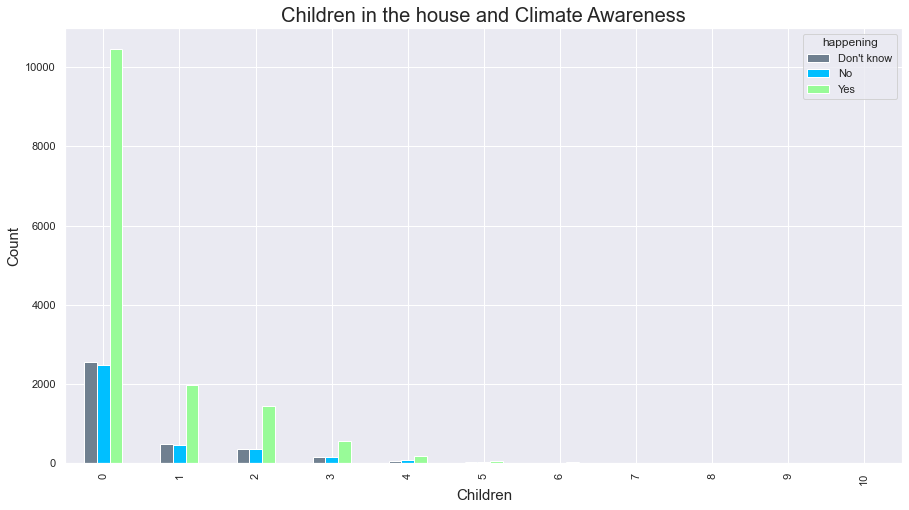

In [231]:
ax= pd.crosstab(index=df['children'],columns=df['happening']).plot.bar(figsize=(15,8),color=['slategrey', 'deepskyblue', 'palegreen'])
ax.set_xlabel('Children', fontsize=15)
ax.set_ylabel('Count',fontsize=15)
ax.set_title('Children in the house and Climate Awareness', fontsize=20);

- **Seems like having more children reduces the climate awareness or that people with more climate awareness are having less children**
- **I was expecting a reverse relationship too that people having children would want to leave a better world for their children so would be more aware, I don't know the exact relationship**

In [232]:
columns_to_keep=['religion', 'service_attendance','marit_status', 'employment', 'house_head',
                 'house_size',  'house_ages18plus','children', 'house_type', 'house_own']

**These are the columns I would like to keep after EDA*

In [233]:
df.to_csv('../data/survey_data_before_pre_processing.csv', index=False)